# Machine learning to predict Power output from wind turbine


***

In [1]:
# Numerical arrays
import numpy as np

# Data frames.
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Plot style.
plt.style.use("ggplot")

# Plot size.
plt.rcParams['figure.figsize'] = [14, 8]

## 1. Read in and familiarise ourselves with the dataset

In [3]:
# Read in the powerproduction dataset from the Data folder in the repository. Although it is a text file, we can read it in as a csv file, such is the format of the data contained within.
data = pd.read_csv('Data/powerproduction.txt')

In [4]:
# Complete a statistical summary of the dataset
data.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


From this we can see there are 500 data points of speed and corresponding power. The average speed is 12.59 and average power output is 48. Units are not given in the dataset, but based on some research, we will assume the units of speed are m/s (Metres per second) and the power output in MW (MegaWatts)
[https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification](https://en.wikipedia.org/wiki/Wind_turbine_design#Design_specification)

In [5]:
# View the head of the dataset
data.head(20)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [6]:
# View the head of the dataset
data.tail(20)

,speed,power
480,23.974,94.270
481,24.024,105.992
482,24.049,93.524
483,24.174,95.869
484,24.199,101.419
485,24.249,103.700
486,24.299,93.694
487,24.349,93.078
488,24.374,98.223
489,24.399,95.117


At the outset, viewing the head and the tail of the dataset is always a good idea to give us a flavour of the data contained within and to give confidence that the dataset has no obvious flaws or quirks

In [7]:
df = pd.DataFrame(data)
df

,speed,power
0,0.000,0.0
1,0.125,0.0
2,0.150,0.0
3,0.225,0.0
4,0.275,0.0
...,...,...
495,24.775,0.0
496,24.850,0.0
497,24.875,0.0
498,24.950,0.0


<function matplotlib.pyplot.show(close=None, block=None)>

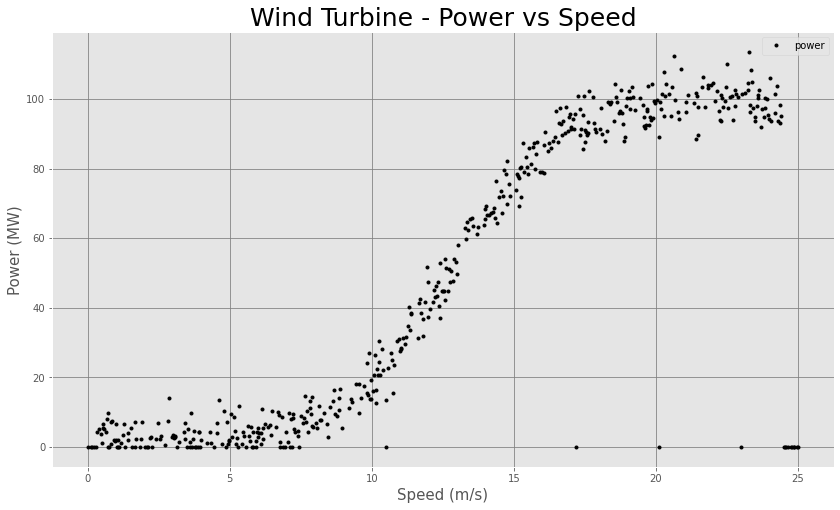

In [8]:
# Plot the values.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

From a quick observation of the data, we can see that the relationship between Power and Speed is in the shape of a sigmoid, where somewhere between about 7m/s and 17m/s wind speed is where the Power generated varies from <20MW to approximately 100MW. Outside the window of 7m/s to 17m/s there is relatively litte change with increasing or decreasiing wind speed.<br>
It is worth noting that there are a number of outliers showing where zero power is generated despite considerable wind speed being recorded. Because the Power in each of these outliers is exactly 0MW,it is assumed that there is some operational issue with the turbine and it is not working as per normal at these data points. This may be something worth notifying the turbine operator about. However, When modelling it would be worth pre-processing this data to ignore such obvious outliers, as these will skew any model trying to obtain normal operation modelling.

## 2. Pre process the data

From our above observation, we see there are outliers. For each of these outliers, the Power output is zero eventhough the wind speed is considerable. This is particularly noticeable at wind speeds ~>7.5m/s. It is important to deal with outliers prior to modelling or machine learning, as outliers certainly lead to more innacurate results.<br>
The outliers in this dataset are easy to identify from the above plot, hence we will deal wwith them in simple terms. However, with datasets of more than 2 variables, it is most often not as easy to identfy outliers from plotting. In these cases, using mathematical functions such as z-score or IQR score are required.[https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba).<br>
For the purpose of this assignment, we will assume a zero Power output corresponds to the turbine being turned off, so we will ignore these data points

In [9]:
# delete any rows from the dataset where a zero Power output is recorded
df = df[df.power != 0]
print('Number of rows remaining in dataset: %.d' % len(df))

Number of rows remaining in dataset: 451


<function matplotlib.pyplot.show(close=None, block=None)>

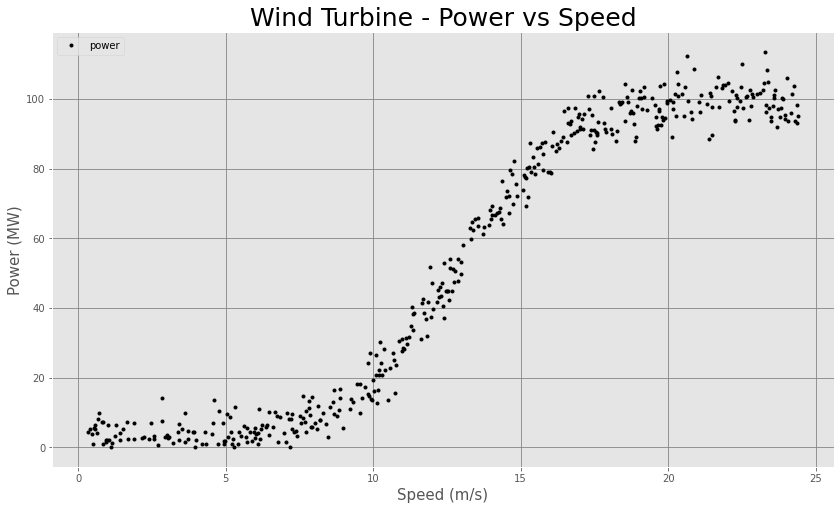

In [10]:
# Plot the values of the dataset with the outliers removed.
df.plot(x="speed", y="power", style='k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.show

## 3. Playing with polyfit function as a regression tool

By experimentation with the below polyfit function in numpy, a polynomial of degree 5 was found to best fit the data. [https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb](https://github.com/ianmcloughlin/jupyter-teaching-notebooks/blob/master/regression.ipynb).<br><br>
Below has the calculated coefficients and corresonding fitted line to the data.

In [11]:
# Select the columns of the DataFrame
Speed = df['speed']
Power = df["power"]

In [12]:
# Convert to arrays
x = Speed.to_numpy()
y = Power.to_numpy()

Now, we will use polyfit function in numpy to fit a a line to a set of stat using the least squares [https://en.wikipedia.org/wiki/Least_squares](https://en.wikipedia.org/wiki/Least_squares)

In [13]:
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html 
a, b, c, d, e, f = np.polyfit(x, y, 5) 
a, b, c, d, e, f

(0.00039630172192963434,
 -0.02523629166747932,
 0.5364697791523846,
 -4.104980455352897,
 11.155542997851406,
 -2.82537457777539)

These are the coefficients that will best fit the below equation in matching the dataset, as computed by the polyfit function in numpy

$$ y = a x^5 + bx^4 + cx^3 +dx^2 +ex + f $$

Plotting this on the same chart at the dataset, give us an idea of the accuracy of the polyfit

<function matplotlib.pyplot.show(close=None, block=None)>

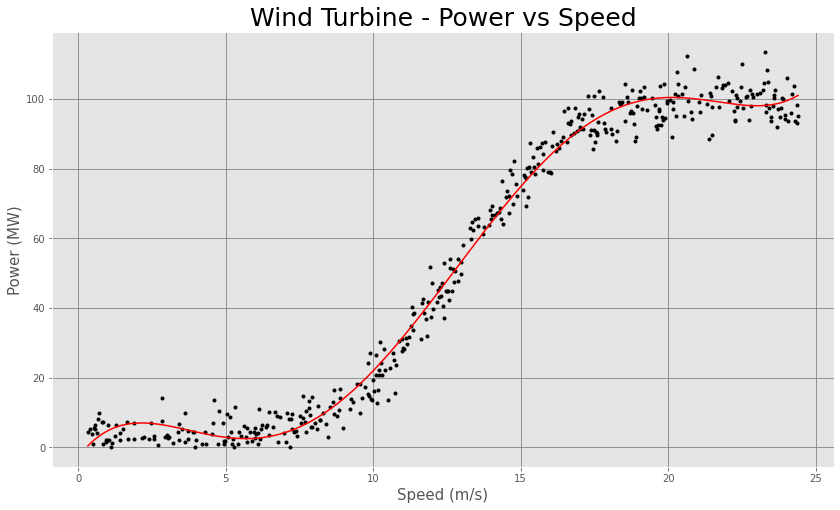

In [14]:
# Plot the values.
#df.plot(x="speed", y="power", style='k.')
plt.plot(x, y, 'k.')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
# Add the plot of the 5th degree polymomial along with the calculated coefficients from polyfit
plt.plot(x, a * x *x*x*x*x + b *x*x*x*x +c *x*x*x +d*x*x +e*x +f, 'r-')
plt.show

Visually, the line seems to track the data set quite well.<br>

## 4. Machine Learning using Scikit-Learn

We will now use scikit-learn to model and obtain the same results as above. The only difference bewteen below and above is that we will obtain the same results by use of scikit learn modelling rather than our own manual playing with the numpy polyfit function. Scikit-learn is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities. It provides dozens of built-in machine learning algorithms and models, called estimators. Each estimator can be fitted to some data using its fit method. [https://scikit-learn.org/](https://scikit-learn.org/)

### 4.1 Train the model

In [15]:
# Import required scikit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

When modelling a dataset, it is normal to divide the dataset into data that will be used for training/developing the model, and a test set of data that will be used for testing the model. Below, we will split the dataset so that two thirds of the data is used for training and one third is set aside for testing later. The train_test_split function in scikit learn allows us to randomly select test data from the full dataset. It is important that the test data is randomly taken from the dataset to ensure an accurate cross section of the dataset is contained within it.

In [16]:
# Prepare the dataset for training and testing
data = df.values
# split into inpiut and output elements
X, y = data[:, :-1], data[:, -1]
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

From section 3 above, we feel confident that a 5th degree polynomial will achieve a reasonable model. Prior to fitting the model, it is necessary to convert the X_train to a new matrix, X_Poly, which consists of all the polynomial combinations of features with degree=5. [https://towardsdatascience.com/machine-learning-basics-polynomial-regression-3f9dd30223d1](https://towardsdatascience.com/machine-learning-basics-polynomial-regression-3f9dd30223d1)

In [17]:
# fit the model using a 5th degree polynomial
poly_reg = PolynomialFeatures(degree = 5) 
X_poly = poly_reg.fit_transform(X_train)

Using the transformed X-train values and the corresponding y_train values, we will select a model of LinearRegession contained within sciit learn [https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). This uses the mathematical method of Ordinary Least Squares, which works to minimize the sum of the squares of the differences between the observed recorded y_train in the given dataset and those y values predicted by the linear function. [https://statisticsbyjim.com/glossary/ordinary-least-squares/](https://statisticsbyjim.com/glossary/ordinary-least-squares/)

In [18]:
model = LinearRegression()
model.fit(X_poly, y_train)

LinearRegression()

With the model developed, we will now plot the actual data against the the predicted data for the same input speed.

In [19]:
# Calculate the predicted y values from passing the given X_train values through the model
y_pred = model.predict(X_poly)

### 4.2 Analyse the model

<function matplotlib.pyplot.show(close=None, block=None)>

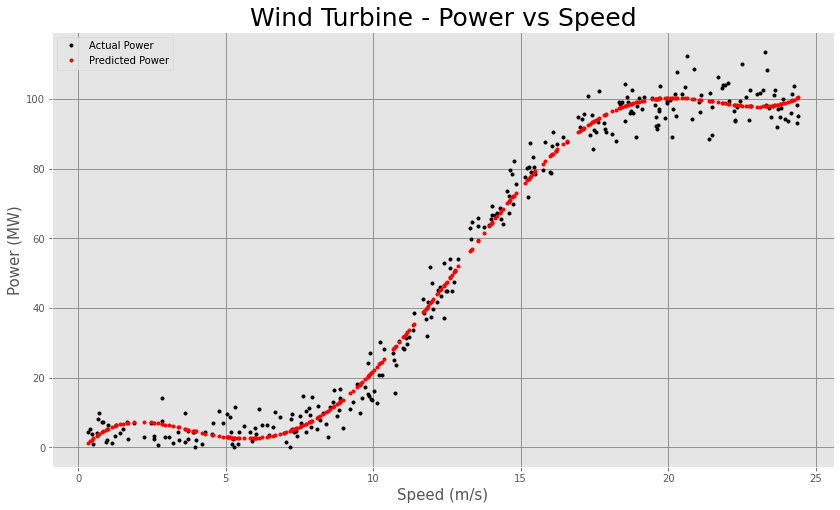

In [20]:
# Plot the results.
plt.plot(X_train, y_train, 'k.',label='Actual Power')
plt.plot(X_train, y_pred, 'r.',label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()
plt.show

Above shows the results of the training dataset compared to the actual training data results. However, this only shows the results of the model using the data that was used to train the model. This cannot be used as a measure of how good the model is. To properly test the model, we will use the test data extracted from the full dataset earlier and NOT used in the training of the model. This is the real test of how good the model is.

In [21]:
# Prepare the x data to be used in a polynomial of 5th degree
poly_reg = PolynomialFeatures(degree = 5) 
X_test_poly = poly_reg.fit_transform(X_test)

# Calculate the predicted y values from passing the given X_train values through the model
y_test_pred = model.predict(X_test_poly)

<function matplotlib.pyplot.show(close=None, block=None)>

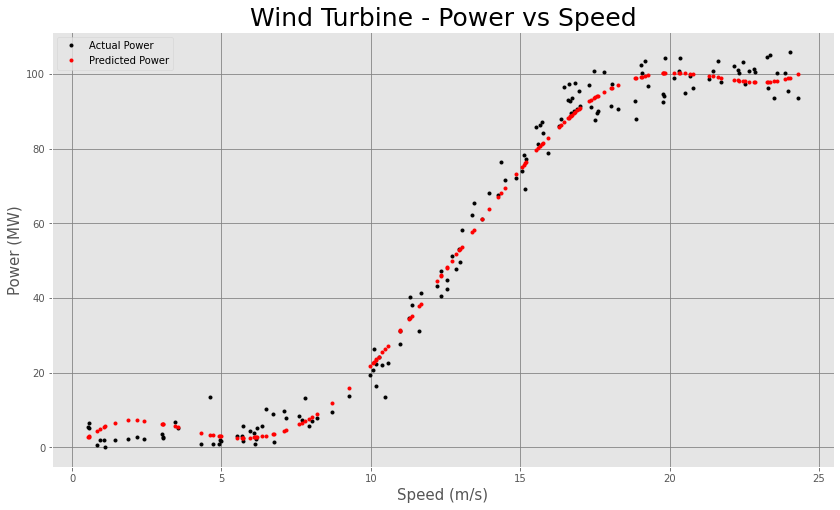

In [22]:
# Plot the results.
plt.plot(X_test, y_test, 'k.',label='Actual Power')
plt.plot(X_test, y_test_pred, 'r.',label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()
plt.show

From the chart, we can see the predicted Power (red dots) looks pretty accurate to the actual Power recorded (black dots). We can use some measures to understand how accurate the model is.

The relationship is measured with a value called the r-squared is used to measure the accuracy between the actual y test data and the model predicted y data. The r-squared value ranges from 0 to 1, where 0 means no correlation, and 1 means 100% correlation.[https://statisticsbyjim.com/regression/interpret-r-squared-regression/](https://statisticsbyjim.com/regression/interpret-r-squared-regression/)

In [23]:
from sklearn.metrics import r2_score
Rsquared = r2_score(y_test, y_test_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.98884


This R-squared value suggests a very accurate model

In [24]:
#Calculate the accuracy of the y predicted results with the y actual results for the test dataset
mae = mean_absolute_error(y_test, y_test_pred)
print('MAE: %.3fMW' % mae)

MAE: 3.487MW


In [25]:
from sklearn.metrics import max_error
max_error = max_error(y_test, y_test_pred)
print('Max error: %.3fMW' % max_error)

Max error: 12.870MW


Using the regression model above, we get a mean absolute error between the actual power output of the turbine and the predicted output power of 3.487MW, and a maximum eroor across the test dataset of 12.87MW

## 5. Machine Learning using Neural Networks

Whereas section 4 used traditional calculus of finding the coefficients of an equation to best fit a line to the set of data, there is another approach that has become popular with the advent of computers. The neural network approach involves starting out with an initial approximation of a model, looks at it's performance, and slowly changes certain parameters to refine the approximation. Over many hundred's of thousands of iterations of this technique, the initial model becomes more and more refined. Note, there is a lot of calculus involved in this approach also, but it just approaches the problem from a different perspective. After an initial model is built, and the first data passed through it, calculus is used to calculate the loss (How accurate the model is). [https://en.wikipedia.org/wiki/Gradient_descent](https://en.wikipedia.org/wiki/Gradient_descent). Then, using what is observed from this calculation, and algorithm is used to modify weights and biases contained within the neural network that should produce a more accurate model on the next iteration.   

We will now construct a neural network that will use machine learning to train a model to fit to the powerProduction dataset, which consists of 1 input (wind speed) and 1 output (Power). Therefore, our Neural network required for this is relatively simple, with no need for deep neural networks. <br>
Below, by varing certain characteristics, we will build 5 neural networks, apply the training data set to each network (running 5000 epochs), compare the predicted output Power values with the actual Power obtained for both the training dataset and the test dataset. The 5 conditions of network we will examine are outlined below: <br>

1. Hidden layer with 1 neuron, and default batch size of 1
2. Hidden layer with 1 neuron and batch size of 10
3. Hidden layer with 2 neurons and batch size of 10
4. Hidden layer with 3 neurons and batch siize of 10
5. Hidden layer with 5 neurons and batch size of 10<br><br>

We will compute the loss obtained on each experiment and compare accuracy results to see if we can find one model that stands out as being better than the others. We will also compare the accuracy of this Neural network approack to the above approach in section 4.

### 5.1 - Test model consisting of: 1 neuron, 5000 epochs, batch size=1

In [26]:
#Import tensorflow library required for Neural networks.
import tensorflow.keras as kr

The first neural network we will build and test, will consist of an input neuron, which will consist of our X_train values. This will be connected to 1 neuron in the hidden layer. As well as the value of the input, the connection will have a weight associated with it. This weight can vary between 0 and 1. The neuron in the hidden layer will have a bias (similar to a weight), which can also vary between 0 and 1. The input value to the hidden layer neuron is calculated by multiplying the x-value from the input neuron multiplied by the weight of the connection. To this value, the hidden layer bias is added and an activation function is applied to it to produce the output value from the hidden layer neuron. So, there are 3 different manipluations if the input x-value that can take place between leaving the input neuron and leaving the hidden layer neuron:<br>
1. x value is multiplied by w
2. b is added to (x*w)
3. a function is applied to (b + (x*W). ie $$ f(b +(x*w))$$<br>

The output value from the hidden layer neuron then experiences a weight manipulation from the connection layer between the hidden layer and the output layer, and that output layer applies it's bias and it's actiivation function to the incoming value. Therfore, the input x value has 2 rounds of f, b and w being applied to it by the time it beomces the output of the network, or

$$ y = f_{1}(b_{1} +(x*w_{1})) + f_{2}(b_{2} +(x*w_{2})) $$
<br>

This is the case for 1 hidden layer consisting of 1 neuron. In later examples we will be adding neurons. In these cases, the above can be expressed as

$$ y = \sum\limits_{i=1}^n f_{i}(b_{i} +(x*w_{i}))$$

![1-neuron](Images/1-neuron.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Below explains the deatils of each line in the building of a model in keras. There is a lot of details contained within each line. It is very important to understand these details, as these are what deterimine if your model works and how acurate it is, so please read the comments.

In [27]:
# Build a model using Keras
model = kr.models.Sequential()

# Add a layer with 1 neuron, 1 input (wind speed), using the sigmoid activation function applied to each neuron. 
# Initialise weights and bias with Glorot_uniform. This Draws samples from a uniform distribution within [-limit, limit], 
# where limit = sqrt(6 / (fan_in + fan_out)) (fan_in is the number of input units in the weight tensor and fan_out is the 
# number of output units).https://www.tensorflow.org/api_docs/python/tf/keras/initializers/GlorotUniform
model.add(kr.layers.Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Add a layer for the output neuron (Power), using 1 neuron, a linear activation function and, again, glorot_uniform 
# initialisers. Note, we use a linear activation function in this last layer, as we know power outputs are >1, which is the 
# approx the maximum we would obtain if we used a sigmoid activation function at this layer.
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))

# Compile the model using the above defined neural network, calculating the loss after each epoch using "mean_squared_error"
# method, and applying the Optimizer that implements the Adam algorithm used to affect small changes to weights and baises,
# based on the loss calculated after each eopch.https://keras.io/api/optimizers/adam/
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

Note: The running of the below neural networks takes considerable time. Please be aware of this and patient if run

In [28]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 1 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=1)

Epoch 1/5000
302/302 [==============================] - 1s 735us/step - loss: 3996.7403
Epoch 2/5000
302/302 [==============================] - 0s 716us/step - loss: 4287.0703
Epoch 3/5000
302/302 [==============================] - 0s 749us/step - loss: 4617.8607
Epoch 4/5000
302/302 [==============================] - 0s 744us/step - loss: 3920.6533
Epoch 5/5000
302/302 [==============================] - 0s 880us/step - loss: 3957.0673
Epoch 6/5000
302/302 [==============================] - 0s 864us/step - loss: 4343.3134
Epoch 7/5000
302/302 [==============================] - 0s 717us/step - loss: 3594.7099
Epoch 8/5000
302/302 [==============================] - 0s 714us/step - loss: 4169.8897
Epoch 9/5000
302/302 [==============================] - 0s 694us/step - loss: 4260.0872
Epoch 10/5000
302/302 [==============================] - 0s 773us/step - loss: 3863.1301
Epoch 11/5000
302/302 [==============================] - 0s 976us/step - loss: 3742.8454
Epoch 12/5000
302/302 [=======

302/302 [==============================] - 0s 857us/step - loss: 2561.6966
Epoch 94/5000
302/302 [==============================] - 0s 693us/step - loss: 2713.8268
Epoch 95/5000
302/302 [==============================] - 0s 714us/step - loss: 2265.2487
Epoch 96/5000
302/302 [==============================] - 0s 803us/step - loss: 2544.6957
Epoch 97/5000
302/302 [==============================] - 0s 951us/step - loss: 2491.6999
Epoch 98/5000
302/302 [==============================] - 0s 787us/step - loss: 2609.0677
Epoch 99/5000
302/302 [==============================] - 0s 690us/step - loss: 2542.2197
Epoch 100/5000
302/302 [==============================] - 0s 710us/step - loss: 2506.0307
Epoch 101/5000
302/302 [==============================] - 0s 725us/step - loss: 2260.3756
Epoch 102/5000
302/302 [==============================] - 0s 948us/step - loss: 2343.1507
Epoch 103/5000
302/302 [==============================] - 0s 981us/step - loss: 2332.0557
Epoch 104/5000
302/302 [=======

302/302 [==============================] - 0s 712us/step - loss: 1665.85620s - loss: 1674.01
Epoch 185/5000
302/302 [==============================] - 0s 737us/step - loss: 1679.5381
Epoch 186/5000
302/302 [==============================] - 0s 744us/step - loss: 1480.8538
Epoch 187/5000
302/302 [==============================] - 0s 685us/step - loss: 1532.3674
Epoch 188/5000
302/302 [==============================] - 0s 705us/step - loss: 1441.9573
Epoch 189/5000
302/302 [==============================] - 0s 705us/step - loss: 1461.3100
Epoch 190/5000
302/302 [==============================] - 0s 695us/step - loss: 1235.9483
Epoch 191/5000
302/302 [==============================] - 0s 697us/step - loss: 1579.4816
Epoch 192/5000
302/302 [==============================] - 0s 683us/step - loss: 1359.2017
Epoch 193/5000
302/302 [==============================] - 0s 667us/step - loss: 1417.7235
Epoch 194/5000
302/302 [==============================] - 0s 721us/step - loss: 1342.8395
Epoch 1

302/302 [==============================] - 0s 699us/step - loss: 848.6414
Epoch 276/5000
302/302 [==============================] - 0s 697us/step - loss: 897.6823
Epoch 277/5000
302/302 [==============================] - 0s 715us/step - loss: 867.5640
Epoch 278/5000
302/302 [==============================] - 0s 696us/step - loss: 895.2999
Epoch 279/5000
302/302 [==============================] - 0s 692us/step - loss: 830.1551
Epoch 280/5000
302/302 [==============================] - 0s 716us/step - loss: 807.6646
Epoch 281/5000
302/302 [==============================] - 0s 685us/step - loss: 851.3156
Epoch 282/5000
302/302 [==============================] - 0s 715us/step - loss: 746.4349
Epoch 283/5000
302/302 [==============================] - 0s 710us/step - loss: 812.8321
Epoch 284/5000
302/302 [==============================] - 0s 707us/step - loss: 785.6169
Epoch 285/5000
302/302 [==============================] - 0s 704us/step - loss: 688.0507
Epoch 286/5000
302/302 [============

302/302 [==============================] - 0s 702us/step - loss: 393.7014
Epoch 368/5000
302/302 [==============================] - 0s 683us/step - loss: 396.9124
Epoch 369/5000
302/302 [==============================] - 0s 712us/step - loss: 412.6052
Epoch 370/5000
302/302 [==============================] - 0s 687us/step - loss: 352.4677
Epoch 371/5000
302/302 [==============================] - 0s 686us/step - loss: 364.7411
Epoch 372/5000
302/302 [==============================] - 0s 695us/step - loss: 361.2809
Epoch 373/5000
302/302 [==============================] - 0s 696us/step - loss: 394.8427
Epoch 374/5000
302/302 [==============================] - 0s 697us/step - loss: 401.1203
Epoch 375/5000
302/302 [==============================] - 0s 714us/step - loss: 375.2539
Epoch 376/5000
302/302 [==============================] - 0s 703us/step - loss: 347.6713
Epoch 377/5000
302/302 [==============================] - 0s 684us/step - loss: 343.0101
Epoch 378/5000
302/302 [============

302/302 [==============================] - 0s 701us/step - loss: 169.6018
Epoch 460/5000
302/302 [==============================] - 0s 693us/step - loss: 169.6709
Epoch 461/5000
302/302 [==============================] - 0s 680us/step - loss: 156.4270
Epoch 462/5000
302/302 [==============================] - 0s 688us/step - loss: 161.7537
Epoch 463/5000
302/302 [==============================] - 0s 699us/step - loss: 149.6438
Epoch 464/5000
302/302 [==============================] - 0s 699us/step - loss: 165.2506
Epoch 465/5000
302/302 [==============================] - 0s 721us/step - loss: 168.8347
Epoch 466/5000
302/302 [==============================] - 0s 686us/step - loss: 146.6431
Epoch 467/5000
302/302 [==============================] - 0s 673us/step - loss: 137.8822
Epoch 468/5000
302/302 [==============================] - 0s 706us/step - loss: 163.0767
Epoch 469/5000
302/302 [==============================] - 0s 718us/step - loss: 159.2321
Epoch 470/5000
302/302 [============

302/302 [==============================] - 0s 712us/step - loss: 84.9459
Epoch 552/5000
302/302 [==============================] - 0s 679us/step - loss: 71.3906
Epoch 553/5000
302/302 [==============================] - 0s 695us/step - loss: 84.3568
Epoch 554/5000
302/302 [==============================] - 0s 692us/step - loss: 73.1700
Epoch 555/5000
302/302 [==============================] - 0s 697us/step - loss: 59.0504
Epoch 556/5000
302/302 [==============================] - 0s 690us/step - loss: 66.4481
Epoch 557/5000
302/302 [==============================] - 0s 692us/step - loss: 59.7295
Epoch 558/5000
302/302 [==============================] - 0s 712us/step - loss: 64.2159
Epoch 559/5000
302/302 [==============================] - 0s 697us/step - loss: 74.5473
Epoch 560/5000
302/302 [==============================] - 0s 695us/step - loss: 64.9583
Epoch 561/5000
302/302 [==============================] - 0s 688us/step - loss: 65.7923
Epoch 562/5000
302/302 [=======================

302/302 [==============================] - 0s 700us/step - loss: 41.0704
Epoch 645/5000
302/302 [==============================] - 0s 718us/step - loss: 41.0452
Epoch 646/5000
302/302 [==============================] - 0s 690us/step - loss: 41.1511
Epoch 647/5000
302/302 [==============================] - 0s 694us/step - loss: 46.0624
Epoch 648/5000
302/302 [==============================] - 0s 693us/step - loss: 42.1201
Epoch 649/5000
302/302 [==============================] - 0s 694us/step - loss: 43.4988
Epoch 650/5000
302/302 [==============================] - 0s 757us/step - loss: 48.6407
Epoch 651/5000
302/302 [==============================] - 0s 702us/step - loss: 35.0749
Epoch 652/5000
302/302 [==============================] - 0s 688us/step - loss: 40.2326
Epoch 653/5000
302/302 [==============================] - 0s 694us/step - loss: 40.7221
Epoch 654/5000
302/302 [==============================] - 0s 711us/step - loss: 38.4265
Epoch 655/5000
302/302 [=======================

302/302 [==============================] - 0s 709us/step - loss: 35.7163
Epoch 738/5000
302/302 [==============================] - 0s 688us/step - loss: 29.73510s - loss: 28.
Epoch 739/5000
302/302 [==============================] - 0s 693us/step - loss: 34.8568
Epoch 740/5000
302/302 [==============================] - 0s 698us/step - loss: 33.1171
Epoch 741/5000
302/302 [==============================] - 0s 683us/step - loss: 32.8780
Epoch 742/5000
302/302 [==============================] - 0s 717us/step - loss: 42.4252
Epoch 743/5000
302/302 [==============================] - 0s 699us/step - loss: 30.9060
Epoch 744/5000
302/302 [==============================] - 0s 680us/step - loss: 30.8776
Epoch 745/5000
302/302 [==============================] - 0s 683us/step - loss: 35.6465
Epoch 746/5000
302/302 [==============================] - 0s 707us/step - loss: 29.9524
Epoch 747/5000
302/302 [==============================] - 0s 706us/step - loss: 25.5373
Epoch 748/5000
302/302 [=========

302/302 [==============================] - 0s 703us/step - loss: 30.9335
Epoch 831/5000
302/302 [==============================] - 0s 691us/step - loss: 28.9459
Epoch 832/5000
302/302 [==============================] - 0s 680us/step - loss: 26.3737
Epoch 833/5000
302/302 [==============================] - 0s 693us/step - loss: 30.8964
Epoch 834/5000
302/302 [==============================] - 0s 721us/step - loss: 29.7503
Epoch 835/5000
302/302 [==============================] - 0s 700us/step - loss: 24.4652
Epoch 836/5000
302/302 [==============================] - 0s 693us/step - loss: 32.6007
Epoch 837/5000
302/302 [==============================] - 0s 691us/step - loss: 27.7768
Epoch 838/5000
302/302 [==============================] - 0s 685us/step - loss: 25.3573
Epoch 839/5000
302/302 [==============================] - 0s 720us/step - loss: 24.7241
Epoch 840/5000
302/302 [==============================] - 0s 698us/step - loss: 27.3894
Epoch 841/5000
302/302 [=======================

302/302 [==============================] - 0s 699us/step - loss: 20.0945
Epoch 924/5000
302/302 [==============================] - 0s 691us/step - loss: 20.4294
Epoch 925/5000
302/302 [==============================] - 0s 699us/step - loss: 21.6917
Epoch 926/5000
302/302 [==============================] - 0s 704us/step - loss: 25.2166
Epoch 927/5000
302/302 [==============================] - 0s 695us/step - loss: 20.2405
Epoch 928/5000
302/302 [==============================] - 0s 676us/step - loss: 22.0404
Epoch 929/5000
302/302 [==============================] - 0s 704us/step - loss: 16.5960
Epoch 930/5000
302/302 [==============================] - 0s 708us/step - loss: 21.9150
Epoch 931/5000
302/302 [==============================] - 0s 700us/step - loss: 27.1048
Epoch 932/5000
302/302 [==============================] - 0s 677us/step - loss: 21.7859
Epoch 933/5000
302/302 [==============================] - 0s 708us/step - loss: 22.8494
Epoch 934/5000
302/302 [=======================

Epoch 1016/5000
302/302 [==============================] - 0s 718us/step - loss: 18.6950
Epoch 1017/5000
302/302 [==============================] - 0s 669us/step - loss: 21.6026
Epoch 1018/5000
302/302 [==============================] - 0s 689us/step - loss: 17.6820
Epoch 1019/5000
302/302 [==============================] - 0s 692us/step - loss: 21.6098
Epoch 1020/5000
302/302 [==============================] - 0s 685us/step - loss: 21.8254
Epoch 1021/5000
302/302 [==============================] - 0s 715us/step - loss: 21.8084
Epoch 1022/5000
302/302 [==============================] - 0s 685us/step - loss: 19.2949
Epoch 1023/5000
302/302 [==============================] - 0s 689us/step - loss: 20.8754
Epoch 1024/5000
302/302 [==============================] - 0s 698us/step - loss: 21.6917
Epoch 1025/5000
302/302 [==============================] - 0s 684us/step - loss: 18.9034
Epoch 1026/5000
302/302 [==============================] - 0s 698us/step - loss: 17.3674
Epoch 1027/5000
302/3

302/302 [==============================] - 0s 716us/step - loss: 19.5867
Epoch 1109/5000
302/302 [==============================] - 0s 689us/step - loss: 18.7059
Epoch 1110/5000
302/302 [==============================] - 0s 684us/step - loss: 17.4151
Epoch 1111/5000
302/302 [==============================] - 0s 705us/step - loss: 18.6759
Epoch 1112/5000
302/302 [==============================] - 0s 691us/step - loss: 17.5498
Epoch 1113/5000
302/302 [==============================] - 0s 691us/step - loss: 16.8075
Epoch 1114/5000
302/302 [==============================] - 0s 683us/step - loss: 15.8732
Epoch 1115/5000
302/302 [==============================] - 0s 692us/step - loss: 20.9894
Epoch 1116/5000
302/302 [==============================] - 0s 712us/step - loss: 21.2647
Epoch 1117/5000
302/302 [==============================] - 0s 693us/step - loss: 19.1378
Epoch 1118/5000
302/302 [==============================] - 0s 698us/step - loss: 20.2854
Epoch 1119/5000
302/302 [============

302/302 [==============================] - 0s 684us/step - loss: 19.43620s - loss: 19.
Epoch 1201/5000
302/302 [==============================] - 0s 712us/step - loss: 19.0460
Epoch 1202/5000
302/302 [==============================] - 0s 699us/step - loss: 16.2480
Epoch 1203/5000
302/302 [==============================] - 0s 714us/step - loss: 17.6410
Epoch 1204/5000
302/302 [==============================] - 0s 697us/step - loss: 16.2692
Epoch 1205/5000
302/302 [==============================] - 0s 688us/step - loss: 16.3580
Epoch 1206/5000
302/302 [==============================] - 0s 702us/step - loss: 18.9800
Epoch 1207/5000
302/302 [==============================] - 0s 696us/step - loss: 17.9312
Epoch 1208/5000
302/302 [==============================] - 0s 695us/step - loss: 16.1775
Epoch 1209/5000
302/302 [==============================] - 0s 698us/step - loss: 20.1938
Epoch 1210/5000
302/302 [==============================] - 0s 679us/step - loss: 16.9982
Epoch 1211/5000
302/302

302/302 [==============================] - 0s 699us/step - loss: 18.9494
Epoch 1293/5000
302/302 [==============================] - 0s 702us/step - loss: 18.3855
Epoch 1294/5000
302/302 [==============================] - 0s 716us/step - loss: 18.9829
Epoch 1295/5000
302/302 [==============================] - 0s 687us/step - loss: 17.02660s - loss: 16.99
Epoch 1296/5000
302/302 [==============================] - 0s 693us/step - loss: 19.5305
Epoch 1297/5000
302/302 [==============================] - 0s 688us/step - loss: 19.5465
Epoch 1298/5000
302/302 [==============================] - 0s 708us/step - loss: 19.3133
Epoch 1299/5000
302/302 [==============================] - 0s 691us/step - loss: 17.6152
Epoch 1300/5000
302/302 [==============================] - 0s 691us/step - loss: 18.8842
Epoch 1301/5000
302/302 [==============================] - 0s 687us/step - loss: 18.8807
Epoch 1302/5000
302/302 [==============================] - 0s 703us/step - loss: 19.0709
Epoch 1303/5000
302/3

302/302 [==============================] - 0s 687us/step - loss: 19.7015
Epoch 1385/5000
302/302 [==============================] - 0s 696us/step - loss: 19.6824
Epoch 1386/5000
302/302 [==============================] - 0s 732us/step - loss: 15.4349
Epoch 1387/5000
302/302 [==============================] - 0s 701us/step - loss: 19.5609
Epoch 1388/5000
302/302 [==============================] - 0s 695us/step - loss: 19.0498
Epoch 1389/5000
302/302 [==============================] - 0s 719us/step - loss: 19.3804
Epoch 1390/5000
302/302 [==============================] - 0s 715us/step - loss: 18.3141
Epoch 1391/5000
302/302 [==============================] - 0s 694us/step - loss: 20.0302
Epoch 1392/5000
302/302 [==============================] - 0s 689us/step - loss: 17.5355
Epoch 1393/5000
302/302 [==============================] - 0s 697us/step - loss: 16.8408
Epoch 1394/5000
302/302 [==============================] - 0s 710us/step - loss: 19.2736
Epoch 1395/5000
302/302 [============

302/302 [==============================] - 0s 689us/step - loss: 17.3140
Epoch 1477/5000
302/302 [==============================] - 0s 710us/step - loss: 18.7896
Epoch 1478/5000
302/302 [==============================] - 0s 702us/step - loss: 19.3633
Epoch 1479/5000
302/302 [==============================] - 0s 695us/step - loss: 18.8380
Epoch 1480/5000
302/302 [==============================] - 0s 701us/step - loss: 19.9939
Epoch 1481/5000
302/302 [==============================] - 0s 684us/step - loss: 18.2769
Epoch 1482/5000
302/302 [==============================] - 0s 712us/step - loss: 20.6633
Epoch 1483/5000
302/302 [==============================] - 0s 728us/step - loss: 18.7181
Epoch 1484/5000
302/302 [==============================] - 0s 684us/step - loss: 17.5475
Epoch 1485/5000
302/302 [==============================] - 0s 692us/step - loss: 17.3535
Epoch 1486/5000
302/302 [==============================] - 0s 692us/step - loss: 17.0156
Epoch 1487/5000
302/302 [============

302/302 [==============================] - 0s 705us/step - loss: 17.5114
Epoch 1568/5000
302/302 [==============================] - 0s 690us/step - loss: 16.7327
Epoch 1569/5000
302/302 [==============================] - 0s 715us/step - loss: 19.5871
Epoch 1570/5000
302/302 [==============================] - 0s 690us/step - loss: 19.7661
Epoch 1571/5000
302/302 [==============================] - 0s 706us/step - loss: 18.4608
Epoch 1572/5000
302/302 [==============================] - 0s 688us/step - loss: 18.5047
Epoch 1573/5000
302/302 [==============================] - 0s 688us/step - loss: 17.3563
Epoch 1574/5000
302/302 [==============================] - 0s 704us/step - loss: 19.0503
Epoch 1575/5000
302/302 [==============================] - 0s 691us/step - loss: 16.6137
Epoch 1576/5000
302/302 [==============================] - 0s 702us/step - loss: 16.9551
Epoch 1577/5000
302/302 [==============================] - 0s 681us/step - loss: 19.2313
Epoch 1578/5000
302/302 [============

302/302 [==============================] - 0s 702us/step - loss: 17.1616
Epoch 1660/5000
302/302 [==============================] - 0s 713us/step - loss: 15.8308
Epoch 1661/5000
302/302 [==============================] - 0s 706us/step - loss: 19.4779
Epoch 1662/5000
302/302 [==============================] - 0s 690us/step - loss: 19.4360
Epoch 1663/5000
302/302 [==============================] - 0s 683us/step - loss: 18.2528
Epoch 1664/5000
302/302 [==============================] - 0s 695us/step - loss: 20.7629
Epoch 1665/5000
302/302 [==============================] - 0s 705us/step - loss: 15.6800
Epoch 1666/5000
302/302 [==============================] - 0s 688us/step - loss: 16.6209
Epoch 1667/5000
302/302 [==============================] - 0s 695us/step - loss: 18.4406
Epoch 1668/5000
302/302 [==============================] - 0s 697us/step - loss: 17.6906
Epoch 1669/5000
302/302 [==============================] - 0s 695us/step - loss: 18.6142
Epoch 1670/5000
302/302 [============

Epoch 1751/5000
302/302 [==============================] - 0s 704us/step - loss: 21.7292
Epoch 1752/5000
302/302 [==============================] - 0s 688us/step - loss: 17.6773
Epoch 1753/5000
302/302 [==============================] - 0s 673us/step - loss: 20.5249
Epoch 1754/5000
302/302 [==============================] - 0s 699us/step - loss: 17.8849
Epoch 1755/5000
302/302 [==============================] - 0s 710us/step - loss: 20.0561
Epoch 1756/5000
302/302 [==============================] - 0s 685us/step - loss: 16.9050
Epoch 1757/5000
302/302 [==============================] - 0s 691us/step - loss: 16.6310
Epoch 1758/5000
302/302 [==============================] - 0s 675us/step - loss: 20.7350
Epoch 1759/5000
302/302 [==============================] - 0s 701us/step - loss: 18.1912
Epoch 1760/5000
302/302 [==============================] - 0s 707us/step - loss: 16.8260
Epoch 1761/5000
302/302 [==============================] - 0s 688us/step - loss: 16.8595
Epoch 1762/5000
302/3

302/302 [==============================] - 0s 708us/step - loss: 20.3961
Epoch 1843/5000
302/302 [==============================] - 0s 703us/step - loss: 17.1209
Epoch 1844/5000
302/302 [==============================] - 0s 684us/step - loss: 18.7767
Epoch 1845/5000
302/302 [==============================] - 0s 677us/step - loss: 21.2709
Epoch 1846/5000
302/302 [==============================] - 0s 690us/step - loss: 18.6818
Epoch 1847/5000
302/302 [==============================] - 0s 676us/step - loss: 18.8822
Epoch 1848/5000
302/302 [==============================] - 0s 721us/step - loss: 16.1181
Epoch 1849/5000
302/302 [==============================] - 0s 695us/step - loss: 20.2780
Epoch 1850/5000
302/302 [==============================] - 0s 682us/step - loss: 18.2736
Epoch 1851/5000
302/302 [==============================] - 0s 702us/step - loss: 19.9886
Epoch 1852/5000
302/302 [==============================] - 0s 677us/step - loss: 17.5429
Epoch 1853/5000
302/302 [============

302/302 [==============================] - 0s 726us/step - loss: 19.0426
Epoch 1935/5000
302/302 [==============================] - 0s 700us/step - loss: 21.2035
Epoch 1936/5000
302/302 [==============================] - 0s 685us/step - loss: 15.8763
Epoch 1937/5000
302/302 [==============================] - 0s 703us/step - loss: 18.50750s - loss: 18.
Epoch 1938/5000
302/302 [==============================] - 0s 682us/step - loss: 16.8085
Epoch 1939/5000
302/302 [==============================] - 0s 682us/step - loss: 16.6283
Epoch 1940/5000
302/302 [==============================] - 0s 698us/step - loss: 20.1697
Epoch 1941/5000
302/302 [==============================] - 0s 685us/step - loss: 15.2083
Epoch 1942/5000
302/302 [==============================] - 0s 702us/step - loss: 16.1486
Epoch 1943/5000
302/302 [==============================] - 0s 685us/step - loss: 19.5496
Epoch 1944/5000
302/302 [==============================] - 0s 688us/step - loss: 16.1556
Epoch 1945/5000
302/302

Epoch 2026/5000
302/302 [==============================] - 0s 676us/step - loss: 17.5862
Epoch 2027/5000
302/302 [==============================] - 0s 694us/step - loss: 19.3706
Epoch 2028/5000
302/302 [==============================] - 0s 694us/step - loss: 17.5654
Epoch 2029/5000
302/302 [==============================] - 0s 714us/step - loss: 16.4352
Epoch 2030/5000
302/302 [==============================] - 0s 687us/step - loss: 18.2218
Epoch 2031/5000
302/302 [==============================] - 0s 692us/step - loss: 16.9743
Epoch 2032/5000
302/302 [==============================] - 0s 691us/step - loss: 15.9850
Epoch 2033/5000
302/302 [==============================] - 0s 706us/step - loss: 16.9937
Epoch 2034/5000
302/302 [==============================] - 0s 690us/step - loss: 18.8616
Epoch 2035/5000
302/302 [==============================] - 0s 683us/step - loss: 21.5141
Epoch 2036/5000
302/302 [==============================] - 0s 697us/step - loss: 19.9385
Epoch 2037/5000
302/3

302/302 [==============================] - 0s 692us/step - loss: 17.6190
Epoch 2119/5000
302/302 [==============================] - 0s 688us/step - loss: 18.3382
Epoch 2120/5000
302/302 [==============================] - 0s 705us/step - loss: 22.3057
Epoch 2121/5000
302/302 [==============================] - 0s 691us/step - loss: 19.2186
Epoch 2122/5000
302/302 [==============================] - 0s 671us/step - loss: 15.3025
Epoch 2123/5000
302/302 [==============================] - 0s 696us/step - loss: 17.7266
Epoch 2124/5000
302/302 [==============================] - 0s 735us/step - loss: 20.2933
Epoch 2125/5000
302/302 [==============================] - 0s 707us/step - loss: 16.3349
Epoch 2126/5000
302/302 [==============================] - 0s 685us/step - loss: 17.5340
Epoch 2127/5000
302/302 [==============================] - 0s 689us/step - loss: 17.8059
Epoch 2128/5000
302/302 [==============================] - 0s 686us/step - loss: 15.8342
Epoch 2129/5000
302/302 [============

302/302 [==============================] - 0s 691us/step - loss: 18.6255
Epoch 2210/5000
302/302 [==============================] - 0s 699us/step - loss: 20.7444
Epoch 2211/5000
302/302 [==============================] - 0s 700us/step - loss: 15.7122
Epoch 2212/5000
302/302 [==============================] - 0s 691us/step - loss: 14.6291
Epoch 2213/5000
302/302 [==============================] - 0s 687us/step - loss: 19.2668
Epoch 2214/5000
302/302 [==============================] - 0s 698us/step - loss: 18.6579
Epoch 2215/5000
302/302 [==============================] - 0s 687us/step - loss: 19.5011
Epoch 2216/5000
302/302 [==============================] - 0s 690us/step - loss: 18.4054
Epoch 2217/5000
302/302 [==============================] - 0s 719us/step - loss: 17.6001
Epoch 2218/5000
302/302 [==============================] - 0s 701us/step - loss: 16.8195
Epoch 2219/5000
302/302 [==============================] - 0s 697us/step - loss: 23.4768
Epoch 2220/5000
302/302 [============

302/302 [==============================] - 0s 708us/step - loss: 17.1475
Epoch 2302/5000
302/302 [==============================] - 0s 724us/step - loss: 18.6652
Epoch 2303/5000
302/302 [==============================] - 0s 693us/step - loss: 17.9970
Epoch 2304/5000
302/302 [==============================] - 0s 797us/step - loss: 20.4485
Epoch 2305/5000
302/302 [==============================] - 0s 874us/step - loss: 23.5598
Epoch 2306/5000
302/302 [==============================] - 0s 876us/step - loss: 14.7768
Epoch 2307/5000
302/302 [==============================] - 0s 789us/step - loss: 19.2521
Epoch 2308/5000
302/302 [==============================] - 0s 770us/step - loss: 15.3715
Epoch 2309/5000
302/302 [==============================] - 0s 700us/step - loss: 15.8115
Epoch 2310/5000
302/302 [==============================] - 0s 734us/step - loss: 17.6622
Epoch 2311/5000
302/302 [==============================] - 0s 730us/step - loss: 18.6769
Epoch 2312/5000
302/302 [============

302/302 [==============================] - 0s 697us/step - loss: 18.1522
Epoch 2393/5000
302/302 [==============================] - 0s 676us/step - loss: 17.3239
Epoch 2394/5000
302/302 [==============================] - 0s 690us/step - loss: 18.7293
Epoch 2395/5000
302/302 [==============================] - 0s 669us/step - loss: 18.6008
Epoch 2396/5000
302/302 [==============================] - 0s 692us/step - loss: 19.6993
Epoch 2397/5000
302/302 [==============================] - 0s 681us/step - loss: 21.2177
Epoch 2398/5000
302/302 [==============================] - 0s 676us/step - loss: 14.9287
Epoch 2399/5000
302/302 [==============================] - 0s 682us/step - loss: 17.4441
Epoch 2400/5000
302/302 [==============================] - 0s 712us/step - loss: 16.9974
Epoch 2401/5000
302/302 [==============================] - 0s 703us/step - loss: 19.0577
Epoch 2402/5000
302/302 [==============================] - 0s 694us/step - loss: 15.7639
Epoch 2403/5000
302/302 [============

302/302 [==============================] - 0s 687us/step - loss: 18.7789
Epoch 2484/5000
302/302 [==============================] - 0s 696us/step - loss: 16.9993
Epoch 2485/5000
302/302 [==============================] - 0s 678us/step - loss: 16.0247
Epoch 2486/5000
302/302 [==============================] - 0s 705us/step - loss: 18.3922
Epoch 2487/5000
302/302 [==============================] - 0s 692us/step - loss: 17.58160s - loss: 17.55
Epoch 2488/5000
302/302 [==============================] - 0s 675us/step - loss: 17.1457
Epoch 2489/5000
302/302 [==============================] - 0s 686us/step - loss: 15.5756
Epoch 2490/5000
302/302 [==============================] - 0s 668us/step - loss: 18.6556
Epoch 2491/5000
302/302 [==============================] - 0s 691us/step - loss: 17.9338
Epoch 2492/5000
302/302 [==============================] - 0s 677us/step - loss: 16.3251
Epoch 2493/5000
302/302 [==============================] - 0s 686us/step - loss: 21.9077
Epoch 2494/5000
302/3

302/302 [==============================] - 0s 681us/step - loss: 16.9633
Epoch 2575/5000
302/302 [==============================] - 0s 691us/step - loss: 19.1163
Epoch 2576/5000
302/302 [==============================] - 0s 746us/step - loss: 16.6653
Epoch 2577/5000
302/302 [==============================] - 0s 712us/step - loss: 18.0439
Epoch 2578/5000
302/302 [==============================] - 0s 689us/step - loss: 21.2123
Epoch 2579/5000
302/302 [==============================] - 0s 691us/step - loss: 19.3917
Epoch 2580/5000
302/302 [==============================] - 0s 681us/step - loss: 17.6755
Epoch 2581/5000
302/302 [==============================] - 0s 697us/step - loss: 19.3223
Epoch 2582/5000
302/302 [==============================] - 0s 689us/step - loss: 18.5323
Epoch 2583/5000
302/302 [==============================] - 0s 675us/step - loss: 17.9338
Epoch 2584/5000
302/302 [==============================] - 0s 699us/step - loss: 19.8835
Epoch 2585/5000
302/302 [============

302/302 [==============================] - 0s 684us/step - loss: 18.8491
Epoch 2667/5000
302/302 [==============================] - 0s 698us/step - loss: 19.1697
Epoch 2668/5000
302/302 [==============================] - 0s 708us/step - loss: 18.0006
Epoch 2669/5000
302/302 [==============================] - 0s 700us/step - loss: 16.5554
Epoch 2670/5000
302/302 [==============================] - 0s 682us/step - loss: 15.3570
Epoch 2671/5000
302/302 [==============================] - 0s 689us/step - loss: 16.8417
Epoch 2672/5000
302/302 [==============================] - 0s 683us/step - loss: 16.6246
Epoch 2673/5000
302/302 [==============================] - 0s 690us/step - loss: 20.4437
Epoch 2674/5000
302/302 [==============================] - 0s 712us/step - loss: 16.6034
Epoch 2675/5000
302/302 [==============================] - 0s 681us/step - loss: 19.1512
Epoch 2676/5000
302/302 [==============================] - 0s 687us/step - loss: 17.2197
Epoch 2677/5000
302/302 [============

302/302 [==============================] - 0s 692us/step - loss: 17.2081
Epoch 2759/5000
302/302 [==============================] - 0s 729us/step - loss: 17.5099
Epoch 2760/5000
302/302 [==============================] - 0s 694us/step - loss: 20.4658
Epoch 2761/5000
302/302 [==============================] - 0s 689us/step - loss: 19.2939
Epoch 2762/5000
302/302 [==============================] - 0s 674us/step - loss: 20.4114
Epoch 2763/5000
302/302 [==============================] - 0s 690us/step - loss: 19.1070
Epoch 2764/5000
302/302 [==============================] - 0s 684us/step - loss: 20.0566
Epoch 2765/5000
302/302 [==============================] - 0s 704us/step - loss: 18.1972
Epoch 2766/5000
302/302 [==============================] - 0s 687us/step - loss: 17.1416
Epoch 2767/5000
302/302 [==============================] - 0s 685us/step - loss: 14.7032
Epoch 2768/5000
302/302 [==============================] - 0s 688us/step - loss: 20.1429
Epoch 2769/5000
302/302 [============

302/302 [==============================] - 0s 682us/step - loss: 17.2791
Epoch 2851/5000
302/302 [==============================] - 0s 691us/step - loss: 18.4777
Epoch 2852/5000
302/302 [==============================] - 0s 679us/step - loss: 17.3026
Epoch 2853/5000
302/302 [==============================] - 0s 686us/step - loss: 19.3108
Epoch 2854/5000
302/302 [==============================] - 0s 667us/step - loss: 20.2224
Epoch 2855/5000
302/302 [==============================] - 0s 692us/step - loss: 19.0656
Epoch 2856/5000
302/302 [==============================] - 0s 726us/step - loss: 19.1879
Epoch 2857/5000
302/302 [==============================] - 0s 682us/step - loss: 18.6743
Epoch 2858/5000
302/302 [==============================] - 0s 684us/step - loss: 18.20870s - loss: 1
Epoch 2859/5000
302/302 [==============================] - 0s 669us/step - loss: 19.6764
Epoch 2860/5000
302/302 [==============================] - 0s 700us/step - loss: 17.3233
Epoch 2861/5000
302/302 [

302/302 [==============================] - 0s 684us/step - loss: 20.0862
Epoch 2943/5000
302/302 [==============================] - 0s 686us/step - loss: 18.8105
Epoch 2944/5000
302/302 [==============================] - 0s 721us/step - loss: 19.0057
Epoch 2945/5000
302/302 [==============================] - 0s 692us/step - loss: 16.9945
Epoch 2946/5000
302/302 [==============================] - 0s 687us/step - loss: 16.6243
Epoch 2947/5000
302/302 [==============================] - 0s 689us/step - loss: 19.0803
Epoch 2948/5000
302/302 [==============================] - 0s 689us/step - loss: 17.9747
Epoch 2949/5000
302/302 [==============================] - 0s 718us/step - loss: 18.8260
Epoch 2950/5000
302/302 [==============================] - 0s 690us/step - loss: 17.1219
Epoch 2951/5000
302/302 [==============================] - 0s 720us/step - loss: 17.6743
Epoch 2952/5000
302/302 [==============================] - 0s 677us/step - loss: 18.0333
Epoch 2953/5000
302/302 [============

302/302 [==============================] - 0s 700us/step - loss: 17.6800
Epoch 3035/5000
302/302 [==============================] - 0s 673us/step - loss: 17.8021
Epoch 3036/5000
302/302 [==============================] - 0s 700us/step - loss: 18.5524
Epoch 3037/5000
302/302 [==============================] - 0s 702us/step - loss: 18.2295
Epoch 3038/5000
302/302 [==============================] - 0s 672us/step - loss: 16.9340
Epoch 3039/5000
302/302 [==============================] - 0s 680us/step - loss: 22.5157
Epoch 3040/5000
302/302 [==============================] - 0s 678us/step - loss: 17.6550
Epoch 3041/5000
302/302 [==============================] - 0s 678us/step - loss: 20.0445
Epoch 3042/5000
302/302 [==============================] - 0s 704us/step - loss: 16.9212
Epoch 3043/5000
302/302 [==============================] - 0s 696us/step - loss: 19.0533
Epoch 3044/5000
302/302 [==============================] - 0s 666us/step - loss: 19.4885
Epoch 3045/5000
302/302 [============

302/302 [==============================] - 0s 681us/step - loss: 19.0342
Epoch 3127/5000
302/302 [==============================] - 0s 696us/step - loss: 16.4630
Epoch 3128/5000
302/302 [==============================] - 0s 687us/step - loss: 20.8061
Epoch 3129/5000
302/302 [==============================] - 0s 677us/step - loss: 18.9831
Epoch 3130/5000
302/302 [==============================] - 0s 710us/step - loss: 19.8819
Epoch 3131/5000
302/302 [==============================] - 0s 690us/step - loss: 17.6180
Epoch 3132/5000
302/302 [==============================] - 0s 691us/step - loss: 18.1780
Epoch 3133/5000
302/302 [==============================] - 0s 671us/step - loss: 16.3288
Epoch 3134/5000
302/302 [==============================] - 0s 683us/step - loss: 18.7850
Epoch 3135/5000
302/302 [==============================] - 0s 703us/step - loss: 19.3043
Epoch 3136/5000
302/302 [==============================] - 0s 681us/step - loss: 19.1833
Epoch 3137/5000
302/302 [============

302/302 [==============================] - 0s 735us/step - loss: 18.3119
Epoch 3219/5000
302/302 [==============================] - 0s 739us/step - loss: 17.3399
Epoch 3220/5000
302/302 [==============================] - 0s 686us/step - loss: 18.6566
Epoch 3221/5000
302/302 [==============================] - 0s 680us/step - loss: 20.0568
Epoch 3222/5000
302/302 [==============================] - 0s 682us/step - loss: 19.0336
Epoch 3223/5000
302/302 [==============================] - 0s 705us/step - loss: 16.9670
Epoch 3224/5000
302/302 [==============================] - 0s 694us/step - loss: 19.5772
Epoch 3225/5000
302/302 [==============================] - 0s 689us/step - loss: 17.1959
Epoch 3226/5000
302/302 [==============================] - 0s 695us/step - loss: 19.8983
Epoch 3227/5000
302/302 [==============================] - 0s 673us/step - loss: 15.6805
Epoch 3228/5000
302/302 [==============================] - 0s 701us/step - loss: 14.7221
Epoch 3229/5000
302/302 [============

302/302 [==============================] - 0s 695us/step - loss: 21.0834
Epoch 3311/5000
302/302 [==============================] - 0s 674us/step - loss: 17.2153
Epoch 3312/5000
302/302 [==============================] - 0s 728us/step - loss: 18.9161
Epoch 3313/5000
302/302 [==============================] - 0s 697us/step - loss: 18.7600
Epoch 3314/5000
302/302 [==============================] - 0s 665us/step - loss: 15.3310
Epoch 3315/5000
302/302 [==============================] - 0s 664us/step - loss: 19.3436
Epoch 3316/5000
302/302 [==============================] - 0s 680us/step - loss: 16.1763
Epoch 3317/5000
302/302 [==============================] - 0s 707us/step - loss: 19.5942
Epoch 3318/5000
302/302 [==============================] - 0s 701us/step - loss: 16.9350
Epoch 3319/5000
302/302 [==============================] - 0s 675us/step - loss: 18.7255
Epoch 3320/5000
302/302 [==============================] - 0s 686us/step - loss: 18.6292
Epoch 3321/5000
302/302 [============

302/302 [==============================] - 0s 716us/step - loss: 16.1874
Epoch 3403/5000
302/302 [==============================] - 0s 682us/step - loss: 18.9966
Epoch 3404/5000
302/302 [==============================] - 0s 684us/step - loss: 20.0512
Epoch 3405/5000
302/302 [==============================] - 0s 698us/step - loss: 20.7569
Epoch 3406/5000
302/302 [==============================] - 0s 703us/step - loss: 19.0666
Epoch 3407/5000
302/302 [==============================] - 0s 683us/step - loss: 16.0986
Epoch 3408/5000
302/302 [==============================] - 0s 686us/step - loss: 16.7849
Epoch 3409/5000
302/302 [==============================] - 0s 687us/step - loss: 20.1485
Epoch 3410/5000
302/302 [==============================] - 0s 703us/step - loss: 17.8724
Epoch 3411/5000
302/302 [==============================] - 0s 697us/step - loss: 18.8881
Epoch 3412/5000
302/302 [==============================] - 0s 694us/step - loss: 19.5891
Epoch 3413/5000
302/302 [============

Epoch 3494/5000
302/302 [==============================] - 0s 693us/step - loss: 18.2292
Epoch 3495/5000
302/302 [==============================] - 0s 687us/step - loss: 24.9464
Epoch 3496/5000
302/302 [==============================] - 0s 715us/step - loss: 18.4340
Epoch 3497/5000
302/302 [==============================] - 0s 690us/step - loss: 17.4186
Epoch 3498/5000
302/302 [==============================] - 0s 693us/step - loss: 15.7287
Epoch 3499/5000
302/302 [==============================] - 0s 668us/step - loss: 20.5262
Epoch 3500/5000
302/302 [==============================] - 0s 698us/step - loss: 14.9994
Epoch 3501/5000
302/302 [==============================] - 0s 675us/step - loss: 16.5754
Epoch 3502/5000
302/302 [==============================] - 0s 713us/step - loss: 16.1560
Epoch 3503/5000
302/302 [==============================] - 0s 681us/step - loss: 19.1297
Epoch 3504/5000
302/302 [==============================] - 0s 692us/step - loss: 19.4047
Epoch 3505/5000
302/3

302/302 [==============================] - 0s 692us/step - loss: 18.0947
Epoch 3586/5000
302/302 [==============================] - 0s 687us/step - loss: 19.4042
Epoch 3587/5000
302/302 [==============================] - 0s 669us/step - loss: 17.1282
Epoch 3588/5000
302/302 [==============================] - 0s 685us/step - loss: 17.7433
Epoch 3589/5000
302/302 [==============================] - 0s 693us/step - loss: 17.3492
Epoch 3590/5000
302/302 [==============================] - 0s 692us/step - loss: 18.7709
Epoch 3591/5000
302/302 [==============================] - 0s 718us/step - loss: 14.5624
Epoch 3592/5000
302/302 [==============================] - 0s 689us/step - loss: 17.5931
Epoch 3593/5000
302/302 [==============================] - 0s 681us/step - loss: 19.9903
Epoch 3594/5000
302/302 [==============================] - 0s 700us/step - loss: 19.0634
Epoch 3595/5000
302/302 [==============================] - 0s 663us/step - loss: 15.7673
Epoch 3596/5000
302/302 [============

Epoch 3677/5000
302/302 [==============================] - 0s 724us/step - loss: 16.9912
Epoch 3678/5000
302/302 [==============================] - 0s 696us/step - loss: 16.9743
Epoch 3679/5000
302/302 [==============================] - 0s 687us/step - loss: 18.8941
Epoch 3680/5000
302/302 [==============================] - 0s 691us/step - loss: 19.6075
Epoch 3681/5000
302/302 [==============================] - 0s 686us/step - loss: 18.1253
Epoch 3682/5000
302/302 [==============================] - 0s 694us/step - loss: 18.5474
Epoch 3683/5000
302/302 [==============================] - 0s 684us/step - loss: 19.6445
Epoch 3684/5000
302/302 [==============================] - 0s 691us/step - loss: 20.0679
Epoch 3685/5000
302/302 [==============================] - 0s 701us/step - loss: 17.8659
Epoch 3686/5000
302/302 [==============================] - 0s 678us/step - loss: 17.8160
Epoch 3687/5000
302/302 [==============================] - 0s 724us/step - loss: 19.9802
Epoch 3688/5000
302/3

302/302 [==============================] - 0s 705us/step - loss: 23.1479
Epoch 3769/5000
302/302 [==============================] - 0s 688us/step - loss: 16.2181
Epoch 3770/5000
302/302 [==============================] - 0s 679us/step - loss: 19.8389
Epoch 3771/5000
302/302 [==============================] - 0s 678us/step - loss: 20.1117
Epoch 3772/5000
302/302 [==============================] - 0s 704us/step - loss: 19.6385
Epoch 3773/5000
302/302 [==============================] - 0s 687us/step - loss: 17.6921
Epoch 3774/5000
302/302 [==============================] - 0s 696us/step - loss: 16.3928
Epoch 3775/5000
302/302 [==============================] - 0s 667us/step - loss: 18.2169
Epoch 3776/5000
302/302 [==============================] - 0s 671us/step - loss: 16.7687
Epoch 3777/5000
302/302 [==============================] - 0s 685us/step - loss: 17.6076
Epoch 3778/5000
302/302 [==============================] - 0s 675us/step - loss: 17.4555
Epoch 3779/5000
302/302 [============

302/302 [==============================] - 0s 690us/step - loss: 16.3112
Epoch 3861/5000
302/302 [==============================] - 0s 691us/step - loss: 17.8514
Epoch 3862/5000
302/302 [==============================] - 0s 676us/step - loss: 19.0282
Epoch 3863/5000
302/302 [==============================] - 0s 694us/step - loss: 19.0418
Epoch 3864/5000
302/302 [==============================] - 0s 690us/step - loss: 19.1168
Epoch 3865/5000
302/302 [==============================] - 0s 683us/step - loss: 17.3417
Epoch 3866/5000
302/302 [==============================] - 0s 696us/step - loss: 20.9278
Epoch 3867/5000
302/302 [==============================] - 0s 694us/step - loss: 18.9633
Epoch 3868/5000
302/302 [==============================] - 0s 685us/step - loss: 19.2103
Epoch 3869/5000
302/302 [==============================] - 0s 690us/step - loss: 18.3968
Epoch 3870/5000
302/302 [==============================] - 0s 684us/step - loss: 21.7880
Epoch 3871/5000
302/302 [============

Epoch 3952/5000
302/302 [==============================] - 0s 692us/step - loss: 19.7656
Epoch 3953/5000
302/302 [==============================] - 0s 697us/step - loss: 17.6288
Epoch 3954/5000
302/302 [==============================] - 0s 670us/step - loss: 18.7625
Epoch 3955/5000
302/302 [==============================] - 0s 698us/step - loss: 18.4248
Epoch 3956/5000
302/302 [==============================] - 0s 698us/step - loss: 17.7616
Epoch 3957/5000
302/302 [==============================] - 0s 681us/step - loss: 17.3478
Epoch 3958/5000
302/302 [==============================] - 0s 695us/step - loss: 19.3791
Epoch 3959/5000
302/302 [==============================] - 0s 689us/step - loss: 16.4210
Epoch 3960/5000
302/302 [==============================] - 0s 685us/step - loss: 19.9890
Epoch 3961/5000
302/302 [==============================] - 0s 703us/step - loss: 16.3909
Epoch 3962/5000
302/302 [==============================] - 0s 690us/step - loss: 17.3507
Epoch 3963/5000
302/3

302/302 [==============================] - 0s 684us/step - loss: 21.1370
Epoch 4044/5000
302/302 [==============================] - 0s 684us/step - loss: 18.5461
Epoch 4045/5000
302/302 [==============================] - 0s 694us/step - loss: 17.7730
Epoch 4046/5000
302/302 [==============================] - 0s 708us/step - loss: 23.5597
Epoch 4047/5000
302/302 [==============================] - 0s 696us/step - loss: 15.2579
Epoch 4048/5000
302/302 [==============================] - 0s 694us/step - loss: 17.4109
Epoch 4049/5000
302/302 [==============================] - 0s 696us/step - loss: 22.3292
Epoch 4050/5000
302/302 [==============================] - 0s 688us/step - loss: 21.4734
Epoch 4051/5000
302/302 [==============================] - 0s 703us/step - loss: 17.7277
Epoch 4052/5000
302/302 [==============================] - 0s 692us/step - loss: 19.2438
Epoch 4053/5000
302/302 [==============================] - 0s 684us/step - loss: 15.2410
Epoch 4054/5000
302/302 [============

302/302 [==============================] - 0s 696us/step - loss: 18.2815
Epoch 4135/5000
302/302 [==============================] - 0s 687us/step - loss: 16.5960
Epoch 4136/5000
302/302 [==============================] - 0s 687us/step - loss: 19.6508
Epoch 4137/5000
302/302 [==============================] - 0s 678us/step - loss: 18.3500
Epoch 4138/5000
302/302 [==============================] - 0s 681us/step - loss: 16.5982
Epoch 4139/5000
302/302 [==============================] - 0s 683us/step - loss: 18.0013
Epoch 4140/5000
302/302 [==============================] - 0s 675us/step - loss: 20.0769
Epoch 4141/5000
302/302 [==============================] - 0s 693us/step - loss: 16.7812
Epoch 4142/5000
302/302 [==============================] - 0s 718us/step - loss: 19.0593
Epoch 4143/5000
302/302 [==============================] - 0s 698us/step - loss: 16.7520
Epoch 4144/5000
302/302 [==============================] - 0s 693us/step - loss: 17.1284
Epoch 4145/5000
302/302 [============

302/302 [==============================] - 0s 731us/step - loss: 17.5600
Epoch 4227/5000
302/302 [==============================] - 0s 684us/step - loss: 17.5117
Epoch 4228/5000
302/302 [==============================] - 0s 692us/step - loss: 17.7774
Epoch 4229/5000
302/302 [==============================] - 0s 674us/step - loss: 19.4311
Epoch 4230/5000
302/302 [==============================] - 0s 682us/step - loss: 21.0410
Epoch 4231/5000
302/302 [==============================] - 0s 711us/step - loss: 15.3699
Epoch 4232/5000
302/302 [==============================] - 0s 691us/step - loss: 19.3389
Epoch 4233/5000
302/302 [==============================] - 0s 686us/step - loss: 19.0297
Epoch 4234/5000
302/302 [==============================] - 0s 680us/step - loss: 17.5802
Epoch 4235/5000
302/302 [==============================] - 0s 700us/step - loss: 15.4326
Epoch 4236/5000
302/302 [==============================] - 0s 779us/step - loss: 17.9859
Epoch 4237/5000
302/302 [============

302/302 [==============================] - 0s 686us/step - loss: 19.4338
Epoch 4319/5000
302/302 [==============================] - 0s 716us/step - loss: 18.4132
Epoch 4320/5000
302/302 [==============================] - 0s 684us/step - loss: 20.5726
Epoch 4321/5000
302/302 [==============================] - 0s 682us/step - loss: 20.3149
Epoch 4322/5000
302/302 [==============================] - 0s 676us/step - loss: 18.1809
Epoch 4323/5000
302/302 [==============================] - 0s 693us/step - loss: 17.5293
Epoch 4324/5000
302/302 [==============================] - 0s 707us/step - loss: 19.2663
Epoch 4325/5000
302/302 [==============================] - 0s 686us/step - loss: 19.5010
Epoch 4326/5000
302/302 [==============================] - 0s 688us/step - loss: 18.1638
Epoch 4327/5000
302/302 [==============================] - 0s 688us/step - loss: 18.9387
Epoch 4328/5000
302/302 [==============================] - 0s 675us/step - loss: 19.8907
Epoch 4329/5000
302/302 [============

302/302 [==============================] - 0s 730us/step - loss: 17.3745
Epoch 4411/5000
302/302 [==============================] - 0s 717us/step - loss: 18.6864
Epoch 4412/5000
302/302 [==============================] - 0s 709us/step - loss: 14.9795
Epoch 4413/5000
302/302 [==============================] - 0s 709us/step - loss: 18.0467
Epoch 4414/5000
302/302 [==============================] - 0s 712us/step - loss: 17.0709
Epoch 4415/5000
302/302 [==============================] - 0s 712us/step - loss: 22.0000
Epoch 4416/5000
302/302 [==============================] - 0s 718us/step - loss: 20.9682
Epoch 4417/5000
302/302 [==============================] - 0s 715us/step - loss: 17.8406
Epoch 4418/5000
302/302 [==============================] - 0s 709us/step - loss: 18.3576
Epoch 4419/5000
302/302 [==============================] - 0s 719us/step - loss: 16.2283
Epoch 4420/5000
302/302 [==============================] - 0s 724us/step - loss: 17.1903
Epoch 4421/5000
302/302 [============

Epoch 4502/5000
302/302 [==============================] - 0s 728us/step - loss: 17.2859
Epoch 4503/5000
302/302 [==============================] - 0s 717us/step - loss: 18.8670
Epoch 4504/5000
302/302 [==============================] - 0s 706us/step - loss: 17.0176
Epoch 4505/5000
302/302 [==============================] - 0s 701us/step - loss: 17.7163
Epoch 4506/5000
302/302 [==============================] - 0s 717us/step - loss: 17.5328
Epoch 4507/5000
302/302 [==============================] - 0s 702us/step - loss: 19.6427
Epoch 4508/5000
302/302 [==============================] - 0s 691us/step - loss: 14.5336
Epoch 4509/5000
302/302 [==============================] - 0s 707us/step - loss: 16.9904
Epoch 4510/5000
302/302 [==============================] - 0s 703us/step - loss: 16.5325
Epoch 4511/5000
302/302 [==============================] - 0s 723us/step - loss: 20.5453
Epoch 4512/5000
302/302 [==============================] - 0s 702us/step - loss: 19.4445
Epoch 4513/5000
302/3

302/302 [==============================] - 0s 693us/step - loss: 16.0119
Epoch 4594/5000
302/302 [==============================] - 0s 679us/step - loss: 17.5354
Epoch 4595/5000
302/302 [==============================] - 0s 689us/step - loss: 19.5226
Epoch 4596/5000
302/302 [==============================] - 0s 657us/step - loss: 16.8889
Epoch 4597/5000
302/302 [==============================] - 0s 673us/step - loss: 18.0192
Epoch 4598/5000
302/302 [==============================] - 0s 689us/step - loss: 17.7599
Epoch 4599/5000
302/302 [==============================] - 0s 697us/step - loss: 18.3080
Epoch 4600/5000
302/302 [==============================] - 0s 703us/step - loss: 19.0220
Epoch 4601/5000
302/302 [==============================] - 0s 679us/step - loss: 15.7034
Epoch 4602/5000
302/302 [==============================] - 0s 686us/step - loss: 18.5587
Epoch 4603/5000
302/302 [==============================] - 0s 689us/step - loss: 16.8520
Epoch 4604/5000
302/302 [============

302/302 [==============================] - 0s 693us/step - loss: 16.7851
Epoch 4686/5000
302/302 [==============================] - 0s 699us/step - loss: 18.6249
Epoch 4687/5000
302/302 [==============================] - 0s 690us/step - loss: 20.1176
Epoch 4688/5000
302/302 [==============================] - 0s 699us/step - loss: 17.0459
Epoch 4689/5000
302/302 [==============================] - 0s 701us/step - loss: 17.4775
Epoch 4690/5000
302/302 [==============================] - 0s 687us/step - loss: 18.2888
Epoch 4691/5000
302/302 [==============================] - 0s 688us/step - loss: 16.4057
Epoch 4692/5000
302/302 [==============================] - 0s 689us/step - loss: 18.9949
Epoch 4693/5000
302/302 [==============================] - 0s 693us/step - loss: 18.8421
Epoch 4694/5000
302/302 [==============================] - 0s 707us/step - loss: 18.5786
Epoch 4695/5000
302/302 [==============================] - 0s 694us/step - loss: 15.9603
Epoch 4696/5000
302/302 [============

302/302 [==============================] - 0s 691us/step - loss: 18.9197
Epoch 4778/5000
302/302 [==============================] - 0s 705us/step - loss: 18.0591
Epoch 4779/5000
302/302 [==============================] - 0s 685us/step - loss: 16.0804
Epoch 4780/5000
302/302 [==============================] - 0s 686us/step - loss: 15.4634
Epoch 4781/5000
302/302 [==============================] - 0s 677us/step - loss: 14.6320
Epoch 4782/5000
302/302 [==============================] - 0s 688us/step - loss: 16.0763
Epoch 4783/5000
302/302 [==============================] - 0s 711us/step - loss: 15.1749
Epoch 4784/5000
302/302 [==============================] - 0s 683us/step - loss: 17.1619
Epoch 4785/5000
302/302 [==============================] - 0s 696us/step - loss: 17.4971
Epoch 4786/5000
302/302 [==============================] - 0s 660us/step - loss: 16.0130
Epoch 4787/5000
302/302 [==============================] - 0s 684us/step - loss: 17.3043
Epoch 4788/5000
302/302 [============

302/302 [==============================] - 0s 720us/step - loss: 18.3098
Epoch 4870/5000
302/302 [==============================] - 0s 706us/step - loss: 18.4457
Epoch 4871/5000
302/302 [==============================] - 0s 692us/step - loss: 17.7025
Epoch 4872/5000
302/302 [==============================] - 0s 687us/step - loss: 17.0500
Epoch 4873/5000
302/302 [==============================] - 0s 694us/step - loss: 17.3828
Epoch 4874/5000
302/302 [==============================] - 0s 691us/step - loss: 18.4431
Epoch 4875/5000
302/302 [==============================] - 0s 693us/step - loss: 18.4463
Epoch 4876/5000
302/302 [==============================] - 0s 680us/step - loss: 18.3551
Epoch 4877/5000
302/302 [==============================] - 0s 681us/step - loss: 20.3781
Epoch 4878/5000
302/302 [==============================] - 0s 678us/step - loss: 15.8208
Epoch 4879/5000
302/302 [==============================] - 0s 683us/step - loss: 18.7141
Epoch 4880/5000
302/302 [============

Epoch 4961/5000
302/302 [==============================] - 0s 713us/step - loss: 19.9924
Epoch 4962/5000
302/302 [==============================] - 0s 708us/step - loss: 17.7963
Epoch 4963/5000
302/302 [==============================] - 0s 700us/step - loss: 18.2898
Epoch 4964/5000
302/302 [==============================] - 0s 717us/step - loss: 18.5991
Epoch 4965/5000
302/302 [==============================] - 0s 714us/step - loss: 18.9236
Epoch 4966/5000
302/302 [==============================] - 0s 689us/step - loss: 17.0822
Epoch 4967/5000
302/302 [==============================] - 0s 718us/step - loss: 17.7038
Epoch 4968/5000
302/302 [==============================] - 0s 703us/step - loss: 18.6160
Epoch 4969/5000
302/302 [==============================] - 0s 723us/step - loss: 18.0525
Epoch 4970/5000
302/302 [==============================] - 0s 705us/step - loss: 20.2590
Epoch 4971/5000
302/302 [==============================] - 0s 706us/step - loss: 17.9627
Epoch 4972/5000
302/3

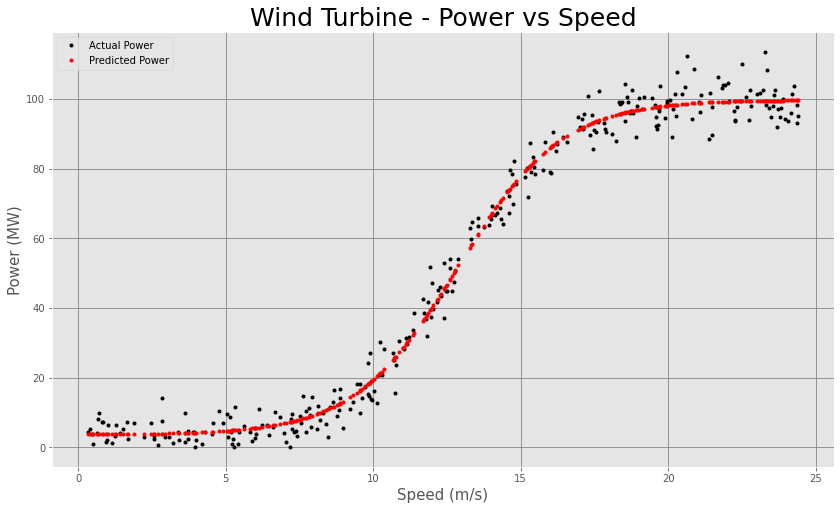

In [29]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

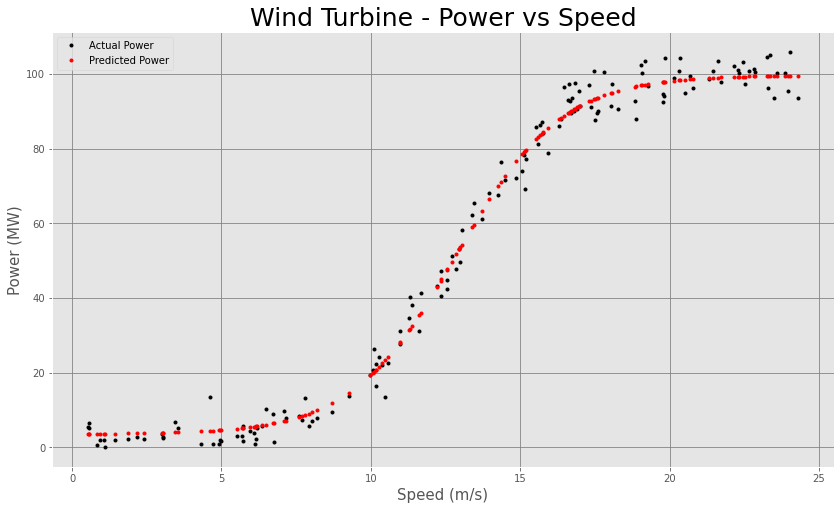

In [30]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [31]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 998us/step - loss: 14.4229


14.422917366027832

In [32]:
y_pred = model.predict(X_test)

In [33]:
y_test.shape = (-1,1)

In [34]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99113


### 5.2 - Test model consisting of: 1 neuron, 5000 epochs, batch size=10

Using the same model as above, we will fit a model by loading inputs in batches of 10 beteen each run of the optimizer

In [35]:
# B
#model = kr.models.Sequential()
#model.add(kr.layers.Dense(1, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
#model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
#model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [36]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9727
Epoch 2/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8993
Epoch 3/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8901
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8935
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9971
Epoch 6/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9237
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8865
Epoch 8/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9165
Epoch 9/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9026
Epoch 10/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.8834
Epoch 11/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.0071
Epoch 12/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9274
Epoch 13/5000

31/31 [==============================] - 0s 2ms/step - loss: 17.9723
Epoch 100/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9218
Epoch 101/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0497
Epoch 102/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9702
Epoch 103/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9289
Epoch 104/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9356
Epoch 105/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9883
Epoch 106/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9737
Epoch 107/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9665
Epoch 108/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9073
Epoch 109/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0531
Epoch 110/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8842
Epoch 1

31/31 [==============================] - 0s 1ms/step - loss: 18.0665
Epoch 197/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9126
Epoch 198/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9254
Epoch 199/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9883
Epoch 200/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9817
Epoch 201/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9919
Epoch 202/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0562
Epoch 203/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9391
Epoch 204/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0148
Epoch 205/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9214
Epoch 206/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9284
Epoch 207/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0024
Epoch 2

31/31 [==============================] - 0s 1ms/step - loss: 17.9330
Epoch 294/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9462
Epoch 295/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9207
Epoch 296/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0942
Epoch 297/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9359
Epoch 298/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9141
Epoch 299/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9370
Epoch 300/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0568
Epoch 301/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0110
Epoch 302/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9134
Epoch 303/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9386
Epoch 304/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0165
Epoch 3

31/31 [==============================] - 0s 1ms/step - loss: 17.9140
Epoch 391/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9346
Epoch 392/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0903
Epoch 393/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8741
Epoch 394/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9768
Epoch 395/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8841
Epoch 396/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1412
Epoch 397/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9675
Epoch 398/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0746
Epoch 399/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9909
Epoch 400/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9641
Epoch 401/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9837
Epoch 4

31/31 [==============================] - 0s 1ms/step - loss: 18.1230
Epoch 488/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9671
Epoch 489/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1062
Epoch 490/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0804
Epoch 491/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9307
Epoch 492/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1590
Epoch 493/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1527
Epoch 494/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9153
Epoch 495/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0244
Epoch 496/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9313
Epoch 497/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9850
Epoch 498/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0437
Epoch 4

31/31 [==============================] - 0s 1ms/step - loss: 17.9576
Epoch 585/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0623
Epoch 586/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9575
Epoch 587/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9042
Epoch 588/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0025
Epoch 589/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9347
Epoch 590/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0487
Epoch 591/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9418
Epoch 592/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9529
Epoch 593/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0790
Epoch 594/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1901
Epoch 595/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0728
Epoch 5

31/31 [==============================] - 0s 1ms/step - loss: 17.9400
Epoch 682/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0715
Epoch 683/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9303
Epoch 684/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9772
Epoch 685/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1263
Epoch 686/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2847
Epoch 687/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9907
Epoch 688/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0695
Epoch 689/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0030
Epoch 690/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0019
Epoch 691/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0669
Epoch 692/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0123
Epoch 6

31/31 [==============================] - 0s 1ms/step - loss: 17.9780
Epoch 779/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9676
Epoch 780/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1047
Epoch 781/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0575
Epoch 782/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9449
Epoch 783/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1020
Epoch 784/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9215
Epoch 785/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9642
Epoch 786/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1925
Epoch 787/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8942
Epoch 788/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9714
Epoch 789/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9039
Epoch 7

31/31 [==============================] - 0s 1ms/step - loss: 17.9671
Epoch 876/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9629
Epoch 877/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9022
Epoch 878/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0190
Epoch 879/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9892
Epoch 880/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9757
Epoch 881/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9113
Epoch 882/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9748
Epoch 883/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9311
Epoch 884/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0873
Epoch 885/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0883
Epoch 886/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8880
Epoch 8

31/31 [==============================] - 0s 1ms/step - loss: 17.9932
Epoch 973/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1297
Epoch 974/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9421
Epoch 975/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9658
Epoch 976/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9354
Epoch 977/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0315
Epoch 978/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9438
Epoch 979/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9267
Epoch 980/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1185
Epoch 981/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9559
Epoch 982/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9591
Epoch 983/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9973
Epoch 9

31/31 [==============================] - 0s 1ms/step - loss: 18.0679
Epoch 1069/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1645
Epoch 1070/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9982
Epoch 1071/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8990
Epoch 1072/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9331
Epoch 1073/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9740
Epoch 1074/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0270
Epoch 1075/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9906
Epoch 1076/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9252
Epoch 1077/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9395
Epoch 1078/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8889
Epoch 1079/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9023
Epoch 1165/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9007
Epoch 1166/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9292
Epoch 1167/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9683
Epoch 1168/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9992
Epoch 1169/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1162
Epoch 1170/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3569
Epoch 1171/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8963
Epoch 1172/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0746
Epoch 1173/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0578
Epoch 1174/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0594
Epoch 1175/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9720
Epoch 1261/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2234
Epoch 1262/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0238
Epoch 1263/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9901
Epoch 1264/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8858
Epoch 1265/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9713
Epoch 1266/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0603
Epoch 1267/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0164
Epoch 1268/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2183
Epoch 1269/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8810
Epoch 1270/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9744
Epoch 1271/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8

31/31 [==============================] - 0s 1ms/step - loss: 17.9504
Epoch 1357/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9380
Epoch 1358/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9285
Epoch 1359/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9762
Epoch 1360/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9450
Epoch 1361/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1213
Epoch 1362/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9560
Epoch 1363/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9719
Epoch 1364/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9228
Epoch 1365/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9109
Epoch 1366/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0996
Epoch 1367/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3

31/31 [==============================] - 0s 1ms/step - loss: 17.9573
Epoch 1453/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9604
Epoch 1454/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0807
Epoch 1455/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0176
Epoch 1456/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0301
Epoch 1457/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9261
Epoch 1458/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0319
Epoch 1459/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1669
Epoch 1460/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0025
Epoch 1461/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9579
Epoch 1462/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0812
Epoch 1463/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9549
Epoch 1549/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1574
Epoch 1550/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0729
Epoch 1551/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1458
Epoch 1552/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9316
Epoch 1553/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9447
Epoch 1554/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8871
Epoch 1555/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1205
Epoch 1556/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0378
Epoch 1557/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9093
Epoch 1558/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9143
Epoch 1559/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9350
Epoch 1645/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9465
Epoch 1646/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0463
Epoch 1647/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9839
Epoch 1648/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9361
Epoch 1649/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9434
Epoch 1650/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9108
Epoch 1651/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1487
Epoch 1652/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0903
Epoch 1653/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9467
Epoch 1654/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9153
Epoch 1655/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9640
Epoch 1741/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9543
Epoch 1742/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9598
Epoch 1743/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0481
Epoch 1744/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0319
Epoch 1745/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9663
Epoch 1746/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1199
Epoch 1747/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.0161
Epoch 1748/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1245
Epoch 1749/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0597
Epoch 1750/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9295
Epoch 1751/5000
31/31 [==============================] - ETA: 0s - loss: 21.28 - 

31/31 [==============================] - 0s 2ms/step - loss: 17.8987
Epoch 1837/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8966
Epoch 1838/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9635
Epoch 1839/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9711
Epoch 1840/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9883
Epoch 1841/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1291
Epoch 1842/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9362
Epoch 1843/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0572
Epoch 1844/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9318
Epoch 1845/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9491
Epoch 1846/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9906
Epoch 1847/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9870
Epoch 1933/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3435
Epoch 1934/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9649
Epoch 1935/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0375
Epoch 1936/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7000
Epoch 1937/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0132
Epoch 1938/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9306
Epoch 1939/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9184
Epoch 1940/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9968
Epoch 1941/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9151
Epoch 1942/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9478
Epoch 1943/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9551
Epoch 2029/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9243
Epoch 2030/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9521
Epoch 2031/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9960
Epoch 2032/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.0192
Epoch 2033/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.3679
Epoch 2034/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.8816
Epoch 2035/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0415
Epoch 2036/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9328
Epoch 2037/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9765
Epoch 2038/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4826
Epoch 2039/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0323
Epoch 2125/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1127
Epoch 2126/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9446
Epoch 2127/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9404
Epoch 2128/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9475
Epoch 2129/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9139
Epoch 2130/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9840
Epoch 2131/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9975
Epoch 2132/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9579
Epoch 2133/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9940
Epoch 2134/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9760
Epoch 2135/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9307
Epoch 2221/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9316
Epoch 2222/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9898
Epoch 2223/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9298
Epoch 2224/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1170
Epoch 2225/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9369
Epoch 2226/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9143
Epoch 2227/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9372
Epoch 2228/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9044
Epoch 2229/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9589
Epoch 2230/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9762
Epoch 2231/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0001
Epoch 2317/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9507
Epoch 2318/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9404
Epoch 2319/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9448
Epoch 2320/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9785
Epoch 2321/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9242
Epoch 2322/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9119
Epoch 2323/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9301
Epoch 2324/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9477
Epoch 2325/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0278
Epoch 2326/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1040
Epoch 2327/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9885
Epoch 2413/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9847
Epoch 2414/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9133
Epoch 2415/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0825
Epoch 2416/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9546
Epoch 2417/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9243
Epoch 2418/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0759
Epoch 2419/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0191
Epoch 2420/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0905
Epoch 2421/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9588
Epoch 2422/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9519
Epoch 2423/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 2ms/step - loss: 17.9166
Epoch 2509/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9120
Epoch 2510/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0486
Epoch 2511/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0455
Epoch 2512/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0466
Epoch 2513/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9608
Epoch 2514/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8983
Epoch 2515/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0900
Epoch 2516/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0134
Epoch 2517/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9017
Epoch 2518/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0717
Epoch 2519/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9640
Epoch 2605/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0097
Epoch 2606/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0283
Epoch 2607/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0778
Epoch 2608/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9684
Epoch 2609/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9547
Epoch 2610/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9677
Epoch 2611/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9541
Epoch 2612/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9458
Epoch 2613/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9293
Epoch 2614/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0485
Epoch 2615/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9398
Epoch 2701/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9364
Epoch 2702/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9666
Epoch 2703/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0576
Epoch 2704/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9909
Epoch 2705/5000
31/31 [==============================] - ETA: 0s - loss: 5.842 - 0s 1ms/step - loss: 17.9840
Epoch 2706/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0096
Epoch 2707/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0016
Epoch 2708/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1647
Epoch 2709/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1771
Epoch 2710/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9485
Epoch 2711/5000
31/31 [==============================] - 

31/31 [==============================] - 0s 1ms/step - loss: 17.9763
Epoch 2797/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0155
Epoch 2798/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0149
Epoch 2799/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9260
Epoch 2800/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9457
Epoch 2801/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9597
Epoch 2802/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0202
Epoch 2803/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9521
Epoch 2804/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9306
Epoch 2805/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9745
Epoch 2806/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9703
Epoch 2807/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9324
Epoch 2893/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9173
Epoch 2894/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9793
Epoch 2895/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9786
Epoch 2896/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1257
Epoch 2897/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0075
Epoch 2898/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0327
Epoch 2899/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9519
Epoch 2900/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9680
Epoch 2901/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9192
Epoch 2902/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9222
Epoch 2903/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9759
Epoch 2989/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1003
Epoch 2990/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0640
Epoch 2991/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9652
Epoch 2992/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0668
Epoch 2993/5000
31/31 [==============================] - ETA: 0s - loss: 17.30 - 0s 1ms/step - loss: 18.0791
Epoch 2994/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9457
Epoch 2995/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9116
Epoch 2996/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9245
Epoch 2997/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.1728
Epoch 2998/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0172
Epoch 2999/5000
31/31 [==============================] - 

31/31 [==============================] - 0s 1ms/step - loss: 18.0062
Epoch 3085/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9459
Epoch 3086/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9693
Epoch 3087/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9777
Epoch 3088/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1299
Epoch 3089/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9049
Epoch 3090/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9492
Epoch 3091/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0119
Epoch 3092/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9451
Epoch 3093/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9343
Epoch 3094/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9141
Epoch 3095/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.0135
Epoch 3181/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9786
Epoch 3182/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8637
Epoch 3183/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0278
Epoch 3184/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9383
Epoch 3185/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9393
Epoch 3186/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9132
Epoch 3187/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9748
Epoch 3188/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0293
Epoch 3189/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1149
Epoch 3190/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9125
Epoch 3191/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9799
Epoch 3277/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9367
Epoch 3278/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8970
Epoch 3279/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0417
Epoch 3280/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9837
Epoch 3281/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9450
Epoch 3282/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0471
Epoch 3283/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1604
Epoch 3284/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2783
Epoch 3285/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9877
Epoch 3286/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9688
Epoch 3287/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.8743
Epoch 3373/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9518
Epoch 3374/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9257
Epoch 3375/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9455
Epoch 3376/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9232
Epoch 3377/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9446
Epoch 3378/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0687
Epoch 3379/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9869
Epoch 3380/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9140
Epoch 3381/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9918
Epoch 3382/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0060
Epoch 3383/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9952
Epoch 3469/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1569
Epoch 3470/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9485
Epoch 3471/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9699
Epoch 3472/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0340
Epoch 3473/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9824
Epoch 3474/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9521
Epoch 3475/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0319
Epoch 3476/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9665
Epoch 3477/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2516
Epoch 3478/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0140
Epoch 3479/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.1291
Epoch 3565/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9486
Epoch 3566/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0969
Epoch 3567/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9935
Epoch 3568/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9295
Epoch 3569/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9192
Epoch 3570/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9403
Epoch 3571/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9270
Epoch 3572/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9349
Epoch 3573/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9589
Epoch 3574/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9778
Epoch 3575/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.3063
Epoch 3661/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9709
Epoch 3662/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9224
Epoch 3663/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0351
Epoch 3664/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9579
Epoch 3665/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0394
Epoch 3666/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9461
Epoch 3667/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9029
Epoch 3668/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0273
Epoch 3669/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1301
Epoch 3670/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9258
Epoch 3671/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9769
Epoch 3757/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9265
Epoch 3758/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9063
Epoch 3759/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0520
Epoch 3760/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9930
Epoch 3761/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0049
Epoch 3762/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9472
Epoch 3763/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0490
Epoch 3764/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9460
Epoch 3765/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8996
Epoch 3766/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9311
Epoch 3767/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 18.0980
Epoch 3853/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9540
Epoch 3854/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0529
Epoch 3855/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2197
Epoch 3856/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9882
Epoch 3857/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1544
Epoch 3858/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0160
Epoch 3859/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9605
Epoch 3860/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0279
Epoch 3861/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9652
Epoch 3862/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2235
Epoch 3863/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 18.0271
Epoch 3949/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9761
Epoch 3950/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9089
Epoch 3951/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9506
Epoch 3952/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9601
Epoch 3953/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0299
Epoch 3954/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8887
Epoch 3955/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8930
Epoch 3956/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9273
Epoch 3957/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9828
Epoch 3958/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9041
Epoch 3959/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9483
Epoch 4045/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9171
Epoch 4046/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9853
Epoch 4047/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.9477
Epoch 4048/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9339
Epoch 4049/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9672
Epoch 4050/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1605
Epoch 4051/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9679
Epoch 4052/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9598
Epoch 4053/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8861
Epoch 4054/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9687
Epoch 4055/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 18.4157
Epoch 4141/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2151
Epoch 4142/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9582
Epoch 4143/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1009
Epoch 4144/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9536
Epoch 4145/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9895
Epoch 4146/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0206
Epoch 4147/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0021
Epoch 4148/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0801
Epoch 4149/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9888
Epoch 4150/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9393
Epoch 4151/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9864
Epoch 4237/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9346
Epoch 4238/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9122
Epoch 4239/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0440
Epoch 4240/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9411
Epoch 4241/5000
31/31 [==============================] - ETA: 0s - loss: 15.70 - 0s 1ms/step - loss: 17.9448
Epoch 4242/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0059
Epoch 4243/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9766
Epoch 4244/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9524
Epoch 4245/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0400
Epoch 4246/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9558
Epoch 4247/5000
31/31 [==============================] - 

31/31 [==============================] - 0s 1ms/step - loss: 17.9527
Epoch 4333/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9307
Epoch 4334/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9218
Epoch 4335/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0978
Epoch 4336/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9455
Epoch 4337/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9528
Epoch 4338/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0694
Epoch 4339/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0414
Epoch 4340/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0713
Epoch 4341/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0753
Epoch 4342/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9948
Epoch 4343/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9767
Epoch 4429/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9284
Epoch 4430/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8953
Epoch 4431/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9380
Epoch 4432/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9304
Epoch 4433/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8905
Epoch 4434/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0275
Epoch 4435/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9493
Epoch 4436/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9279
Epoch 4437/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9038
Epoch 4438/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9416
Epoch 4439/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9443
Epoch 4525/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9799
Epoch 4526/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9969
Epoch 4527/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1593
Epoch 4528/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9185
Epoch 4529/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9269
Epoch 4530/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9069
Epoch 4531/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9131
Epoch 4532/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9615
Epoch 4533/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1542
Epoch 4534/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9712
Epoch 4535/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9393
Epoch 4621/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9911
Epoch 4622/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1440
Epoch 4623/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9915
Epoch 4624/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9550
Epoch 4625/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0200
Epoch 4626/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0039
Epoch 4627/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9789
Epoch 4628/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0809
Epoch 4629/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9631
Epoch 4630/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9837
Epoch 4631/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9340
Epoch 4717/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9646
Epoch 4718/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9602
Epoch 4719/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9422
Epoch 4720/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9374
Epoch 4721/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9613
Epoch 4722/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9267
Epoch 4723/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0853
Epoch 4724/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1689
Epoch 4725/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0116
Epoch 4726/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9413
Epoch 4727/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

31/31 [==============================] - 0s 1ms/step - loss: 17.9634
Epoch 4813/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9144
Epoch 4814/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9280
Epoch 4815/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9966
Epoch 4816/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9389
Epoch 4817/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2194
Epoch 4818/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8966
Epoch 4819/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9327
Epoch 4820/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9312
Epoch 4821/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9123
Epoch 4822/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9579
Epoch 4823/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0

31/31 [==============================] - 0s 1ms/step - loss: 17.9731
Epoch 4909/5000
31/31 [==============================] - 0s 2ms/step - loss: 18.0625
Epoch 4910/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9416
Epoch 4911/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0348
Epoch 4912/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0393
Epoch 4913/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0294
Epoch 4914/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0108
Epoch 4915/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9561
Epoch 4916/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9564
Epoch 4917/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4550
Epoch 4918/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0151
Epoch 4919/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9

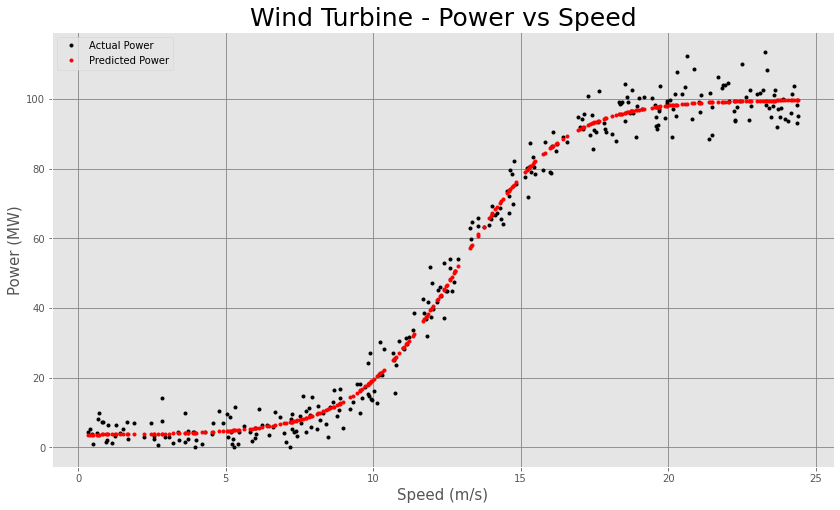

In [37]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

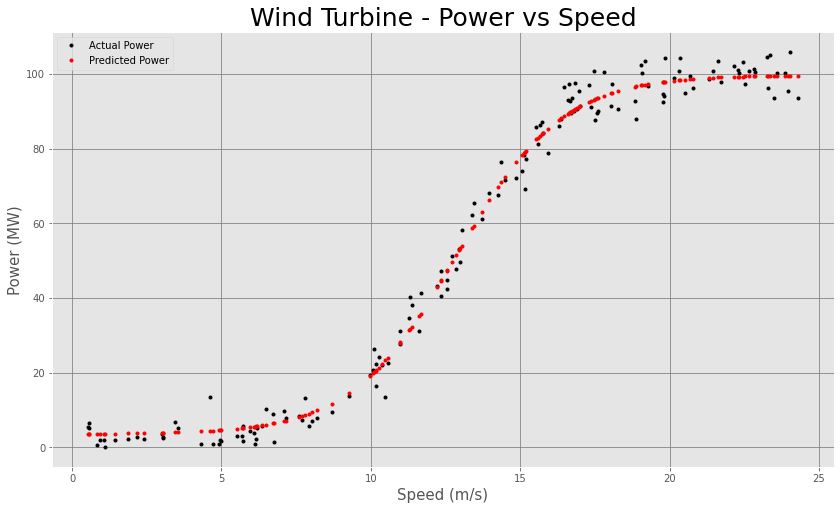

In [38]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [39]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 14.4371


14.437093734741211

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_test.shape = (-1,1)

In [42]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99112


### 5.3 - Test model consisting of: 2 neurons 5000 epochs, batch size=10

![2-neurons](Images/2-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

We will build a model consisting of 2 neurons in the hidden layer

In [43]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 1 neuron to 2 neurons
model.add(kr.layers.Dense(2, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [44]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 765us/step - loss: 4240.9908
Epoch 2/5000
31/31 [==============================] - 0s 931us/step - loss: 4388.6723
Epoch 3/5000
31/31 [==============================] - 0s 864us/step - loss: 4331.7328
Epoch 4/5000
31/31 [==============================] - 0s 1ms/step - loss: 4691.7338
Epoch 5/5000
31/31 [==============================] - 0s 1ms/step - loss: 4663.8666
Epoch 6/5000
31/31 [==============================] - 0s 898us/step - loss: 4153.6235
Epoch 7/5000
31/31 [==============================] - 0s 964us/step - loss: 4462.1938
Epoch 8/5000
31/31 [==============================] - 0s 999us/step - loss: 4209.7646
Epoch 9/5000
31/31 [==============================] - 0s 1ms/step - loss: 4387.8949
Epoch 10/5000
31/31 [==============================] - 0s 830us/step - loss: 4202.6443
Epoch 11/5000
31/31 [==============================] - 0s 964us/step - loss: 4003.6699
Epoch 12/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 997us/step - loss: 3965.3235
Epoch 96/5000
31/31 [==============================] - 0s 931us/step - loss: 3675.2624
Epoch 97/5000
31/31 [==============================] - 0s 931us/step - loss: 3962.5492
Epoch 98/5000
31/31 [==============================] - 0s 931us/step - loss: 4203.9180
Epoch 99/5000
31/31 [==============================] - 0s 979us/step - loss: 3898.5061
Epoch 100/5000
31/31 [==============================] - 0s 831us/step - loss: 3680.2389
Epoch 101/5000
31/31 [==============================] - 0s 964us/step - loss: 3791.4554
Epoch 102/5000
31/31 [==============================] - 0s 841us/step - loss: 3938.5188
Epoch 103/5000
31/31 [==============================] - 0s 898us/step - loss: 3799.5164
Epoch 104/5000
31/31 [==============================] - 0s 865us/step - loss: 3594.2520
Epoch 105/5000
31/31 [==============================] - 0s 811us/step - loss: 3830.3624
Epoch 106/5000
31/31 [=============================

31/31 [==============================] - 0s 1ms/step - loss: 3488.0358
Epoch 189/5000
31/31 [==============================] - 0s 1ms/step - loss: 3309.0241
Epoch 190/5000
31/31 [==============================] - 0s 898us/step - loss: 3376.3776
Epoch 191/5000
31/31 [==============================] - 0s 997us/step - loss: 3453.8590
Epoch 192/5000
31/31 [==============================] - 0s 811us/step - loss: 3500.0393
Epoch 193/5000
31/31 [==============================] - 0s 1ms/step - loss: 3157.9244
Epoch 194/5000
31/31 [==============================] - 0s 1ms/step - loss: 3197.2091
Epoch 195/5000
31/31 [==============================] - 0s 847us/step - loss: 3033.1771
Epoch 196/5000
31/31 [==============================] - 0s 898us/step - loss: 3297.6453
Epoch 197/5000
31/31 [==============================] - 0s 926us/step - loss: 3365.1958
Epoch 198/5000
31/31 [==============================] - 0s 845us/step - loss: 3220.3415
Epoch 199/5000
31/31 [==============================] -

31/31 [==============================] - 0s 916us/step - loss: 3029.9462
Epoch 282/5000
31/31 [==============================] - 0s 1ms/step - loss: 2861.9271
Epoch 283/5000
31/31 [==============================] - 0s 1ms/step - loss: 2769.2464
Epoch 284/5000
31/31 [==============================] - 0s 1ms/step - loss: 2589.6649
Epoch 285/5000
31/31 [==============================] - 0s 997us/step - loss: 2550.1346
Epoch 286/5000
31/31 [==============================] - 0s 965us/step - loss: 2850.0121
Epoch 287/5000
31/31 [==============================] - 0s 832us/step - loss: 2933.8318
Epoch 288/5000
31/31 [==============================] - 0s 963us/step - loss: 2897.7857
Epoch 289/5000
31/31 [==============================] - 0s 963us/step - loss: 2689.4881
Epoch 290/5000
31/31 [==============================] - 0s 1ms/step - loss: 2847.2232
Epoch 291/5000
31/31 [==============================] - 0s 1ms/step - loss: 2701.3678
Epoch 292/5000
31/31 [==============================] - 0

31/31 [==============================] - 0s 854us/step - loss: 2520.2777
Epoch 375/5000
31/31 [==============================] - 0s 898us/step - loss: 2289.0165
Epoch 376/5000
31/31 [==============================] - 0s 859us/step - loss: 2531.8566
Epoch 377/5000
31/31 [==============================] - 0s 931us/step - loss: 2440.7351
Epoch 378/5000
31/31 [==============================] - 0s 964us/step - loss: 2485.8423
Epoch 379/5000
31/31 [==============================] - 0s 899us/step - loss: 2530.6525
Epoch 380/5000
31/31 [==============================] - 0s 997us/step - loss: 2463.4314
Epoch 381/5000
31/31 [==============================] - 0s 964us/step - loss: 2459.9957
Epoch 382/5000
31/31 [==============================] - 0s 1ms/step - loss: 2410.5099
Epoch 383/5000
31/31 [==============================] - 0s 964us/step - loss: 2690.8631
Epoch 384/5000
31/31 [==============================] - 0s 955us/step - loss: 2428.6662
Epoch 385/5000
31/31 [===========================

31/31 [==============================] - 0s 857us/step - loss: 2192.1780
Epoch 468/5000
31/31 [==============================] - 0s 845us/step - loss: 2067.9301
Epoch 469/5000
31/31 [==============================] - 0s 967us/step - loss: 2133.5263
Epoch 470/5000
31/31 [==============================] - 0s 896us/step - loss: 2125.1335
Epoch 471/5000
31/31 [==============================] - 0s 819us/step - loss: 2227.1484
Epoch 472/5000
31/31 [==============================] - 0s 1ms/step - loss: 1977.3315
Epoch 473/5000
31/31 [==============================] - 0s 837us/step - loss: 1853.7456
Epoch 474/5000
31/31 [==============================] - 0s 902us/step - loss: 2068.5988
Epoch 475/5000
31/31 [==============================] - 0s 877us/step - loss: 2409.6863
Epoch 476/5000
31/31 [==============================] - 0s 898us/step - loss: 2128.2981
Epoch 477/5000
31/31 [==============================] - 0s 931us/step - loss: 1990.6021
Epoch 478/5000
31/31 [===========================

31/31 [==============================] - 0s 864us/step - loss: 2109.6299
Epoch 561/5000
31/31 [==============================] - 0s 931us/step - loss: 1751.6725
Epoch 562/5000
31/31 [==============================] - 0s 965us/step - loss: 1819.2614
Epoch 563/5000
31/31 [==============================] - 0s 997us/step - loss: 1874.7678
Epoch 564/5000
31/31 [==============================] - 0s 931us/step - loss: 1929.6323
Epoch 565/5000
31/31 [==============================] - 0s 899us/step - loss: 1778.2099
Epoch 566/5000
31/31 [==============================] - 0s 898us/step - loss: 1708.1290
Epoch 567/5000
31/31 [==============================] - 0s 866us/step - loss: 1855.2953
Epoch 568/5000
31/31 [==============================] - 0s 932us/step - loss: 1722.5922
Epoch 569/5000
31/31 [==============================] - 0s 964us/step - loss: 1728.5929
Epoch 570/5000
31/31 [==============================] - 0s 884us/step - loss: 1957.4080
Epoch 571/5000
31/31 [=========================

31/31 [==============================] - 0s 898us/step - loss: 1393.7415
Epoch 654/5000
31/31 [==============================] - 0s 931us/step - loss: 1605.4722
Epoch 655/5000
31/31 [==============================] - 0s 964us/step - loss: 1506.7156
Epoch 656/5000
31/31 [==============================] - 0s 931us/step - loss: 1488.2849
Epoch 657/5000
31/31 [==============================] - 0s 832us/step - loss: 1471.1692
Epoch 658/5000
31/31 [==============================] - 0s 930us/step - loss: 1416.2392
Epoch 659/5000
31/31 [==============================] - 0s 964us/step - loss: 1523.2237
Epoch 660/5000
31/31 [==============================] - 0s 899us/step - loss: 1428.6297
Epoch 661/5000
31/31 [==============================] - 0s 928us/step - loss: 1270.8025
Epoch 662/5000
31/31 [==============================] - 0s 843us/step - loss: 1635.1319
Epoch 663/5000
31/31 [==============================] - 0s 817us/step - loss: 1486.6252
Epoch 664/5000
31/31 [=========================

31/31 [==============================] - 0s 1ms/step - loss: 1381.2342
Epoch 746/5000
31/31 [==============================] - 0s 997us/step - loss: 1316.0440
Epoch 747/5000
31/31 [==============================] - 0s 931us/step - loss: 1191.4712
Epoch 748/5000
31/31 [==============================] - 0s 1ms/step - loss: 1377.1734
Epoch 749/5000
31/31 [==============================] - 0s 899us/step - loss: 1151.9359
Epoch 750/5000
31/31 [==============================] - 0s 798us/step - loss: 1344.1907
Epoch 751/5000
31/31 [==============================] - 0s 964us/step - loss: 1180.9301
Epoch 752/5000
31/31 [==============================] - 0s 932us/step - loss: 1340.8102
Epoch 753/5000
31/31 [==============================] - 0s 994us/step - loss: 1191.0419
Epoch 754/5000
31/31 [==============================] - 0s 878us/step - loss: 1315.8200
Epoch 755/5000
31/31 [==============================] - 0s 964us/step - loss: 1204.5420
Epoch 756/5000
31/31 [=============================

31/31 [==============================] - 0s 823us/step - loss: 1092.4381
Epoch 839/5000
31/31 [==============================] - 0s 931us/step - loss: 1029.9037
Epoch 840/5000
31/31 [==============================] - 0s 1ms/step - loss: 1059.8290
Epoch 841/5000
31/31 [==============================] - 0s 973us/step - loss: 963.5674
Epoch 842/5000
31/31 [==============================] - 0s 866us/step - loss: 992.6129
Epoch 843/5000
31/31 [==============================] - 0s 964us/step - loss: 994.3890
Epoch 844/5000
31/31 [==============================] - 0s 892us/step - loss: 1055.3752
Epoch 845/5000
31/31 [==============================] - 0s 932us/step - loss: 1036.1114
Epoch 846/5000
31/31 [==============================] - 0s 931us/step - loss: 914.9080
Epoch 847/5000
31/31 [==============================] - 0s 964us/step - loss: 997.7783
Epoch 848/5000
31/31 [==============================] - 0s 831us/step - loss: 972.5464
Epoch 849/5000
31/31 [==============================] -

31/31 [==============================] - 0s 931us/step - loss: 833.7342
Epoch 933/5000
31/31 [==============================] - 0s 820us/step - loss: 800.0186
Epoch 934/5000
31/31 [==============================] - 0s 847us/step - loss: 813.9536
Epoch 935/5000
31/31 [==============================] - 0s 1ms/step - loss: 746.4028
Epoch 936/5000
31/31 [==============================] - 0s 981us/step - loss: 789.8506
Epoch 937/5000
31/31 [==============================] - 0s 864us/step - loss: 864.7391
Epoch 938/5000
31/31 [==============================] - 0s 932us/step - loss: 880.5408
Epoch 939/5000
31/31 [==============================] - 0s 897us/step - loss: 801.2909
Epoch 940/5000
31/31 [==============================] - 0s 930us/step - loss: 795.3031
Epoch 941/5000
31/31 [==============================] - 0s 932us/step - loss: 749.9580
Epoch 942/5000
31/31 [==============================] - 0s 994us/step - loss: 782.6740
Epoch 943/5000
31/31 [==============================] - 0s 7

31/31 [==============================] - 0s 853us/step - loss: 571.0278
Epoch 1027/5000
31/31 [==============================] - 0s 931us/step - loss: 643.8457
Epoch 1028/5000
31/31 [==============================] - 0s 964us/step - loss: 672.8136
Epoch 1029/5000
31/31 [==============================] - 0s 997us/step - loss: 646.8306
Epoch 1030/5000
31/31 [==============================] - 0s 841us/step - loss: 679.3670
Epoch 1031/5000
31/31 [==============================] - 0s 898us/step - loss: 645.8174
Epoch 1032/5000
31/31 [==============================] - 0s 964us/step - loss: 667.7513
Epoch 1033/5000
31/31 [==============================] - 0s 914us/step - loss: 617.5026
Epoch 1034/5000
31/31 [==============================] - 0s 997us/step - loss: 592.7256
Epoch 1035/5000
31/31 [==============================] - 0s 844us/step - loss: 609.4613
Epoch 1036/5000
31/31 [==============================] - 0s 932us/step - loss: 617.8647
Epoch 1037/5000
31/31 [=========================

31/31 [==============================] - 0s 898us/step - loss: 437.2618
Epoch 1120/5000
31/31 [==============================] - 0s 931us/step - loss: 484.5804
Epoch 1121/5000
31/31 [==============================] - 0s 898us/step - loss: 449.2442
Epoch 1122/5000
31/31 [==============================] - 0s 997us/step - loss: 470.8331
Epoch 1123/5000
31/31 [==============================] - 0s 914us/step - loss: 454.8803
Epoch 1124/5000
31/31 [==============================] - 0s 890us/step - loss: 529.9671
Epoch 1125/5000
31/31 [==============================] - 0s 896us/step - loss: 464.9125
Epoch 1126/5000
31/31 [==============================] - 0s 864us/step - loss: 466.7015
Epoch 1127/5000
31/31 [==============================] - 0s 863us/step - loss: 450.6539
Epoch 1128/5000
31/31 [==============================] - 0s 959us/step - loss: 491.1688
Epoch 1129/5000
31/31 [==============================] - 0s 938us/step - loss: 480.2326
Epoch 1130/5000
31/31 [=========================

31/31 [==============================] - 0s 899us/step - loss: 389.4939
Epoch 1213/5000
31/31 [==============================] - 0s 898us/step - loss: 344.8713
Epoch 1214/5000
31/31 [==============================] - 0s 964us/step - loss: 364.4991
Epoch 1215/5000
31/31 [==============================] - 0s 902us/step - loss: 364.6549
Epoch 1216/5000
31/31 [==============================] - 0s 857us/step - loss: 360.0964
Epoch 1217/5000
31/31 [==============================] - 0s 964us/step - loss: 334.3740
Epoch 1218/5000
31/31 [==============================] - 0s 973us/step - loss: 344.8293
Epoch 1219/5000
31/31 [==============================] - 0s 1ms/step - loss: 339.6971
Epoch 1220/5000
31/31 [==============================] - 0s 866us/step - loss: 326.6440
Epoch 1221/5000
31/31 [==============================] - 0s 865us/step - loss: 366.8899
Epoch 1222/5000
31/31 [==============================] - 0s 931us/step - loss: 339.1240
Epoch 1223/5000
31/31 [===========================

31/31 [==============================] - 0s 964us/step - loss: 231.4260
Epoch 1306/5000
31/31 [==============================] - 0s 964us/step - loss: 253.0151
Epoch 1307/5000
31/31 [==============================] - 0s 931us/step - loss: 250.0731
Epoch 1308/5000
31/31 [==============================] - 0s 898us/step - loss: 239.2505
Epoch 1309/5000
31/31 [==============================] - 0s 874us/step - loss: 253.7733
Epoch 1310/5000
31/31 [==============================] - 0s 898us/step - loss: 275.2183
Epoch 1311/5000
31/31 [==============================] - 0s 896us/step - loss: 243.0598
Epoch 1312/5000
31/31 [==============================] - 0s 831us/step - loss: 273.3331
Epoch 1313/5000
31/31 [==============================] - 0s 947us/step - loss: 247.0305
Epoch 1314/5000
31/31 [==============================] - 0s 806us/step - loss: 236.5186
Epoch 1315/5000
31/31 [==============================] - 0s 898us/step - loss: 233.4677
Epoch 1316/5000
31/31 [=========================

31/31 [==============================] - 0s 898us/step - loss: 176.9998
Epoch 1399/5000
31/31 [==============================] - 0s 964us/step - loss: 178.0494
Epoch 1400/5000
31/31 [==============================] - 0s 1ms/step - loss: 186.6431
Epoch 1401/5000
31/31 [==============================] - 0s 997us/step - loss: 179.8584
Epoch 1402/5000
31/31 [==============================] - 0s 899us/step - loss: 161.8540
Epoch 1403/5000
31/31 [==============================] - 0s 857us/step - loss: 166.9819
Epoch 1404/5000
31/31 [==============================] - 0s 957us/step - loss: 180.2203
Epoch 1405/5000
31/31 [==============================] - 0s 1ms/step - loss: 187.9706
Epoch 1406/5000
31/31 [==============================] - 0s 963us/step - loss: 161.0816
Epoch 1407/5000
31/31 [==============================] - 0s 997us/step - loss: 155.1334
Epoch 1408/5000
31/31 [==============================] - 0s 964us/step - loss: 149.9289
Epoch 1409/5000
31/31 [=============================

31/31 [==============================] - 0s 931us/step - loss: 107.8753
Epoch 1492/5000
31/31 [==============================] - 0s 899us/step - loss: 105.8716
Epoch 1493/5000
31/31 [==============================] - 0s 964us/step - loss: 113.7663
Epoch 1494/5000
31/31 [==============================] - 0s 964us/step - loss: 101.2873
Epoch 1495/5000
31/31 [==============================] - 0s 898us/step - loss: 112.3848
Epoch 1496/5000
31/31 [==============================] - 0s 864us/step - loss: 118.4305
Epoch 1497/5000
31/31 [==============================] - 0s 997us/step - loss: 107.9881
Epoch 1498/5000
31/31 [==============================] - 0s 939us/step - loss: 119.7284
Epoch 1499/5000
31/31 [==============================] - 0s 932us/step - loss: 100.4390
Epoch 1500/5000
31/31 [==============================] - 0s 992us/step - loss: 103.2354
Epoch 1501/5000
31/31 [==============================] - 0s 931us/step - loss: 116.6515
Epoch 1502/5000
31/31 [=========================

31/31 [==============================] - 0s 866us/step - loss: 65.5900
Epoch 1586/5000
31/31 [==============================] - 0s 931us/step - loss: 63.8584
Epoch 1587/5000
31/31 [==============================] - 0s 931us/step - loss: 68.0962
Epoch 1588/5000
31/31 [==============================] - 0s 863us/step - loss: 71.7362
Epoch 1589/5000
31/31 [==============================] - 0s 932us/step - loss: 74.8050
Epoch 1590/5000
31/31 [==============================] - 0s 931us/step - loss: 81.7197
Epoch 1591/5000
31/31 [==============================] - 0s 932us/step - loss: 56.0619
Epoch 1592/5000
31/31 [==============================] - 0s 931us/step - loss: 59.8569
Epoch 1593/5000
31/31 [==============================] - 0s 931us/step - loss: 73.2766
Epoch 1594/5000
31/31 [==============================] - 0s 898us/step - loss: 56.9414
Epoch 1595/5000
31/31 [==============================] - 0s 866us/step - loss: 63.9726
Epoch 1596/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 930us/step - loss: 42.3097
Epoch 1680/5000
31/31 [==============================] - 0s 964us/step - loss: 47.3113
Epoch 1681/5000
31/31 [==============================] - 0s 964us/step - loss: 38.8873
Epoch 1682/5000
31/31 [==============================] - 0s 988us/step - loss: 47.0313
Epoch 1683/5000
31/31 [==============================] - 0s 831us/step - loss: 46.8333
Epoch 1684/5000
31/31 [==============================] - 0s 864us/step - loss: 42.5846
Epoch 1685/5000
31/31 [==============================] - 0s 931us/step - loss: 45.8556
Epoch 1686/5000
31/31 [==============================] - 0s 1ms/step - loss: 48.5521
Epoch 1687/5000
31/31 [==============================] - 0s 1ms/step - loss: 41.5657
Epoch 1688/5000
31/31 [==============================] - 0s 798us/step - loss: 41.9612
Epoch 1689/5000
31/31 [==============================] - 0s 997us/step - loss: 45.0444
Epoch 1690/5000
31/31 [==============================] - 0s 964

31/31 [==============================] - 0s 898us/step - loss: 31.4733
Epoch 1774/5000
31/31 [==============================] - 0s 851us/step - loss: 30.7782
Epoch 1775/5000
31/31 [==============================] - 0s 997us/step - loss: 27.5113
Epoch 1776/5000
31/31 [==============================] - 0s 831us/step - loss: 27.7432
Epoch 1777/5000
31/31 [==============================] - 0s 810us/step - loss: 29.8714
Epoch 1778/5000
31/31 [==============================] - 0s 899us/step - loss: 26.4696
Epoch 1779/5000
31/31 [==============================] - 0s 864us/step - loss: 27.7863
Epoch 1780/5000
31/31 [==============================] - 0s 898us/step - loss: 33.3895
Epoch 1781/5000
31/31 [==============================] - 0s 842us/step - loss: 27.6616
Epoch 1782/5000
31/31 [==============================] - 0s 963us/step - loss: 26.5165
Epoch 1783/5000
31/31 [==============================] - 0s 931us/step - loss: 25.7315
Epoch 1784/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 20.9613
Epoch 1868/5000
31/31 [==============================] - 0s 964us/step - loss: 19.2845
Epoch 1869/5000
31/31 [==============================] - 0s 964us/step - loss: 20.5244
Epoch 1870/5000
31/31 [==============================] - 0s 883us/step - loss: 24.0124
Epoch 1871/5000
31/31 [==============================] - 0s 830us/step - loss: 26.9994
Epoch 1872/5000
31/31 [==============================] - 0s 931us/step - loss: 19.5468
Epoch 1873/5000
31/31 [==============================] - 0s 864us/step - loss: 22.9959
Epoch 1874/5000
31/31 [==============================] - 0s 931us/step - loss: 20.8717
Epoch 1875/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0542
Epoch 1876/5000
31/31 [==============================] - 0s 869us/step - loss: 20.7387
Epoch 1877/5000
31/31 [==============================] - 0s 931us/step - loss: 20.1380
Epoch 1878/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 20.7720
Epoch 1962/5000
31/31 [==============================] - 0s 898us/step - loss: 20.4653
Epoch 1963/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0409
Epoch 1964/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.2186
Epoch 1965/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1400
Epoch 1966/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3998
Epoch 1967/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0876
Epoch 1968/5000
31/31 [==============================] - 0s 961us/step - loss: 17.1107
Epoch 1969/5000
31/31 [==============================] - 0s 964us/step - loss: 21.0154
Epoch 1970/5000
31/31 [==============================] - 0s 955us/step - loss: 19.0435
Epoch 1971/5000
31/31 [==============================] - 0s 931us/step - loss: 17.3276
Epoch 1972/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 1ms/step - loss: 19.7336
Epoch 2056/5000
31/31 [==============================] - 0s 964us/step - loss: 19.2265
Epoch 2057/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.2964
Epoch 2058/5000
31/31 [==============================] - 0s 898us/step - loss: 18.7281
Epoch 2059/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3274
Epoch 2060/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0640
Epoch 2061/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4965
Epoch 2062/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7793
Epoch 2063/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7639
Epoch 2064/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3736
Epoch 2065/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8798
Epoch 2066/5000
31/31 [==============================] - 0s 1ms/step - loss: 

31/31 [==============================] - 0s 964us/step - loss: 17.1431
Epoch 2150/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6441
Epoch 2151/5000
31/31 [==============================] - 0s 899us/step - loss: 16.6733
Epoch 2152/5000
31/31 [==============================] - 0s 931us/step - loss: 19.6998
Epoch 2153/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8253
Epoch 2154/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2612
Epoch 2155/5000
31/31 [==============================] - 0s 844us/step - loss: 15.8815
Epoch 2156/5000
31/31 [==============================] - 0s 931us/step - loss: 15.2639
Epoch 2157/5000
31/31 [==============================] - 0s 799us/step - loss: 16.8349
Epoch 2158/5000
31/31 [==============================] - 0s 853us/step - loss: 16.2818
Epoch 2159/5000
31/31 [==============================] - 0s 932us/step - loss: 16.9112
Epoch 2160/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 20.1194
Epoch 2244/5000
31/31 [==============================] - 0s 997us/step - loss: 20.9963
Epoch 2245/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2396
Epoch 2246/5000
31/31 [==============================] - 0s 866us/step - loss: 17.8069
Epoch 2247/5000
31/31 [==============================] - 0s 932us/step - loss: 17.1245
Epoch 2248/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2307
Epoch 2249/5000
31/31 [==============================] - 0s 964us/step - loss: 18.5082
Epoch 2250/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6900
Epoch 2251/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8921
Epoch 2252/5000
31/31 [==============================] - 0s 792us/step - loss: 17.3998
Epoch 2253/5000
31/31 [==============================] - 0s 932us/step - loss: 18.8475
Epoch 2254/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 899us/step - loss: 16.9390
Epoch 2338/5000
31/31 [==============================] - 0s 931us/step - loss: 19.9541
Epoch 2339/5000
31/31 [==============================] - 0s 932us/step - loss: 16.2642
Epoch 2340/5000
31/31 [==============================] - 0s 934us/step - loss: 16.7673
Epoch 2341/5000
31/31 [==============================] - 0s 932us/step - loss: 18.3355
Epoch 2342/5000
31/31 [==============================] - 0s 881us/step - loss: 20.5774
Epoch 2343/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0600
Epoch 2344/5000
31/31 [==============================] - 0s 996us/step - loss: 21.5854
Epoch 2345/5000
31/31 [==============================] - 0s 931us/step - loss: 18.7281
Epoch 2346/5000
31/31 [==============================] - 0s 865us/step - loss: 17.6527
Epoch 2347/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8644
Epoch 2348/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 889us/step - loss: 19.2679
Epoch 2432/5000
31/31 [==============================] - 0s 931us/step - loss: 20.0562
Epoch 2433/5000
31/31 [==============================] - 0s 931us/step - loss: 15.2834
Epoch 2434/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4488
Epoch 2435/5000
31/31 [==============================] - 0s 926us/step - loss: 18.9176
Epoch 2436/5000
31/31 [==============================] - 0s 931us/step - loss: 20.2223
Epoch 2437/5000
31/31 [==============================] - 0s 930us/step - loss: 17.9400
Epoch 2438/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4419
Epoch 2439/5000
31/31 [==============================] - 0s 880us/step - loss: 17.7663
Epoch 2440/5000
31/31 [==============================] - 0s 965us/step - loss: 19.0681
Epoch 2441/5000
31/31 [==============================] - 0s 856us/step - loss: 16.9173
Epoch 2442/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 864us/step - loss: 18.4486
Epoch 2526/5000
31/31 [==============================] - 0s 790us/step - loss: 17.6719
Epoch 2527/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0463
Epoch 2528/5000
31/31 [==============================] - 0s 899us/step - loss: 19.4136
Epoch 2529/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1842
Epoch 2530/5000
31/31 [==============================] - 0s 895us/step - loss: 17.6219
Epoch 2531/5000
31/31 [==============================] - 0s 931us/step - loss: 18.8392
Epoch 2532/5000
31/31 [==============================] - 0s 835us/step - loss: 16.8865
Epoch 2533/5000
31/31 [==============================] - 0s 964us/step - loss: 19.7263
Epoch 2534/5000
31/31 [==============================] - 0s 898us/step - loss: 17.6564
Epoch 2535/5000
31/31 [==============================] - 0s 898us/step - loss: 18.3431
Epoch 2536/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 932us/step - loss: 17.4800
Epoch 2620/5000
31/31 [==============================] - 0s 864us/step - loss: 16.8164
Epoch 2621/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2730
Epoch 2622/5000
31/31 [==============================] - 0s 964us/step - loss: 18.9822
Epoch 2623/5000
31/31 [==============================] - 0s 854us/step - loss: 18.1367
Epoch 2624/5000
31/31 [==============================] - 0s 887us/step - loss: 18.4223
Epoch 2625/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5505
Epoch 2626/5000
31/31 [==============================] - 0s 965us/step - loss: 15.2385
Epoch 2627/5000
31/31 [==============================] - 0s 931us/step - loss: 19.3369
Epoch 2628/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8662
Epoch 2629/5000
31/31 [==============================] - 0s 942us/step - loss: 18.0430
Epoch 2630/5000
31/31 [==============================] - 0s 898

31/31 [==============================] - 0s 931us/step - loss: 18.5638
Epoch 2714/5000
31/31 [==============================] - 0s 964us/step - loss: 16.0670
Epoch 2715/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6105
Epoch 2716/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1811
Epoch 2717/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.4536
Epoch 2718/5000
31/31 [==============================] - 0s 997us/step - loss: 16.6160
Epoch 2719/5000
31/31 [==============================] - 0s 964us/step - loss: 18.3695
Epoch 2720/5000
31/31 [==============================] - 0s 898us/step - loss: 16.9206
Epoch 2721/5000
31/31 [==============================] - 0s 997us/step - loss: 15.9972
Epoch 2722/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7374
Epoch 2723/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4477
Epoch 2724/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 997us/step - loss: 18.3340
Epoch 2808/5000
31/31 [==============================] - 0s 864us/step - loss: 16.1022
Epoch 2809/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1758
Epoch 2810/5000
31/31 [==============================] - 0s 864us/step - loss: 16.4800
Epoch 2811/5000
31/31 [==============================] - 0s 929us/step - loss: 17.0962
Epoch 2812/5000
31/31 [==============================] - 0s 864us/step - loss: 19.7204
Epoch 2813/5000
31/31 [==============================] - 0s 802us/step - loss: 16.0838
Epoch 2814/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0707
Epoch 2815/5000
31/31 [==============================] - 0s 831us/step - loss: 18.6185
Epoch 2816/5000
31/31 [==============================] - 0s 997us/step - loss: 16.9381
Epoch 2817/5000
31/31 [==============================] - 0s 931us/step - loss: 15.4948
Epoch 2818/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 965us/step - loss: 16.5788
Epoch 2902/5000
31/31 [==============================] - 0s 997us/step - loss: 18.2212
Epoch 2903/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9213
Epoch 2904/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4749
Epoch 2905/5000
31/31 [==============================] - 0s 898us/step - loss: 19.7715
Epoch 2906/5000
31/31 [==============================] - 0s 964us/step - loss: 16.7305
Epoch 2907/5000
31/31 [==============================] - 0s 932us/step - loss: 17.8855
Epoch 2908/5000
31/31 [==============================] - 0s 932us/step - loss: 17.0503
Epoch 2909/5000
31/31 [==============================] - 0s 896us/step - loss: 18.4173
Epoch 2910/5000
31/31 [==============================] - 0s 787us/step - loss: 17.6679
Epoch 2911/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9035
Epoch 2912/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 907us/step - loss: 16.0305
Epoch 2996/5000
31/31 [==============================] - 0s 898us/step - loss: 16.8545
Epoch 2997/5000
31/31 [==============================] - 0s 997us/step - loss: 17.0973
Epoch 2998/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3213
Epoch 2999/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0480
Epoch 3000/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9234
Epoch 3001/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3838
Epoch 3002/5000
31/31 [==============================] - 0s 896us/step - loss: 14.8791
Epoch 3003/5000
31/31 [==============================] - 0s 831us/step - loss: 17.9754
Epoch 3004/5000
31/31 [==============================] - 0s 899us/step - loss: 22.2826
Epoch 3005/5000
31/31 [==============================] - 0s 979us/step - loss: 19.3104
Epoch 3006/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 898us/step - loss: 18.4269
Epoch 3090/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8763
Epoch 3091/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2077
Epoch 3092/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6128
Epoch 3093/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1940
Epoch 3094/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9494
Epoch 3095/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0460
Epoch 3096/5000
31/31 [==============================] - 0s 831us/step - loss: 19.9213
Epoch 3097/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4448
Epoch 3098/5000
31/31 [==============================] - 0s 831us/step - loss: 16.1357
Epoch 3099/5000
31/31 [==============================] - 0s 898us/step - loss: 16.7417
Epoch 3100/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 899us/step - loss: 20.8858
Epoch 3184/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2551
Epoch 3185/5000
31/31 [==============================] - 0s 964us/step - loss: 15.6078
Epoch 3186/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2281
Epoch 3187/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0071
Epoch 3188/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0702
Epoch 3189/5000
31/31 [==============================] - 0s 831us/step - loss: 18.3854
Epoch 3190/5000
31/31 [==============================] - 0s 832us/step - loss: 18.1314
Epoch 3191/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2472
Epoch 3192/5000
31/31 [==============================] - 0s 932us/step - loss: 14.6705
Epoch 3193/5000
31/31 [==============================] - 0s 896us/step - loss: 14.9891
Epoch 3194/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 16.5737
Epoch 3278/5000
31/31 [==============================] - 0s 931us/step - loss: 21.2161
Epoch 3279/5000
31/31 [==============================] - 0s 931us/step - loss: 19.4213
Epoch 3280/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1975
Epoch 3281/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8256
Epoch 3282/5000
31/31 [==============================] - 0s 862us/step - loss: 17.1961
Epoch 3283/5000
31/31 [==============================] - 0s 849us/step - loss: 15.8368
Epoch 3284/5000
31/31 [==============================] - 0s 992us/step - loss: 15.4976
Epoch 3285/5000
31/31 [==============================] - 0s 864us/step - loss: 17.7202
Epoch 3286/5000
31/31 [==============================] - 0s 834us/step - loss: 16.3646
Epoch 3287/5000
31/31 [==============================] - 0s 916us/step - loss: 19.3080
Epoch 3288/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 16.9288
Epoch 3372/5000
31/31 [==============================] - 0s 931us/step - loss: 20.2387
Epoch 3373/5000
31/31 [==============================] - 0s 898us/step - loss: 17.4178
Epoch 3374/5000
31/31 [==============================] - 0s 931us/step - loss: 21.2458
Epoch 3375/5000
31/31 [==============================] - 0s 864us/step - loss: 17.3563
Epoch 3376/5000
31/31 [==============================] - 0s 898us/step - loss: 16.7302
Epoch 3377/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7228
Epoch 3378/5000
31/31 [==============================] - 0s 932us/step - loss: 16.3507
Epoch 3379/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2131
Epoch 3380/5000
31/31 [==============================] - 0s 931us/step - loss: 16.6082
Epoch 3381/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8778
Epoch 3382/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 965us/step - loss: 17.2220
Epoch 3466/5000
31/31 [==============================] - 0s 963us/step - loss: 18.7382
Epoch 3467/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0478
Epoch 3468/5000
31/31 [==============================] - 0s 964us/step - loss: 17.9016
Epoch 3469/5000
31/31 [==============================] - 0s 997us/step - loss: 18.5682
Epoch 3470/5000
31/31 [==============================] - 0s 999us/step - loss: 17.4102
Epoch 3471/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2880
Epoch 3472/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0256
Epoch 3473/5000
31/31 [==============================] - 0s 963us/step - loss: 17.0613
Epoch 3474/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5491
Epoch 3475/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8117
Epoch 3476/5000
31/31 [==============================] - 0s 932

31/31 [==============================] - 0s 931us/step - loss: 19.0653
Epoch 3560/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3307
Epoch 3561/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2533
Epoch 3562/5000
31/31 [==============================] - 0s 862us/step - loss: 19.5065
Epoch 3563/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0949
Epoch 3564/5000
31/31 [==============================] - 0s 798us/step - loss: 19.9028
Epoch 3565/5000
31/31 [==============================] - 0s 997us/step - loss: 15.4976
Epoch 3566/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5807
Epoch 3567/5000
31/31 [==============================] - 0s 899us/step - loss: 17.4864
Epoch 3568/5000
31/31 [==============================] - 0s 964us/step - loss: 15.1041
Epoch 3569/5000
31/31 [==============================] - 0s 964us/step - loss: 19.3711
Epoch 3570/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 16.5315
Epoch 3654/5000
31/31 [==============================] - 0s 897us/step - loss: 18.1366
Epoch 3655/5000
31/31 [==============================] - 0s 898us/step - loss: 16.0672
Epoch 3656/5000
31/31 [==============================] - 0s 897us/step - loss: 18.6258
Epoch 3657/5000
31/31 [==============================] - 0s 800us/step - loss: 19.1352
Epoch 3658/5000
31/31 [==============================] - 0s 898us/step - loss: 18.2629
Epoch 3659/5000
31/31 [==============================] - 0s 997us/step - loss: 18.0257
Epoch 3660/5000
31/31 [==============================] - 0s 866us/step - loss: 19.1868
Epoch 3661/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8086
Epoch 3662/5000
31/31 [==============================] - 0s 898us/step - loss: 17.3357
Epoch 3663/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0263
Epoch 3664/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 18.0263
Epoch 3748/5000
31/31 [==============================] - 0s 964us/step - loss: 19.1208
Epoch 3749/5000
31/31 [==============================] - 0s 964us/step - loss: 16.2740
Epoch 3750/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1403
Epoch 3751/5000
31/31 [==============================] - 0s 997us/step - loss: 18.6477
Epoch 3752/5000
31/31 [==============================] - 0s 997us/step - loss: 15.7664
Epoch 3753/5000
31/31 [==============================] - 0s 997us/step - loss: 14.6059
Epoch 3754/5000
31/31 [==============================] - 0s 931us/step - loss: 20.1874
Epoch 3755/5000
31/31 [==============================] - 0s 898us/step - loss: 16.9044
Epoch 3756/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2482
Epoch 3757/5000
31/31 [==============================] - 0s 989us/step - loss: 17.3161
Epoch 3758/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 18.0415
Epoch 3842/5000
31/31 [==============================] - 0s 899us/step - loss: 17.2101
Epoch 3843/5000
31/31 [==============================] - 0s 964us/step - loss: 19.2057
Epoch 3844/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2528
Epoch 3845/5000
31/31 [==============================] - 0s 963us/step - loss: 20.3741
Epoch 3846/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6307
Epoch 3847/5000
31/31 [==============================] - 0s 964us/step - loss: 19.3316
Epoch 3848/5000
31/31 [==============================] - 0s 898us/step - loss: 17.4109
Epoch 3849/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6856
Epoch 3850/5000
31/31 [==============================] - 0s 931us/step - loss: 17.3733
Epoch 3851/5000
31/31 [==============================] - 0s 864us/step - loss: 16.5513
Epoch 3852/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 898us/step - loss: 18.0138
Epoch 3936/5000
31/31 [==============================] - 0s 898us/step - loss: 17.8557
Epoch 3937/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4845
Epoch 3938/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0627
Epoch 3939/5000
31/31 [==============================] - 0s 898us/step - loss: 19.0624
Epoch 3940/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6637
Epoch 3941/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.8763
Epoch 3942/5000
31/31 [==============================] - 0s 897us/step - loss: 15.2944
Epoch 3943/5000
31/31 [==============================] - 0s 885us/step - loss: 15.7686
Epoch 3944/5000
31/31 [==============================] - 0s 899us/step - loss: 18.3042
Epoch 3945/5000
31/31 [==============================] - 0s 864us/step - loss: 15.8323
Epoch 3946/5000
31/31 [==============================] - 0s 932

31/31 [==============================] - 0s 898us/step - loss: 20.8915
Epoch 4030/5000
31/31 [==============================] - 0s 931us/step - loss: 15.4000
Epoch 4031/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0153
Epoch 4032/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0058
Epoch 4033/5000
31/31 [==============================] - 0s 931us/step - loss: 19.5590
Epoch 4034/5000
31/31 [==============================] - 0s 882us/step - loss: 16.6803
Epoch 4035/5000
31/31 [==============================] - 0s 818us/step - loss: 19.2860
Epoch 4036/5000
31/31 [==============================] - 0s 898us/step - loss: 21.3263
Epoch 4037/5000
31/31 [==============================] - 0s 865us/step - loss: 15.7667
Epoch 4038/5000
31/31 [==============================] - 0s 814us/step - loss: 15.9182
Epoch 4039/5000
31/31 [==============================] - 0s 932us/step - loss: 18.7101
Epoch 4040/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 16.6728
Epoch 4124/5000
31/31 [==============================] - 0s 834us/step - loss: 22.2552
Epoch 4125/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9090
Epoch 4126/5000
31/31 [==============================] - 0s 864us/step - loss: 17.0828
Epoch 4127/5000
31/31 [==============================] - 0s 931us/step - loss: 19.2630
Epoch 4128/5000
31/31 [==============================] - 0s 799us/step - loss: 17.7826
Epoch 4129/5000
31/31 [==============================] - 0s 931us/step - loss: 22.4935
Epoch 4130/5000
31/31 [==============================] - 0s 930us/step - loss: 17.2059
Epoch 4131/5000
31/31 [==============================] - 0s 831us/step - loss: 17.2958
Epoch 4132/5000
31/31 [==============================] - 0s 898us/step - loss: 16.7076
Epoch 4133/5000
31/31 [==============================] - 0s 964us/step - loss: 16.5990
Epoch 4134/5000
31/31 [==============================] - 0s

Epoch 4217/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0671
Epoch 4218/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9124
Epoch 4219/5000
31/31 [==============================] - 0s 898us/step - loss: 16.2452
Epoch 4220/5000
31/31 [==============================] - 0s 869us/step - loss: 16.3810
Epoch 4221/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6162
Epoch 4222/5000
31/31 [==============================] - 0s 782us/step - loss: 17.3902
Epoch 4223/5000
31/31 [==============================] - 0s 997us/step - loss: 17.5931
Epoch 4224/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0745
Epoch 4225/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6618
Epoch 4226/5000
31/31 [==============================] - 0s 898us/step - loss: 16.6778
Epoch 4227/5000
31/31 [==============================] - 0s 831us/step - loss: 18.7945
Epoch 4228/5000
31/31 [======================

31/31 [==============================] - 0s 1ms/step - loss: 18.2398
Epoch 4312/5000
31/31 [==============================] - 0s 898us/step - loss: 18.0917
Epoch 4313/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6981
Epoch 4314/5000
31/31 [==============================] - 0s 997us/step - loss: 17.2239
Epoch 4315/5000
31/31 [==============================] - 0s 932us/step - loss: 18.7157
Epoch 4316/5000
31/31 [==============================] - 0s 831us/step - loss: 18.2953
Epoch 4317/5000
31/31 [==============================] - 0s 825us/step - loss: 15.2465
Epoch 4318/5000
31/31 [==============================] - 0s 897us/step - loss: 15.9284
Epoch 4319/5000
31/31 [==============================] - 0s 831us/step - loss: 16.1556
Epoch 4320/5000
31/31 [==============================] - 0s 798us/step - loss: 18.3182
Epoch 4321/5000
31/31 [==============================] - 0s 898us/step - loss: 17.8839
Epoch 4322/5000
31/31 [==============================] - 0s 898

31/31 [==============================] - 0s 964us/step - loss: 14.8432
Epoch 4406/5000
31/31 [==============================] - 0s 908us/step - loss: 18.9307
Epoch 4407/5000
31/31 [==============================] - 0s 861us/step - loss: 18.2445
Epoch 4408/5000
31/31 [==============================] - 0s 856us/step - loss: 18.1192
Epoch 4409/5000
31/31 [==============================] - 0s 898us/step - loss: 19.5063
Epoch 4410/5000
31/31 [==============================] - 0s 864us/step - loss: 16.6959
Epoch 4411/5000
31/31 [==============================] - 0s 865us/step - loss: 16.9820
Epoch 4412/5000
31/31 [==============================] - 0s 964us/step - loss: 19.7230
Epoch 4413/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7126
Epoch 4414/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2016
Epoch 4415/5000
31/31 [==============================] - 0s 864us/step - loss: 19.0660
Epoch 4416/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.8211
Epoch 4500/5000
31/31 [==============================] - 0s 931us/step - loss: 16.5307
Epoch 4501/5000
31/31 [==============================] - 0s 931us/step - loss: 15.9552
Epoch 4502/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9176
Epoch 4503/5000
31/31 [==============================] - 0s 997us/step - loss: 17.9218
Epoch 4504/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.6652
Epoch 4505/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4500
Epoch 4506/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5122
Epoch 4507/5000
31/31 [==============================] - 0s 831us/step - loss: 14.6708
Epoch 4508/5000
31/31 [==============================] - 0s 825us/step - loss: 18.4376
Epoch 4509/5000
31/31 [==============================] - 0s 920us/step - loss: 17.0976
Epoch 4510/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 997us/step - loss: 17.0971
Epoch 4594/5000
31/31 [==============================] - 0s 931us/step - loss: 19.6512
Epoch 4595/5000
31/31 [==============================] - 0s 899us/step - loss: 18.6296
Epoch 4596/5000
31/31 [==============================] - 0s 931us/step - loss: 18.7287
Epoch 4597/5000
31/31 [==============================] - 0s 898us/step - loss: 19.9831
Epoch 4598/5000
31/31 [==============================] - 0s 964us/step - loss: 16.1059
Epoch 4599/5000
31/31 [==============================] - 0s 845us/step - loss: 18.6831
Epoch 4600/5000
31/31 [==============================] - 0s 868us/step - loss: 19.9492
Epoch 4601/5000
31/31 [==============================] - 0s 898us/step - loss: 15.1130
Epoch 4602/5000
31/31 [==============================] - 0s 863us/step - loss: 17.6748
Epoch 4603/5000
31/31 [==============================] - 0s 795us/step - loss: 15.1357
Epoch 4604/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 16.8920
Epoch 4688/5000
31/31 [==============================] - 0s 864us/step - loss: 18.7500
Epoch 4689/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1034
Epoch 4690/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6934
Epoch 4691/5000
31/31 [==============================] - 0s 828us/step - loss: 19.2109
Epoch 4692/5000
31/31 [==============================] - 0s 864us/step - loss: 18.9112
Epoch 4693/5000
31/31 [==============================] - 0s 830us/step - loss: 17.7799
Epoch 4694/5000
31/31 [==============================] - 0s 889us/step - loss: 17.1480
Epoch 4695/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5795
Epoch 4696/5000
31/31 [==============================] - 0s 933us/step - loss: 17.1396
Epoch 4697/5000
31/31 [==============================] - 0s 864us/step - loss: 17.5296
Epoch 4698/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 16.2134
Epoch 4782/5000
31/31 [==============================] - 0s 864us/step - loss: 17.8074
Epoch 4783/5000
31/31 [==============================] - 0s 864us/step - loss: 18.9772
Epoch 4784/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6161
Epoch 4785/5000
31/31 [==============================] - 0s 886us/step - loss: 16.4834
Epoch 4786/5000
31/31 [==============================] - 0s 931us/step - loss: 19.2087
Epoch 4787/5000
31/31 [==============================] - 0s 793us/step - loss: 16.9819
Epoch 4788/5000
31/31 [==============================] - 0s 832us/step - loss: 18.0044
Epoch 4789/5000
31/31 [==============================] - 0s 932us/step - loss: 17.9245
Epoch 4790/5000
31/31 [==============================] - 0s 864us/step - loss: 18.4445
Epoch 4791/5000
31/31 [==============================] - 0s 835us/step - loss: 19.2105
Epoch 4792/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 898us/step - loss: 18.5696
Epoch 4876/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6647
Epoch 4877/5000
31/31 [==============================] - 0s 997us/step - loss: 19.1768
Epoch 4878/5000
31/31 [==============================] - 0s 931us/step - loss: 17.3539
Epoch 4879/5000
31/31 [==============================] - 0s 818us/step - loss: 19.8868
Epoch 4880/5000
31/31 [==============================] - 0s 931us/step - loss: 17.4017
Epoch 4881/5000
31/31 [==============================] - 0s 864us/step - loss: 15.1641
Epoch 4882/5000
31/31 [==============================] - 0s 784us/step - loss: 18.1983
Epoch 4883/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0404
Epoch 4884/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0280
Epoch 4885/5000
31/31 [==============================] - 0s 931us/step - loss: 21.5177
Epoch 4886/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 824us/step - loss: 20.5976
Epoch 4970/5000
31/31 [==============================] - 0s 898us/step - loss: 15.7398
Epoch 4971/5000
31/31 [==============================] - 0s 997us/step - loss: 17.1477
Epoch 4972/5000
31/31 [==============================] - 0s 898us/step - loss: 18.9059
Epoch 4973/5000
31/31 [==============================] - 0s 931us/step - loss: 20.3808
Epoch 4974/5000
31/31 [==============================] - 0s 919us/step - loss: 16.9130
Epoch 4975/5000
31/31 [==============================] - 0s 864us/step - loss: 16.9264
Epoch 4976/5000
31/31 [==============================] - 0s 897us/step - loss: 18.2561
Epoch 4977/5000
31/31 [==============================] - 0s 831us/step - loss: 17.0703
Epoch 4978/5000
31/31 [==============================] - 0s 792us/step - loss: 17.6243
Epoch 4979/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6203
Epoch 4980/5000
31/31 [==============================] - 0s

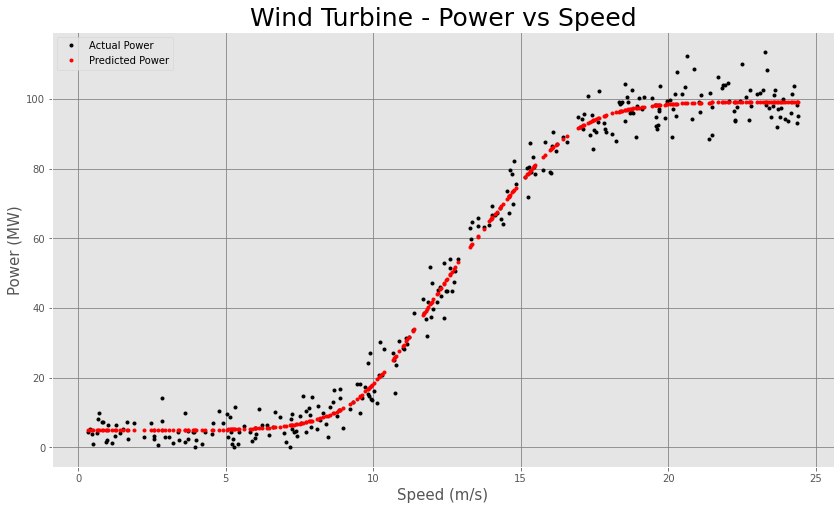

In [45]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

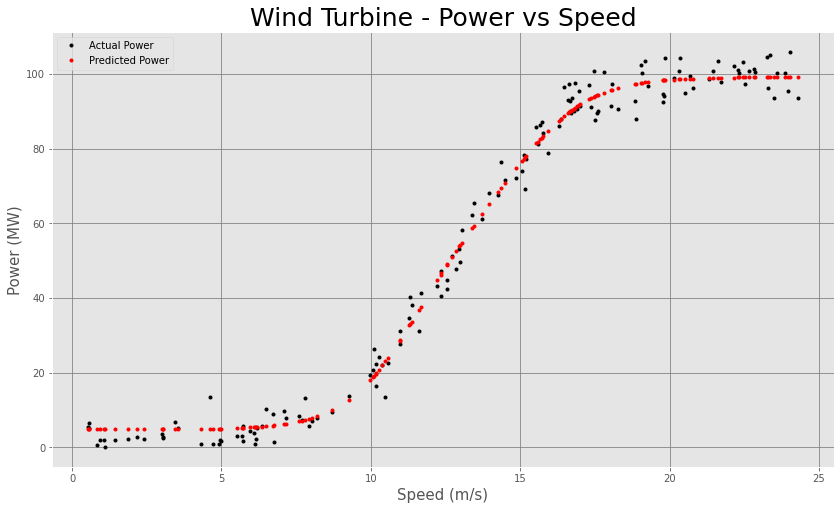

In [46]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [47]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 997us/step - loss: 14.7814


14.781423568725586

In [48]:
y_pred = model.predict(X_test)

In [49]:
y_test.shape = (-1,1)

In [50]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99091


### 5.4 - Test model consisting of: 3 neurons 5000 epochs, batch size=10

![3-neurons](Images/3-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Now, we will increase the model to 3 neurons in the hidden layer

In [51]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 2 neurons to 3 neurons
model.add(kr.layers.Dense(3, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [52]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 698us/step - loss: 4783.8771
Epoch 2/5000
31/31 [==============================] - 0s 798us/step - loss: 4962.6132
Epoch 3/5000
31/31 [==============================] - 0s 898us/step - loss: 4121.7380
Epoch 4/5000
31/31 [==============================] - 0s 898us/step - loss: 4491.8708
Epoch 5/5000
31/31 [==============================] - 0s 899us/step - loss: 4560.1715
Epoch 6/5000
31/31 [==============================] - 0s 831us/step - loss: 4576.2631
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 4204.5403
Epoch 8/5000
31/31 [==============================] - 0s 1ms/step - loss: 4337.5712
Epoch 9/5000
31/31 [==============================] - 0s 798us/step - loss: 4208.0391
Epoch 10/5000
31/31 [==============================] - 0s 1ms/step - loss: 4171.7916
Epoch 11/5000
31/31 [==============================] - 0s 964us/step - loss: 4321.2075
Epoch 12/5000
31/31 [==============================] - 0s 

31/31 [==============================] - 0s 898us/step - loss: 3523.1287
Epoch 96/5000
31/31 [==============================] - 0s 898us/step - loss: 3397.2549
Epoch 97/5000
31/31 [==============================] - 0s 930us/step - loss: 3332.8706
Epoch 98/5000
31/31 [==============================] - 0s 997us/step - loss: 3641.6707
Epoch 99/5000
31/31 [==============================] - 0s 931us/step - loss: 3453.2069
Epoch 100/5000
31/31 [==============================] - 0s 898us/step - loss: 3209.5990
Epoch 101/5000
31/31 [==============================] - 0s 864us/step - loss: 3475.2705
Epoch 102/5000
31/31 [==============================] - 0s 786us/step - loss: 3289.7706
Epoch 103/5000
31/31 [==============================] - 0s 845us/step - loss: 3138.7770
Epoch 104/5000
31/31 [==============================] - 0s 864us/step - loss: 3410.2991
Epoch 105/5000
31/31 [==============================] - 0s 781us/step - loss: 3298.3479
Epoch 106/5000
31/31 [=============================

31/31 [==============================] - 0s 898us/step - loss: 2959.2236
Epoch 189/5000
31/31 [==============================] - 0s 898us/step - loss: 2824.8394
Epoch 190/5000
31/31 [==============================] - 0s 965us/step - loss: 2933.0649
Epoch 191/5000
31/31 [==============================] - 0s 931us/step - loss: 2820.7959
Epoch 192/5000
31/31 [==============================] - 0s 931us/step - loss: 2705.9845
Epoch 193/5000
31/31 [==============================] - 0s 931us/step - loss: 2673.3613
Epoch 194/5000
31/31 [==============================] - 0s 898us/step - loss: 2774.8414
Epoch 195/5000
31/31 [==============================] - 0s 949us/step - loss: 2455.5813
Epoch 196/5000
31/31 [==============================] - 0s 965us/step - loss: 2693.6231
Epoch 197/5000
31/31 [==============================] - 0s 931us/step - loss: 2720.7901
Epoch 198/5000
31/31 [==============================] - 0s 854us/step - loss: 2937.0505
Epoch 199/5000
31/31 [=========================

31/31 [==============================] - 0s 931us/step - loss: 2047.9277
Epoch 282/5000
31/31 [==============================] - 0s 964us/step - loss: 2201.8678
Epoch 283/5000
31/31 [==============================] - 0s 931us/step - loss: 2390.1141
Epoch 284/5000
31/31 [==============================] - 0s 965us/step - loss: 2173.9397
Epoch 285/5000
31/31 [==============================] - 0s 965us/step - loss: 2229.3540
Epoch 286/5000
31/31 [==============================] - 0s 864us/step - loss: 2342.9182
Epoch 287/5000
31/31 [==============================] - 0s 963us/step - loss: 2318.9615
Epoch 288/5000
31/31 [==============================] - 0s 996us/step - loss: 2146.6098
Epoch 289/5000
31/31 [==============================] - 0s 1ms/step - loss: 2000.9026
Epoch 290/5000
31/31 [==============================] - 0s 1ms/step - loss: 2177.3456
Epoch 291/5000
31/31 [==============================] - 0s 813us/step - loss: 2138.5917
Epoch 292/5000
31/31 [=============================

31/31 [==============================] - 0s 943us/step - loss: 1812.1442
Epoch 375/5000
31/31 [==============================] - 0s 931us/step - loss: 1824.4144
Epoch 376/5000
31/31 [==============================] - 0s 964us/step - loss: 1630.4017
Epoch 377/5000
31/31 [==============================] - 0s 965us/step - loss: 1795.6475
Epoch 378/5000
31/31 [==============================] - 0s 997us/step - loss: 1672.4977
Epoch 379/5000
31/31 [==============================] - 0s 965us/step - loss: 1606.2464
Epoch 380/5000
31/31 [==============================] - 0s 832us/step - loss: 1708.6618
Epoch 381/5000
31/31 [==============================] - 0s 931us/step - loss: 1747.2270
Epoch 382/5000
31/31 [==============================] - 0s 831us/step - loss: 1768.0945
Epoch 383/5000
31/31 [==============================] - 0s 831us/step - loss: 1772.4910
Epoch 384/5000
31/31 [==============================] - 0s 997us/step - loss: 1496.6721
Epoch 385/5000
31/31 [=========================

31/31 [==============================] - 0s 931us/step - loss: 1380.1814
Epoch 468/5000
31/31 [==============================] - 0s 931us/step - loss: 1293.7107
Epoch 469/5000
31/31 [==============================] - 0s 932us/step - loss: 1191.4021
Epoch 470/5000
31/31 [==============================] - 0s 932us/step - loss: 1255.7841
Epoch 471/5000
31/31 [==============================] - 0s 958us/step - loss: 1248.9712
Epoch 472/5000
31/31 [==============================] - 0s 996us/step - loss: 1298.9764
Epoch 473/5000
31/31 [==============================] - 0s 882us/step - loss: 1100.1115
Epoch 474/5000
31/31 [==============================] - 0s 898us/step - loss: 1295.6604
Epoch 475/5000
31/31 [==============================] - 0s 919us/step - loss: 1144.5397
Epoch 476/5000
31/31 [==============================] - 0s 997us/step - loss: 1305.4581
Epoch 477/5000
31/31 [==============================] - 0s 931us/step - loss: 1217.3946
Epoch 478/5000
31/31 [=========================

31/31 [==============================] - 0s 898us/step - loss: 1003.1627
Epoch 561/5000
31/31 [==============================] - 0s 997us/step - loss: 1073.8030
Epoch 562/5000
31/31 [==============================] - 0s 930us/step - loss: 1047.2542
Epoch 563/5000
31/31 [==============================] - 0s 997us/step - loss: 993.8210
Epoch 564/5000
31/31 [==============================] - 0s 997us/step - loss: 1015.0995
Epoch 565/5000
31/31 [==============================] - 0s 931us/step - loss: 981.5053
Epoch 566/5000
31/31 [==============================] - 0s 863us/step - loss: 936.8766
Epoch 567/5000
31/31 [==============================] - 0s 997us/step - loss: 899.7434
Epoch 568/5000
31/31 [==============================] - 0s 931us/step - loss: 860.4411
Epoch 569/5000
31/31 [==============================] - 0s 964us/step - loss: 966.4299
Epoch 570/5000
31/31 [==============================] - 0s 951us/step - loss: 927.9998
Epoch 571/5000
31/31 [==============================] 

31/31 [==============================] - 0s 931us/step - loss: 702.3094
Epoch 655/5000
31/31 [==============================] - 0s 964us/step - loss: 715.7131
Epoch 656/5000
31/31 [==============================] - 0s 898us/step - loss: 633.6265
Epoch 657/5000
31/31 [==============================] - 0s 899us/step - loss: 606.8813
Epoch 658/5000
31/31 [==============================] - 0s 931us/step - loss: 613.2169
Epoch 659/5000
31/31 [==============================] - 0s 997us/step - loss: 697.0296
Epoch 660/5000
31/31 [==============================] - 0s 916us/step - loss: 595.3307
Epoch 661/5000
31/31 [==============================] - 0s 997us/step - loss: 646.9518
Epoch 662/5000
31/31 [==============================] - 0s 999us/step - loss: 596.5382
Epoch 663/5000
31/31 [==============================] - 0s 911us/step - loss: 637.5634
Epoch 664/5000
31/31 [==============================] - 0s 902us/step - loss: 661.2190
Epoch 665/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 866us/step - loss: 481.4217
Epoch 749/5000
31/31 [==============================] - 0s 1ms/step - loss: 370.1038
Epoch 750/5000
31/31 [==============================] - 0s 997us/step - loss: 430.9547
Epoch 751/5000
31/31 [==============================] - 0s 997us/step - loss: 458.9494
Epoch 752/5000
31/31 [==============================] - 0s 931us/step - loss: 443.4622
Epoch 753/5000
31/31 [==============================] - 0s 931us/step - loss: 446.2083
Epoch 754/5000
31/31 [==============================] - 0s 931us/step - loss: 456.1599
Epoch 755/5000
31/31 [==============================] - 0s 898us/step - loss: 433.7522
Epoch 756/5000
31/31 [==============================] - 0s 997us/step - loss: 413.7840
Epoch 757/5000
31/31 [==============================] - 0s 882us/step - loss: 446.4302
Epoch 758/5000
31/31 [==============================] - 0s 964us/step - loss: 408.6864
Epoch 759/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 852us/step - loss: 266.1037
Epoch 843/5000
31/31 [==============================] - 0s 909us/step - loss: 314.9919
Epoch 844/5000
31/31 [==============================] - 0s 871us/step - loss: 267.8862
Epoch 845/5000
31/31 [==============================] - 0s 899us/step - loss: 265.8548
Epoch 846/5000
31/31 [==============================] - 0s 964us/step - loss: 292.5722
Epoch 847/5000
31/31 [==============================] - 0s 931us/step - loss: 246.8324
Epoch 848/5000
31/31 [==============================] - 0s 931us/step - loss: 281.7838
Epoch 849/5000
31/31 [==============================] - 0s 1ms/step - loss: 267.6419
Epoch 850/5000
31/31 [==============================] - 0s 999us/step - loss: 262.3080
Epoch 851/5000
31/31 [==============================] - 0s 931us/step - loss: 280.7515
Epoch 852/5000
31/31 [==============================] - 0s 1ms/step - loss: 275.2620
Epoch 853/5000
31/31 [==============================] - 0s 850

31/31 [==============================] - 0s 931us/step - loss: 158.8914
Epoch 937/5000
31/31 [==============================] - 0s 931us/step - loss: 152.2430
Epoch 938/5000
31/31 [==============================] - 0s 932us/step - loss: 153.8002
Epoch 939/5000
31/31 [==============================] - 0s 933us/step - loss: 143.5604
Epoch 940/5000
31/31 [==============================] - 0s 964us/step - loss: 175.4428
Epoch 941/5000
31/31 [==============================] - 0s 880us/step - loss: 153.2921
Epoch 942/5000
31/31 [==============================] - 0s 897us/step - loss: 157.0158
Epoch 943/5000
31/31 [==============================] - 0s 965us/step - loss: 157.0620
Epoch 944/5000
31/31 [==============================] - 0s 931us/step - loss: 141.3264
Epoch 945/5000
31/31 [==============================] - 0s 931us/step - loss: 126.3806
Epoch 946/5000
31/31 [==============================] - 0s 898us/step - loss: 121.2948
Epoch 947/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 93.8316
Epoch 1031/5000
31/31 [==============================] - 0s 930us/step - loss: 87.4401
Epoch 1032/5000
31/31 [==============================] - 0s 824us/step - loss: 76.0165
Epoch 1033/5000
31/31 [==============================] - 0s 964us/step - loss: 74.8025
Epoch 1034/5000
31/31 [==============================] - 0s 866us/step - loss: 78.8835
Epoch 1035/5000
31/31 [==============================] - 0s 887us/step - loss: 80.1561
Epoch 1036/5000
31/31 [==============================] - 0s 865us/step - loss: 76.1949
Epoch 1037/5000
31/31 [==============================] - 0s 932us/step - loss: 77.4309
Epoch 1038/5000
31/31 [==============================] - 0s 898us/step - loss: 81.1623
Epoch 1039/5000
31/31 [==============================] - 0s 808us/step - loss: 76.2836
Epoch 1040/5000
31/31 [==============================] - 0s 932us/step - loss: 66.6502
Epoch 1041/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 932us/step - loss: 43.7933
Epoch 1125/5000
31/31 [==============================] - 0s 898us/step - loss: 41.8219
Epoch 1126/5000
31/31 [==============================] - 0s 997us/step - loss: 37.0652
Epoch 1127/5000
31/31 [==============================] - 0s 1ms/step - loss: 37.5192
Epoch 1128/5000
31/31 [==============================] - 0s 964us/step - loss: 37.4542
Epoch 1129/5000
31/31 [==============================] - 0s 866us/step - loss: 37.8894
Epoch 1130/5000
31/31 [==============================] - 0s 964us/step - loss: 43.9026
Epoch 1131/5000
31/31 [==============================] - 0s 864us/step - loss: 34.0902
Epoch 1132/5000
31/31 [==============================] - 0s 932us/step - loss: 39.2140
Epoch 1133/5000
31/31 [==============================] - 0s 964us/step - loss: 32.1232
Epoch 1134/5000
31/31 [==============================] - 0s 997us/step - loss: 37.6003
Epoch 1135/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 964us/step - loss: 24.4410
Epoch 1219/5000
31/31 [==============================] - 0s 997us/step - loss: 20.3667
Epoch 1220/5000
31/31 [==============================] - 0s 898us/step - loss: 22.3079
Epoch 1221/5000
31/31 [==============================] - 0s 931us/step - loss: 24.4923
Epoch 1222/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.8846
Epoch 1223/5000
31/31 [==============================] - 0s 931us/step - loss: 20.5232
Epoch 1224/5000
31/31 [==============================] - 0s 864us/step - loss: 22.5098
Epoch 1225/5000
31/31 [==============================] - 0s 964us/step - loss: 22.0376
Epoch 1226/5000
31/31 [==============================] - 0s 964us/step - loss: 20.0598
Epoch 1227/5000
31/31 [==============================] - 0s 997us/step - loss: 21.6146
Epoch 1228/5000
31/31 [==============================] - 0s 1ms/step - loss: 22.9340
Epoch 1229/5000
31/31 [==============================] - 0s 970

31/31 [==============================] - 0s 931us/step - loss: 19.5881
Epoch 1313/5000
31/31 [==============================] - 0s 833us/step - loss: 19.1604
Epoch 1314/5000
31/31 [==============================] - 0s 931us/step - loss: 17.3145
Epoch 1315/5000
31/31 [==============================] - 0s 864us/step - loss: 18.4541
Epoch 1316/5000
31/31 [==============================] - 0s 864us/step - loss: 17.6340
Epoch 1317/5000
31/31 [==============================] - 0s 898us/step - loss: 18.9852
Epoch 1318/5000
31/31 [==============================] - 0s 919us/step - loss: 17.4754
Epoch 1319/5000
31/31 [==============================] - 0s 859us/step - loss: 19.0326
Epoch 1320/5000
31/31 [==============================] - 0s 899us/step - loss: 18.0753
Epoch 1321/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8675
Epoch 1322/5000
31/31 [==============================] - 0s 964us/step - loss: 19.6830
Epoch 1323/5000
31/31 [==============================] - 0s 7

31/31 [==============================] - 0s 898us/step - loss: 16.9095
Epoch 1407/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7776
Epoch 1408/5000
31/31 [==============================] - 0s 831us/step - loss: 18.2847
Epoch 1409/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0966
Epoch 1410/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0471
Epoch 1411/5000
31/31 [==============================] - 0s 931us/step - loss: 20.5055
Epoch 1412/5000
31/31 [==============================] - 0s 898us/step - loss: 16.3719
Epoch 1413/5000
31/31 [==============================] - 0s 855us/step - loss: 20.9377
Epoch 1414/5000
31/31 [==============================] - 0s 999us/step - loss: 18.4262
Epoch 1415/5000
31/31 [==============================] - 0s 932us/step - loss: 18.3806
Epoch 1416/5000
31/31 [==============================] - 0s 898us/step - loss: 19.4274
Epoch 1417/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 16.5690
Epoch 1501/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1366
Epoch 1502/5000
31/31 [==============================] - 0s 931us/step - loss: 20.9144
Epoch 1503/5000
31/31 [==============================] - 0s 865us/step - loss: 19.3057
Epoch 1504/5000
31/31 [==============================] - 0s 830us/step - loss: 16.9561
Epoch 1505/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0088
Epoch 1506/5000
31/31 [==============================] - 0s 831us/step - loss: 17.9920
Epoch 1507/5000
31/31 [==============================] - 0s 864us/step - loss: 17.3794
Epoch 1508/5000
31/31 [==============================] - 0s 997us/step - loss: 17.6071
Epoch 1509/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3082
Epoch 1510/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1598
Epoch 1511/5000
31/31 [==============================] - 0s 965

31/31 [==============================] - 0s 931us/step - loss: 16.1372
Epoch 1595/5000
31/31 [==============================] - 0s 864us/step - loss: 17.5150
Epoch 1596/5000
31/31 [==============================] - 0s 946us/step - loss: 16.0058
Epoch 1597/5000
31/31 [==============================] - 0s 807us/step - loss: 15.9659
Epoch 1598/5000
31/31 [==============================] - 0s 898us/step - loss: 17.6182
Epoch 1599/5000
31/31 [==============================] - 0s 851us/step - loss: 20.0807
Epoch 1600/5000
31/31 [==============================] - 0s 931us/step - loss: 15.9337
Epoch 1601/5000
31/31 [==============================] - 0s 858us/step - loss: 14.5005
Epoch 1602/5000
31/31 [==============================] - 0s 851us/step - loss: 18.8694
Epoch 1603/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6843
Epoch 1604/5000
31/31 [==============================] - 0s 932us/step - loss: 19.7371
Epoch 1605/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 898us/step - loss: 18.0601
Epoch 1689/5000
31/31 [==============================] - 0s 899us/step - loss: 19.0627
Epoch 1690/5000
31/31 [==============================] - 0s 919us/step - loss: 18.9665
Epoch 1691/5000
31/31 [==============================] - 0s 909us/step - loss: 16.4672
Epoch 1692/5000
31/31 [==============================] - 0s 997us/step - loss: 19.1048
Epoch 1693/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9152
Epoch 1694/5000
31/31 [==============================] - 0s 956us/step - loss: 15.9512
Epoch 1695/5000
31/31 [==============================] - 0s 850us/step - loss: 15.9355
Epoch 1696/5000
31/31 [==============================] - 0s 781us/step - loss: 19.2770
Epoch 1697/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3645
Epoch 1698/5000
31/31 [==============================] - 0s 831us/step - loss: 16.5988
Epoch 1699/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 18.3923
Epoch 1783/5000
31/31 [==============================] - 0s 898us/step - loss: 16.2658
Epoch 1784/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4756
Epoch 1785/5000
31/31 [==============================] - 0s 965us/step - loss: 15.0812
Epoch 1786/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1044
Epoch 1787/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.7449
Epoch 1788/5000
31/31 [==============================] - 0s 964us/step - loss: 17.6370
Epoch 1789/5000
31/31 [==============================] - 0s 898us/step - loss: 16.4497
Epoch 1790/5000
31/31 [==============================] - 0s 898us/step - loss: 15.3350
Epoch 1791/5000
31/31 [==============================] - 0s 864us/step - loss: 18.5328
Epoch 1792/5000
31/31 [==============================] - 0s 832us/step - loss: 20.1209
Epoch 1793/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 955us/step - loss: 16.7292
Epoch 1877/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3754
Epoch 1878/5000
31/31 [==============================] - 0s 964us/step - loss: 18.4396
Epoch 1879/5000
31/31 [==============================] - 0s 951us/step - loss: 18.1933
Epoch 1880/5000
31/31 [==============================] - 0s 917us/step - loss: 15.4353
Epoch 1881/5000
31/31 [==============================] - 0s 798us/step - loss: 19.4870
Epoch 1882/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9409
Epoch 1883/5000
31/31 [==============================] - 0s 819us/step - loss: 18.8019
Epoch 1884/5000
31/31 [==============================] - 0s 997us/step - loss: 17.1550
Epoch 1885/5000
31/31 [==============================] - 0s 965us/step - loss: 19.9917
Epoch 1886/5000
31/31 [==============================] - 0s 854us/step - loss: 16.5258
Epoch 1887/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 17.4597
Epoch 1972/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.4198
Epoch 1973/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.2906
Epoch 1974/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8622
Epoch 1975/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0571
Epoch 1976/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1862
Epoch 1977/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3556
Epoch 1978/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6531
Epoch 1979/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7290
Epoch 1980/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7450
Epoch 1981/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.2807
Epoch 1982/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.4

31/31 [==============================] - 0s 898us/step - loss: 19.9629
Epoch 2067/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6993
Epoch 2068/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3323
Epoch 2069/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9809
Epoch 2070/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5261
Epoch 2071/5000
31/31 [==============================] - 0s 1ms/step - loss: 13.3032
Epoch 2072/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.0546
Epoch 2073/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6051
Epoch 2074/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9334
Epoch 2075/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.2823
Epoch 2076/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6077
Epoch 2077/5000
31/31 [==============================] - 0s 1ms/step - loss: 

31/31 [==============================] - 0s 863us/step - loss: 17.5391
Epoch 2162/5000
31/31 [==============================] - 0s 932us/step - loss: 18.1275
Epoch 2163/5000
31/31 [==============================] - 0s 997us/step - loss: 18.2382
Epoch 2164/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.7774
Epoch 2165/5000
31/31 [==============================] - 0s 854us/step - loss: 16.9008
Epoch 2166/5000
31/31 [==============================] - 0s 901us/step - loss: 18.8589
Epoch 2167/5000
31/31 [==============================] - 0s 928us/step - loss: 17.6713
Epoch 2168/5000
31/31 [==============================] - 0s 831us/step - loss: 18.6417
Epoch 2169/5000
31/31 [==============================] - 0s 864us/step - loss: 15.8563
Epoch 2170/5000
31/31 [==============================] - 0s 931us/step - loss: 19.4752
Epoch 2171/5000
31/31 [==============================] - 0s 931us/step - loss: 15.6199
Epoch 2172/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 1ms/step - loss: 17.0432
Epoch 2257/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2515
Epoch 2258/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1372
Epoch 2259/5000
31/31 [==============================] - 0s 950us/step - loss: 18.3693
Epoch 2260/5000
31/31 [==============================] - 0s 852us/step - loss: 17.3558
Epoch 2261/5000
31/31 [==============================] - 0s 924us/step - loss: 17.0123
Epoch 2262/5000
31/31 [==============================] - 0s 899us/step - loss: 14.6858
Epoch 2263/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9333
Epoch 2264/5000
31/31 [==============================] - 0s 898us/step - loss: 18.2150
Epoch 2265/5000
31/31 [==============================] - 0s 952us/step - loss: 19.4126
Epoch 2266/5000
31/31 [==============================] - 0s 841us/step - loss: 17.0498
Epoch 2267/5000
31/31 [==============================] - 0s 839us/s

31/31 [==============================] - 0s 1ms/step - loss: 17.8792
Epoch 2352/5000
31/31 [==============================] - 0s 2ms/step - loss: 15.3722
Epoch 2353/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5308
Epoch 2354/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2693
Epoch 2355/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2259
Epoch 2356/5000
31/31 [==============================] - 0s 930us/step - loss: 17.5015
Epoch 2357/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7236
Epoch 2358/5000
31/31 [==============================] - 0s 964us/step - loss: 19.2227
Epoch 2359/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7760
Epoch 2360/5000
31/31 [==============================] - 0s 897us/step - loss: 15.2120
Epoch 2361/5000
31/31 [==============================] - 0s 931us/step - loss: 16.6406
Epoch 2362/5000
31/31 [==============================] - 0s 866us/step - 

Epoch 2446/5000
31/31 [==============================] - 0s 997us/step - loss: 16.1593
Epoch 2447/5000
31/31 [==============================] - 0s 896us/step - loss: 14.7816
Epoch 2448/5000
31/31 [==============================] - 0s 864us/step - loss: 18.6153
Epoch 2449/5000
31/31 [==============================] - 0s 931us/step - loss: 15.0922
Epoch 2450/5000
31/31 [==============================] - 0s 865us/step - loss: 17.0239
Epoch 2451/5000
31/31 [==============================] - 0s 931us/step - loss: 16.6573
Epoch 2452/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7224
Epoch 2453/5000
31/31 [==============================] - 0s 864us/step - loss: 14.2573
Epoch 2454/5000
31/31 [==============================] - 0s 831us/step - loss: 17.2264
Epoch 2455/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2169
Epoch 2456/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6592
Epoch 2457/5000
31/31 [========================

31/31 [==============================] - 0s 1ms/step - loss: 17.6521
Epoch 2541/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.3107
Epoch 2542/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.4812
Epoch 2543/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9085
Epoch 2544/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.0492
Epoch 2545/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7279
Epoch 2546/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.9706
Epoch 2547/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0214
Epoch 2548/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8090
Epoch 2549/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2097
Epoch 2550/5000
31/31 [==============================] - 0s 800us/step - loss: 18.4179
Epoch 2551/5000
31/31 [==============================] - 0s 998us/step - loss

31/31 [==============================] - 0s 1ms/step - loss: 16.6996
Epoch 2636/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.9742
Epoch 2637/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3813
Epoch 2638/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6032
Epoch 2639/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4364
Epoch 2640/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0414
Epoch 2641/5000
31/31 [==============================] - 0s 898us/step - loss: 15.7531
Epoch 2642/5000
31/31 [==============================] - 0s 898us/step - loss: 18.3063
Epoch 2643/5000
31/31 [==============================] - 0s 997us/step - loss: 17.8587
Epoch 2644/5000
31/31 [==============================] - 0s 964us/step - loss: 15.9090
Epoch 2645/5000
31/31 [==============================] - 0s 829us/step - loss: 16.4573
Epoch 2646/5000
31/31 [==============================] - 0s 931us/step 

31/31 [==============================] - 0s 898us/step - loss: 16.7054
Epoch 2730/5000
31/31 [==============================] - 0s 997us/step - loss: 16.5977
Epoch 2731/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.7321
Epoch 2732/5000
31/31 [==============================] - 0s 997us/step - loss: 17.7902
Epoch 2733/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9511
Epoch 2734/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0965
Epoch 2735/5000
31/31 [==============================] - 0s 2ms/step - loss: 16.6382
Epoch 2736/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.2288
Epoch 2737/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5127
Epoch 2738/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.0886
Epoch 2739/5000
31/31 [==============================] - 0s 2ms/step - loss: 17.1980
Epoch 2740/5000
31/31 [==============================] - 0s 2ms/step - loss

31/31 [==============================] - 0s 1ms/step - loss: 16.4744
Epoch 2825/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6059
Epoch 2826/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.0650
Epoch 2827/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7061
Epoch 2828/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.2395
Epoch 2829/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6106
Epoch 2830/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9785
Epoch 2831/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6420
Epoch 2832/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3204
Epoch 2833/5000
31/31 [==============================] - 0s 997us/step - loss: 17.7970
Epoch 2834/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3797
Epoch 2835/5000
31/31 [==============================] - 0s 930us/step - loss

31/31 [==============================] - 0s 1ms/step - loss: 19.4316
Epoch 2920/5000
31/31 [==============================] - 0s 931us/step - loss: 15.0347
Epoch 2921/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2907
Epoch 2922/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0141
Epoch 2923/5000
31/31 [==============================] - 0s 919us/step - loss: 17.1186
Epoch 2924/5000
31/31 [==============================] - 0s 888us/step - loss: 19.5194
Epoch 2925/5000
31/31 [==============================] - 0s 858us/step - loss: 19.5377
Epoch 2926/5000
31/31 [==============================] - 0s 896us/step - loss: 16.9865
Epoch 2927/5000
31/31 [==============================] - 0s 931us/step - loss: 20.3233
Epoch 2928/5000
31/31 [==============================] - 0s 831us/step - loss: 16.4209
Epoch 2929/5000
31/31 [==============================] - 0s 827us/step - loss: 16.8048
Epoch 2930/5000
31/31 [==============================] - 0s 841

31/31 [==============================] - 0s 1ms/step - loss: 19.2096
Epoch 3015/5000
31/31 [==============================] - 0s 2ms/step - loss: 16.2954
Epoch 3016/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1008
Epoch 3017/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5035
Epoch 3018/5000
31/31 [==============================] - 0s 978us/step - loss: 16.7835
Epoch 3019/5000
31/31 [==============================] - 0s 854us/step - loss: 16.0103
Epoch 3020/5000
31/31 [==============================] - 0s 796us/step - loss: 17.0516
Epoch 3021/5000
31/31 [==============================] - 0s 997us/step - loss: 19.8526
Epoch 3022/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3799
Epoch 3023/5000
31/31 [==============================] - 0s 963us/step - loss: 17.5881
Epoch 3024/5000
31/31 [==============================] - 0s 898us/step - loss: 15.7005
Epoch 3025/5000
31/31 [==============================] - 0s 891us/s

31/31 [==============================] - 0s 999us/step - loss: 15.5126
Epoch 3110/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6361
Epoch 3111/5000
31/31 [==============================] - 0s 931us/step - loss: 15.7404
Epoch 3112/5000
31/31 [==============================] - 0s 898us/step - loss: 16.2266
Epoch 3113/5000
31/31 [==============================] - 0s 899us/step - loss: 18.2838
Epoch 3114/5000
31/31 [==============================] - 0s 898us/step - loss: 21.1985
Epoch 3115/5000
31/31 [==============================] - 0s 964us/step - loss: 18.8887
Epoch 3116/5000
31/31 [==============================] - 0s 932us/step - loss: 15.3327
Epoch 3117/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9423
Epoch 3118/5000
31/31 [==============================] - 0s 866us/step - loss: 15.2689
Epoch 3119/5000
31/31 [==============================] - 0s 854us/step - loss: 16.7300
Epoch 3120/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 1ms/step - loss: 18.2849
Epoch 3205/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8305
Epoch 3206/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5332
Epoch 3207/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9995
Epoch 3208/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0962
Epoch 3209/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3917
Epoch 3210/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9057
Epoch 3211/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6533
Epoch 3212/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5643
Epoch 3213/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.8170
Epoch 3214/5000
31/31 [==============================] - 0s 917us/step - loss: 19.4563
Epoch 3215/5000
31/31 [==============================] - 0s 964us/step - loss: 

31/31 [==============================] - 0s 966us/step - loss: 18.4934
Epoch 3300/5000
31/31 [==============================] - 0s 898us/step - loss: 16.6046
Epoch 3301/5000
31/31 [==============================] - 0s 964us/step - loss: 19.1884
Epoch 3302/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0108
Epoch 3303/5000
31/31 [==============================] - 0s 930us/step - loss: 17.9204
Epoch 3304/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.9352
Epoch 3305/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6373
Epoch 3306/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5022
Epoch 3307/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5406
Epoch 3308/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6908
Epoch 3309/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.6486
Epoch 3310/5000
31/31 [==============================] - 0s 1ms/step - 

31/31 [==============================] - 0s 1ms/step - loss: 16.9107
Epoch 3395/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1667
Epoch 3396/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9554
Epoch 3397/5000
31/31 [==============================] - 0s 997us/step - loss: 16.5512
Epoch 3398/5000
31/31 [==============================] - 0s 958us/step - loss: 17.5605
Epoch 3399/5000
31/31 [==============================] - 0s 964us/step - loss: 19.8814
Epoch 3400/5000
31/31 [==============================] - 0s 964us/step - loss: 19.6599
Epoch 3401/5000
31/31 [==============================] - 0s 964us/step - loss: 17.5223
Epoch 3402/5000
31/31 [==============================] - 0s 931us/step - loss: 17.8350
Epoch 3403/5000
31/31 [==============================] - 0s 897us/step - loss: 17.5117
Epoch 3404/5000
31/31 [==============================] - 0s 966us/step - loss: 16.6273
Epoch 3405/5000
31/31 [==============================] - 0s 1ms/s

31/31 [==============================] - 0s 1ms/step - loss: 16.6457
Epoch 3490/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5053
Epoch 3491/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3469
Epoch 3492/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8424
Epoch 3493/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5660
Epoch 3494/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9021
Epoch 3495/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.6583
Epoch 3496/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5589
Epoch 3497/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.0538
Epoch 3498/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1313
Epoch 3499/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6919
Epoch 3500/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3

31/31 [==============================] - 0s 931us/step - loss: 18.5653
Epoch 3584/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0084
Epoch 3585/5000
31/31 [==============================] - 0s 898us/step - loss: 16.4634
Epoch 3586/5000
31/31 [==============================] - 0s 803us/step - loss: 18.7619
Epoch 3587/5000
31/31 [==============================] - 0s 997us/step - loss: 21.1977
Epoch 3588/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.5388
Epoch 3589/5000
31/31 [==============================] - 0s 964us/step - loss: 18.4120
Epoch 3590/5000
31/31 [==============================] - 0s 864us/step - loss: 16.8939
Epoch 3591/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7032
Epoch 3592/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2022
Epoch 3593/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9868
Epoch 3594/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 964us/step - loss: 18.3502
Epoch 3678/5000
31/31 [==============================] - 0s 923us/step - loss: 17.1590
Epoch 3679/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6362
Epoch 3680/5000
31/31 [==============================] - 0s 965us/step - loss: 20.9728
Epoch 3681/5000
31/31 [==============================] - 0s 964us/step - loss: 17.9067
Epoch 3682/5000
31/31 [==============================] - 0s 897us/step - loss: 16.6160
Epoch 3683/5000
31/31 [==============================] - 0s 965us/step - loss: 19.7420
Epoch 3684/5000
31/31 [==============================] - 0s 898us/step - loss: 16.5182
Epoch 3685/5000
31/31 [==============================] - 0s 864us/step - loss: 16.1262
Epoch 3686/5000
31/31 [==============================] - 0s 862us/step - loss: 17.4378
Epoch 3687/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6591
Epoch 3688/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 16.4756
Epoch 3772/5000
31/31 [==============================] - 0s 997us/step - loss: 18.2522
Epoch 3773/5000
31/31 [==============================] - 0s 997us/step - loss: 17.6576
Epoch 3774/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3799
Epoch 3775/5000
31/31 [==============================] - 0s 898us/step - loss: 18.0714
Epoch 3776/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5262
Epoch 3777/5000
31/31 [==============================] - 0s 864us/step - loss: 18.4684
Epoch 3778/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2394
Epoch 3779/5000
31/31 [==============================] - 0s 960us/step - loss: 20.1937
Epoch 3780/5000
31/31 [==============================] - 0s 892us/step - loss: 18.3690
Epoch 3781/5000
31/31 [==============================] - 0s 899us/step - loss: 18.1979
Epoch 3782/5000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 898us/step - loss: 18.2149
Epoch 3866/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4979
Epoch 3867/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2886
Epoch 3868/5000
31/31 [==============================] - 0s 997us/step - loss: 16.7640
Epoch 3869/5000
31/31 [==============================] - 0s 964us/step - loss: 18.4908
Epoch 3870/5000
31/31 [==============================] - 0s 864us/step - loss: 19.0766
Epoch 3871/5000
31/31 [==============================] - 0s 813us/step - loss: 19.3678
Epoch 3872/5000
31/31 [==============================] - 0s 883us/step - loss: 17.9988
Epoch 3873/5000
31/31 [==============================] - 0s 999us/step - loss: 18.2442
Epoch 3874/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0699
Epoch 3875/5000
31/31 [==============================] - 0s 965us/step - loss: 15.6253
Epoch 3876/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 16.5329
Epoch 3960/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7930
Epoch 3961/5000
31/31 [==============================] - 0s 964us/step - loss: 16.1871
Epoch 3962/5000
31/31 [==============================] - 0s 882us/step - loss: 16.3935
Epoch 3963/5000
31/31 [==============================] - 0s 951us/step - loss: 17.3989
Epoch 3964/5000
31/31 [==============================] - 0s 898us/step - loss: 15.6837
Epoch 3965/5000
31/31 [==============================] - 0s 963us/step - loss: 16.0632
Epoch 3966/5000
31/31 [==============================] - 0s 830us/step - loss: 18.1415
Epoch 3967/5000
31/31 [==============================] - 0s 887us/step - loss: 18.2289
Epoch 3968/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7058
Epoch 3969/5000
31/31 [==============================] - 0s 999us/step - loss: 16.7236
Epoch 3970/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 931us/step - loss: 18.2456
Epoch 4054/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3300
Epoch 4055/5000
31/31 [==============================] - 0s 997us/step - loss: 15.9743
Epoch 4056/5000
31/31 [==============================] - 0s 964us/step - loss: 19.0827
Epoch 4057/5000
31/31 [==============================] - 0s 887us/step - loss: 17.2928
Epoch 4058/5000
31/31 [==============================] - 0s 998us/step - loss: 17.0492
Epoch 4059/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.7190
Epoch 4060/5000
31/31 [==============================] - 0s 931us/step - loss: 15.9869
Epoch 4061/5000
31/31 [==============================] - 0s 866us/step - loss: 14.2034
Epoch 4062/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3243
Epoch 4063/5000
31/31 [==============================] - 0s 932us/step - loss: 18.9190
Epoch 4064/5000
31/31 [==============================] - 0s 997us

31/31 [==============================] - 0s 997us/step - loss: 16.7498
Epoch 4148/5000
31/31 [==============================] - 0s 997us/step - loss: 18.0210
Epoch 4149/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0690
Epoch 4150/5000
31/31 [==============================] - 0s 996us/step - loss: 18.2947
Epoch 4151/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5284
Epoch 4152/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3505
Epoch 4153/5000
31/31 [==============================] - 0s 965us/step - loss: 16.6083
Epoch 4154/5000
31/31 [==============================] - 0s 786us/step - loss: 16.0937
Epoch 4155/5000
31/31 [==============================] - 0s 967us/step - loss: 19.7697
Epoch 4156/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4919
Epoch 4157/5000
31/31 [==============================] - 0s 899us/step - loss: 17.0499
Epoch 4158/5000
31/31 [==============================] - 0s 965

31/31 [==============================] - 0s 964us/step - loss: 15.8019
Epoch 4242/5000
31/31 [==============================] - 0s 963us/step - loss: 18.2885
Epoch 4243/5000
31/31 [==============================] - 0s 963us/step - loss: 17.3628
Epoch 4244/5000
31/31 [==============================] - 0s 829us/step - loss: 17.1218
Epoch 4245/5000
31/31 [==============================] - 0s 997us/step - loss: 15.6898
Epoch 4246/5000
31/31 [==============================] - 0s 964us/step - loss: 17.6115
Epoch 4247/5000
31/31 [==============================] - 0s 874us/step - loss: 16.4494
Epoch 4248/5000
31/31 [==============================] - 0s 997us/step - loss: 17.9029
Epoch 4249/5000
31/31 [==============================] - 0s 999us/step - loss: 18.5138
Epoch 4250/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.3582
Epoch 4251/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.9920
Epoch 4252/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 931us/step - loss: 17.1803
Epoch 4336/5000
31/31 [==============================] - 0s 931us/step - loss: 18.1267
Epoch 4337/5000
31/31 [==============================] - 0s 997us/step - loss: 17.6260
Epoch 4338/5000
31/31 [==============================] - 0s 962us/step - loss: 15.7452
Epoch 4339/5000
31/31 [==============================] - 0s 927us/step - loss: 17.4934
Epoch 4340/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6471
Epoch 4341/5000
31/31 [==============================] - 0s 857us/step - loss: 16.7670
Epoch 4342/5000
31/31 [==============================] - 0s 832us/step - loss: 20.8362
Epoch 4343/5000
31/31 [==============================] - 0s 997us/step - loss: 18.5089
Epoch 4344/5000
31/31 [==============================] - 0s 964us/step - loss: 17.5623
Epoch 4345/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4104
Epoch 4346/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 932us/step - loss: 18.4069
Epoch 4430/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3890
Epoch 4431/5000
31/31 [==============================] - 0s 997us/step - loss: 16.0444
Epoch 4432/5000
31/31 [==============================] - 0s 997us/step - loss: 17.1361
Epoch 4433/5000
31/31 [==============================] - 0s 997us/step - loss: 20.2754
Epoch 4434/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.6144
Epoch 4435/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.3229
Epoch 4436/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3076
Epoch 4437/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3398
Epoch 4438/5000
31/31 [==============================] - 0s 852us/step - loss: 20.7789
Epoch 4439/5000
31/31 [==============================] - 0s 880us/step - loss: 18.8131
Epoch 4440/5000
31/31 [==============================] - 0s 902

31/31 [==============================] - 0s 931us/step - loss: 17.5199
Epoch 4524/5000
31/31 [==============================] - 0s 962us/step - loss: 16.1974
Epoch 4525/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9488
Epoch 4526/5000
31/31 [==============================] - 0s 997us/step - loss: 16.8341
Epoch 4527/5000
31/31 [==============================] - 0s 964us/step - loss: 14.5807
Epoch 4528/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.1514
Epoch 4529/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.6256
Epoch 4530/5000
31/31 [==============================] - 0s 997us/step - loss: 17.5348
Epoch 4531/5000
31/31 [==============================] - 0s 931us/step - loss: 19.7904
Epoch 4532/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.4044
Epoch 4533/5000
31/31 [==============================] - 0s 931us/step - loss: 14.6101
Epoch 4534/5000
31/31 [==============================] - 0s 1ms/s

31/31 [==============================] - 0s 866us/step - loss: 19.1830
Epoch 4618/5000
31/31 [==============================] - 0s 997us/step - loss: 18.8199
Epoch 4619/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.3909
Epoch 4620/5000
31/31 [==============================] - 0s 997us/step - loss: 17.7760
Epoch 4621/5000
31/31 [==============================] - 0s 899us/step - loss: 19.4710
Epoch 4622/5000
31/31 [==============================] - 0s 930us/step - loss: 17.0571
Epoch 4623/5000
31/31 [==============================] - 0s 898us/step - loss: 18.0851
Epoch 4624/5000
31/31 [==============================] - 0s 931us/step - loss: 16.8650
Epoch 4625/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2603
Epoch 4626/5000
31/31 [==============================] - 0s 832us/step - loss: 18.1198
Epoch 4627/5000
31/31 [==============================] - 0s 896us/step - loss: 18.9337
Epoch 4628/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 1ms/step - loss: 16.6308
Epoch 4712/5000
31/31 [==============================] - 0s 899us/step - loss: 18.7106
Epoch 4713/5000
31/31 [==============================] - 0s 867us/step - loss: 17.5579
Epoch 4714/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1992
Epoch 4715/5000
31/31 [==============================] - 0s 931us/step - loss: 16.7645
Epoch 4716/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8509
Epoch 4717/5000
31/31 [==============================] - 0s 831us/step - loss: 16.6944
Epoch 4718/5000
31/31 [==============================] - 0s 786us/step - loss: 19.4947
Epoch 4719/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3218
Epoch 4720/5000
31/31 [==============================] - 0s 964us/step - loss: 19.4965
Epoch 4721/5000
31/31 [==============================] - 0s 898us/step - loss: 18.4047
Epoch 4722/5000
31/31 [==============================] - 0s 997

31/31 [==============================] - 0s 931us/step - loss: 16.2044
Epoch 4806/5000
31/31 [==============================] - 0s 898us/step - loss: 16.9162
Epoch 4807/5000
31/31 [==============================] - 0s 997us/step - loss: 14.9970
Epoch 4808/5000
31/31 [==============================] - 0s 1ms/step - loss: 21.1070
Epoch 4809/5000
31/31 [==============================] - 0s 931us/step - loss: 19.6305
Epoch 4810/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6833
Epoch 4811/5000
31/31 [==============================] - 0s 898us/step - loss: 16.8331
Epoch 4812/5000
31/31 [==============================] - 0s 830us/step - loss: 15.3736
Epoch 4813/5000
31/31 [==============================] - 0s 964us/step - loss: 15.6873
Epoch 4814/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4346
Epoch 4815/5000
31/31 [==============================] - 0s 919us/step - loss: 18.3391
Epoch 4816/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 932us/step - loss: 18.8470
Epoch 4900/5000
31/31 [==============================] - 0s 931us/step - loss: 18.9397
Epoch 4901/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.7532
Epoch 4902/5000
31/31 [==============================] - 0s 964us/step - loss: 13.4489
Epoch 4903/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2643
Epoch 4904/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8642
Epoch 4905/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2844
Epoch 4906/5000
31/31 [==============================] - 0s 952us/step - loss: 17.1672
Epoch 4907/5000
31/31 [==============================] - 0s 932us/step - loss: 17.8068
Epoch 4908/5000
31/31 [==============================] - 0s 896us/step - loss: 17.4188
Epoch 4909/5000
31/31 [==============================] - 0s 997us/step - loss: 16.9515
Epoch 4910/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 965us/step - loss: 17.0978
Epoch 4994/5000
31/31 [==============================] - 0s 931us/step - loss: 18.8297
Epoch 4995/5000
31/31 [==============================] - 0s 898us/step - loss: 16.3034
Epoch 4996/5000
31/31 [==============================] - 0s 791us/step - loss: 16.9110
Epoch 4997/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2195
Epoch 4998/5000
31/31 [==============================] - 0s 964us/step - loss: 16.4785
Epoch 4999/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1750
Epoch 5000/5000
31/31 [==============================] - 0s 998us/step - loss: 19.8452


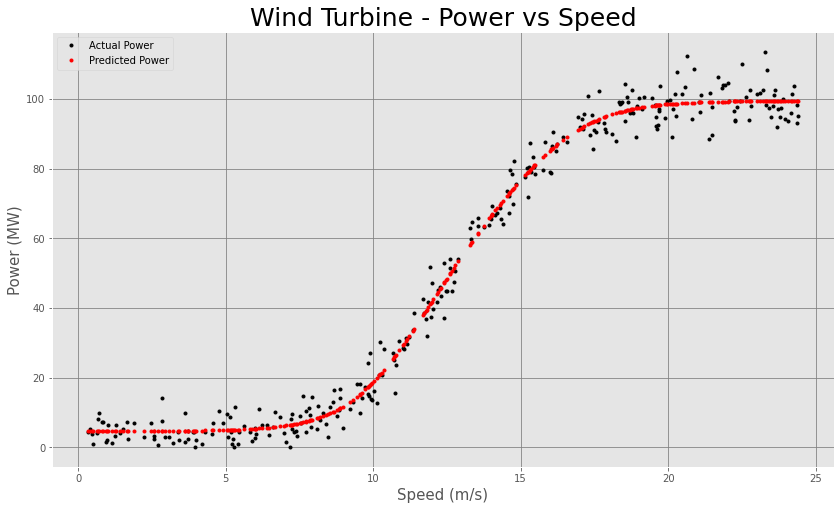

In [53]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

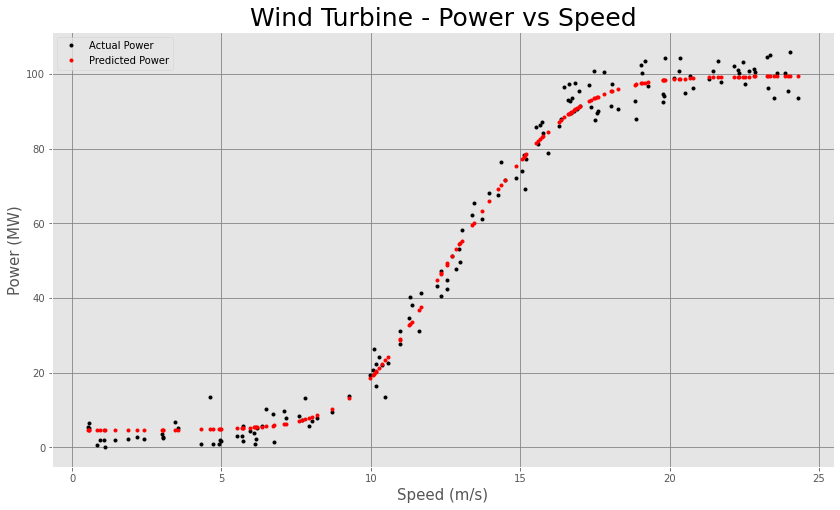

In [54]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [55]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 1ms/step - loss: 14.6943


14.69427490234375

In [56]:
y_pred = model.predict(X_test)

In [57]:
y_test.shape = (-1,1)

In [58]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99096


### 5.5 - Test model consisting of: 5 neurons 5000 epochs, batch size=10

![5-neurons](Images/5-neurons.JPG)<br><p style='text-align: right;'>(http://alexlenail.me/NN-SVG/index.html, 2020)</p>

Finally, we will look at a model with 5 neurons in the hidden layer

In [59]:
# Build a model using Keras
model = kr.models.Sequential()
# Change the hidden layer from 3 neurons to 5 neurons
model.add(kr.layers.Dense(5, input_shape=(1,), activation='sigmoid', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.add(kr.layers.Dense(1, activation='linear', kernel_initializer="glorot_uniform", bias_initializer="glorot_uniform"))
model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')

In [60]:
# Fit the training dataset to the above model and run 5000 epochs in batches of 10 at a time.
model.fit(X_train, y_train, epochs=5000, batch_size=10)

Epoch 1/5000
31/31 [==============================] - 0s 831us/step - loss: 4559.5472
Epoch 2/5000
31/31 [==============================] - 0s 866us/step - loss: 4509.3710
Epoch 3/5000
31/31 [==============================] - 0s 798us/step - loss: 4590.2206
Epoch 4/5000
31/31 [==============================] - 0s 964us/step - loss: 4579.9924
Epoch 5/5000
31/31 [==============================] - 0s 964us/step - loss: 4355.5686
Epoch 6/5000
31/31 [==============================] - 0s 864us/step - loss: 4458.6943
Epoch 7/5000
31/31 [==============================] - 0s 1ms/step - loss: 4695.6357
Epoch 8/5000
31/31 [==============================] - 0s 1ms/step - loss: 3857.3457
Epoch 9/5000
31/31 [==============================] - 0s 766us/step - loss: 4206.0672
Epoch 10/5000
31/31 [==============================] - 0s 997us/step - loss: 4631.6811
Epoch 11/5000
31/31 [==============================] - 0s 898us/step - loss: 4227.3225
Epoch 12/5000
31/31 [==============================] - 0

31/31 [==============================] - 0s 863us/step - loss: 3075.2552
Epoch 96/5000
31/31 [==============================] - 0s 898us/step - loss: 3459.3526
Epoch 97/5000
31/31 [==============================] - 0s 964us/step - loss: 3390.1660
Epoch 98/5000
31/31 [==============================] - 0s 998us/step - loss: 3074.4467
Epoch 99/5000
31/31 [==============================] - 0s 997us/step - loss: 3475.9060
Epoch 100/5000
31/31 [==============================] - 0s 964us/step - loss: 3287.9374
Epoch 101/5000
31/31 [==============================] - 0s 931us/step - loss: 3494.6586
Epoch 102/5000
31/31 [==============================] - 0s 864us/step - loss: 2994.4875
Epoch 103/5000
31/31 [==============================] - 0s 931us/step - loss: 2996.1834
Epoch 104/5000
31/31 [==============================] - 0s 798us/step - loss: 3066.2388
Epoch 105/5000
31/31 [==============================] - 0s 898us/step - loss: 3215.5978
Epoch 106/5000
31/31 [=============================

31/31 [==============================] - 0s 881us/step - loss: 2674.1796
Epoch 189/5000
31/31 [==============================] - 0s 931us/step - loss: 2591.3533
Epoch 190/5000
31/31 [==============================] - 0s 946us/step - loss: 2466.9089
Epoch 191/5000
31/31 [==============================] - 0s 965us/step - loss: 2666.2549
Epoch 192/5000
31/31 [==============================] - 0s 896us/step - loss: 2419.7225
Epoch 193/5000
31/31 [==============================] - 0s 819us/step - loss: 2325.7127
Epoch 194/5000
31/31 [==============================] - 0s 931us/step - loss: 2576.2451
Epoch 195/5000
31/31 [==============================] - 0s 964us/step - loss: 2528.9487
Epoch 196/5000
31/31 [==============================] - 0s 962us/step - loss: 2583.6233
Epoch 197/5000
31/31 [==============================] - 0s 964us/step - loss: 2663.4505
Epoch 198/5000
31/31 [==============================] - 0s 898us/step - loss: 2506.9457
Epoch 199/5000
31/31 [=========================

31/31 [==============================] - 0s 931us/step - loss: 1750.1011
Epoch 282/5000
31/31 [==============================] - 0s 931us/step - loss: 1812.0564
Epoch 283/5000
31/31 [==============================] - 0s 1ms/step - loss: 1744.6304
Epoch 284/5000
31/31 [==============================] - 0s 964us/step - loss: 1884.3514
Epoch 285/5000
31/31 [==============================] - 0s 931us/step - loss: 1757.5768
Epoch 286/5000
31/31 [==============================] - 0s 931us/step - loss: 1701.8212
Epoch 287/5000
31/31 [==============================] - 0s 927us/step - loss: 1671.1833
Epoch 288/5000
31/31 [==============================] - 0s 932us/step - loss: 1916.6675
Epoch 289/5000
31/31 [==============================] - 0s 931us/step - loss: 1715.0882
Epoch 290/5000
31/31 [==============================] - 0s 997us/step - loss: 1838.3602
Epoch 291/5000
31/31 [==============================] - 0s 1ms/step - loss: 1740.3816
Epoch 292/5000
31/31 [=============================

31/31 [==============================] - 0s 964us/step - loss: 1333.3633
Epoch 375/5000
31/31 [==============================] - 0s 964us/step - loss: 1250.8530
Epoch 376/5000
31/31 [==============================] - 0s 931us/step - loss: 1269.2201
Epoch 377/5000
31/31 [==============================] - 0s 838us/step - loss: 1260.2317
Epoch 378/5000
31/31 [==============================] - 0s 995us/step - loss: 1226.6761
Epoch 379/5000
31/31 [==============================] - 0s 943us/step - loss: 1309.9260
Epoch 380/5000
31/31 [==============================] - 0s 842us/step - loss: 1270.3641
Epoch 381/5000
31/31 [==============================] - 0s 864us/step - loss: 1160.1161
Epoch 382/5000
31/31 [==============================] - 0s 964us/step - loss: 1164.3409
Epoch 383/5000
31/31 [==============================] - 0s 997us/step - loss: 1356.2859
Epoch 384/5000
31/31 [==============================] - 0s 921us/step - loss: 1270.2469
Epoch 385/5000
31/31 [=========================

31/31 [==============================] - 0s 964us/step - loss: 797.1130
Epoch 468/5000
31/31 [==============================] - 0s 997us/step - loss: 919.7785
Epoch 469/5000
31/31 [==============================] - 0s 932us/step - loss: 855.1665
Epoch 470/5000
31/31 [==============================] - 0s 894us/step - loss: 832.8650
Epoch 471/5000
31/31 [==============================] - 0s 964us/step - loss: 862.3640
Epoch 472/5000
31/31 [==============================] - 0s 837us/step - loss: 929.8352
Epoch 473/5000
31/31 [==============================] - 0s 898us/step - loss: 870.7888
Epoch 474/5000
31/31 [==============================] - 0s 964us/step - loss: 791.0339
Epoch 475/5000
31/31 [==============================] - 0s 931us/step - loss: 802.8882
Epoch 476/5000
31/31 [==============================] - 0s 866us/step - loss: 797.4145
Epoch 477/5000
31/31 [==============================] - 0s 831us/step - loss: 838.9203
Epoch 478/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 525.3154
Epoch 562/5000
31/31 [==============================] - 0s 844us/step - loss: 507.5724
Epoch 563/5000
31/31 [==============================] - 0s 931us/step - loss: 559.9087
Epoch 564/5000
31/31 [==============================] - 0s 864us/step - loss: 505.2057
Epoch 565/5000
31/31 [==============================] - 0s 898us/step - loss: 483.1191
Epoch 566/5000
31/31 [==============================] - 0s 866us/step - loss: 504.6925
Epoch 567/5000
31/31 [==============================] - 0s 909us/step - loss: 506.7560
Epoch 568/5000
31/31 [==============================] - 0s 886us/step - loss: 562.3296
Epoch 569/5000
31/31 [==============================] - 0s 965us/step - loss: 568.9091
Epoch 570/5000
31/31 [==============================] - 0s 797us/step - loss: 502.0661
Epoch 571/5000
31/31 [==============================] - 0s 898us/step - loss: 500.8525
Epoch 572/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 289.4185
Epoch 656/5000
31/31 [==============================] - 0s 929us/step - loss: 241.9142
Epoch 657/5000
31/31 [==============================] - 0s 999us/step - loss: 312.7918
Epoch 658/5000
31/31 [==============================] - 0s 893us/step - loss: 261.4011
Epoch 659/5000
31/31 [==============================] - 0s 899us/step - loss: 299.2249
Epoch 660/5000
31/31 [==============================] - 0s 874us/step - loss: 298.3724
Epoch 661/5000
31/31 [==============================] - 0s 964us/step - loss: 246.8699
Epoch 662/5000
31/31 [==============================] - 0s 931us/step - loss: 240.4337
Epoch 663/5000
31/31 [==============================] - 0s 865us/step - loss: 278.0934
Epoch 664/5000
31/31 [==============================] - 0s 931us/step - loss: 272.8089
Epoch 665/5000
31/31 [==============================] - 0s 814us/step - loss: 287.9006
Epoch 666/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 139.4803
Epoch 750/5000
31/31 [==============================] - 0s 996us/step - loss: 121.8872
Epoch 751/5000
31/31 [==============================] - 0s 964us/step - loss: 121.0266
Epoch 752/5000
31/31 [==============================] - 0s 1ms/step - loss: 109.4410
Epoch 753/5000
31/31 [==============================] - 0s 820us/step - loss: 125.4317
Epoch 754/5000
31/31 [==============================] - 0s 898us/step - loss: 117.9915
Epoch 755/5000
31/31 [==============================] - 0s 964us/step - loss: 120.5953
Epoch 756/5000
31/31 [==============================] - 0s 898us/step - loss: 108.4675
Epoch 757/5000
31/31 [==============================] - 0s 899us/step - loss: 122.5403
Epoch 758/5000
31/31 [==============================] - 0s 814us/step - loss: 123.4295
Epoch 759/5000
31/31 [==============================] - 0s 931us/step - loss: 126.2274
Epoch 760/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 53.3959
Epoch 845/5000
31/31 [==============================] - 0s 931us/step - loss: 52.4859
Epoch 846/5000
31/31 [==============================] - 0s 931us/step - loss: 47.0667
Epoch 847/5000
31/31 [==============================] - 0s 898us/step - loss: 47.6401
Epoch 848/5000
31/31 [==============================] - 0s 786us/step - loss: 46.0328
Epoch 849/5000
31/31 [==============================] - 0s 998us/step - loss: 49.6460
Epoch 850/5000
31/31 [==============================] - 0s 1ms/step - loss: 54.3182
Epoch 851/5000
31/31 [==============================] - 0s 885us/step - loss: 46.4386
Epoch 852/5000
31/31 [==============================] - 0s 1ms/step - loss: 44.5924
Epoch 853/5000
31/31 [==============================] - 0s 909us/step - loss: 46.2320
Epoch 854/5000
31/31 [==============================] - 0s 1ms/step - loss: 41.1757
Epoch 855/5000
31/31 [==============================] - 0s 964us/step - los

31/31 [==============================] - 0s 1ms/step - loss: 21.3650
Epoch 940/5000
31/31 [==============================] - 0s 1ms/step - loss: 23.0101
Epoch 941/5000
31/31 [==============================] - 0s 997us/step - loss: 21.8292
Epoch 942/5000
31/31 [==============================] - 0s 930us/step - loss: 21.5947
Epoch 943/5000
31/31 [==============================] - 0s 999us/step - loss: 24.4368
Epoch 944/5000
31/31 [==============================] - 0s 931us/step - loss: 20.3196
Epoch 945/5000
31/31 [==============================] - 0s 931us/step - loss: 23.1653
Epoch 946/5000
31/31 [==============================] - 0s 863us/step - loss: 20.3105
Epoch 947/5000
31/31 [==============================] - 0s 787us/step - loss: 21.7512
Epoch 948/5000
31/31 [==============================] - 0s 964us/step - loss: 21.8268
Epoch 949/5000
31/31 [==============================] - 0s 963us/step - loss: 21.5768
Epoch 950/5000
31/31 [==============================] - 0s 832us/step - l

31/31 [==============================] - 0s 932us/step - loss: 20.9958
Epoch 1035/5000
31/31 [==============================] - 0s 931us/step - loss: 19.9464
Epoch 1036/5000
31/31 [==============================] - 0s 966us/step - loss: 16.4878
Epoch 1037/5000
31/31 [==============================] - 0s 827us/step - loss: 16.2092
Epoch 1038/5000
31/31 [==============================] - 0s 797us/step - loss: 15.9728
Epoch 1039/5000
31/31 [==============================] - 0s 886us/step - loss: 16.6841
Epoch 1040/5000
31/31 [==============================] - 0s 831us/step - loss: 18.2902
Epoch 1041/5000
31/31 [==============================] - 0s 912us/step - loss: 18.9589
Epoch 1042/5000
31/31 [==============================] - 0s 899us/step - loss: 17.2651
Epoch 1043/5000
31/31 [==============================] - 0s 997us/step - loss: 15.7016
Epoch 1044/5000
31/31 [==============================] - 0s 990us/step - loss: 16.0868
Epoch 1045/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 864us/step - loss: 15.7029
Epoch 1129/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.1349
Epoch 1130/5000
31/31 [==============================] - 0s 931us/step - loss: 18.5520
Epoch 1131/5000
31/31 [==============================] - 0s 965us/step - loss: 18.0833
Epoch 1132/5000
31/31 [==============================] - 0s 831us/step - loss: 17.7575
Epoch 1133/5000
31/31 [==============================] - 0s 931us/step - loss: 20.1718
Epoch 1134/5000
31/31 [==============================] - 0s 999us/step - loss: 16.5123
Epoch 1135/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2372
Epoch 1136/5000
31/31 [==============================] - 0s 997us/step - loss: 17.8908
Epoch 1137/5000
31/31 [==============================] - 0s 965us/step - loss: 16.7612
Epoch 1138/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6341
Epoch 1139/5000
31/31 [==============================] - 0s 931

31/31 [==============================] - 0s 898us/step - loss: 16.8067
Epoch 1223/5000
31/31 [==============================] - 0s 932us/step - loss: 16.6002
Epoch 1224/5000
31/31 [==============================] - 0s 932us/step - loss: 15.9090
Epoch 1225/5000
31/31 [==============================] - 0s 939us/step - loss: 17.7526
Epoch 1226/5000
31/31 [==============================] - 0s 964us/step - loss: 18.0120
Epoch 1227/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.9271
Epoch 1228/5000
31/31 [==============================] - 0s 898us/step - loss: 18.3408
Epoch 1229/5000
31/31 [==============================] - 0s 906us/step - loss: 16.9526
Epoch 1230/5000
31/31 [==============================] - 0s 853us/step - loss: 17.7148
Epoch 1231/5000
31/31 [==============================] - 0s 820us/step - loss: 18.0049
Epoch 1232/5000
31/31 [==============================] - 0s 898us/step - loss: 19.5503
Epoch 1233/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 18.7396
Epoch 1317/5000
31/31 [==============================] - 0s 998us/step - loss: 15.7837
Epoch 1318/5000
31/31 [==============================] - 0s 930us/step - loss: 16.2574
Epoch 1319/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3054
Epoch 1320/5000
31/31 [==============================] - 0s 964us/step - loss: 19.9169
Epoch 1321/5000
31/31 [==============================] - 0s 822us/step - loss: 18.2758
Epoch 1322/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2966
Epoch 1323/5000
31/31 [==============================] - 0s 865us/step - loss: 15.8657
Epoch 1324/5000
31/31 [==============================] - 0s 757us/step - loss: 19.1545
Epoch 1325/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0717
Epoch 1326/5000
31/31 [==============================] - 0s 964us/step - loss: 20.4302
Epoch 1327/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 997us/step - loss: 17.0164
Epoch 1411/5000
31/31 [==============================] - 0s 964us/step - loss: 15.2630
Epoch 1412/5000
31/31 [==============================] - 0s 864us/step - loss: 16.1435
Epoch 1413/5000
31/31 [==============================] - 0s 997us/step - loss: 16.9976
Epoch 1414/5000
31/31 [==============================] - 0s 963us/step - loss: 16.5262
Epoch 1415/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4216
Epoch 1416/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1921
Epoch 1417/5000
31/31 [==============================] - 0s 898us/step - loss: 15.7332
Epoch 1418/5000
31/31 [==============================] - 0s 866us/step - loss: 16.4321
Epoch 1419/5000
31/31 [==============================] - 0s 957us/step - loss: 16.1805
Epoch 1420/5000
31/31 [==============================] - 0s 864us/step - loss: 18.1331
Epoch 1421/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 864us/step - loss: 15.9092
Epoch 1505/5000
31/31 [==============================] - 0s 957us/step - loss: 18.7542
Epoch 1506/5000
31/31 [==============================] - 0s 997us/step - loss: 18.1419
Epoch 1507/5000
31/31 [==============================] - 0s 897us/step - loss: 16.9792
Epoch 1508/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9710
Epoch 1509/5000
31/31 [==============================] - 0s 864us/step - loss: 16.9925
Epoch 1510/5000
31/31 [==============================] - 0s 825us/step - loss: 16.5478
Epoch 1511/5000
31/31 [==============================] - 0s 931us/step - loss: 18.4325
Epoch 1512/5000
31/31 [==============================] - 0s 951us/step - loss: 18.0200
Epoch 1513/5000
31/31 [==============================] - 0s 998us/step - loss: 18.5349
Epoch 1514/5000
31/31 [==============================] - 0s 908us/step - loss: 17.2086
Epoch 1515/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 19.3124
Epoch 1599/5000
31/31 [==============================] - 0s 931us/step - loss: 14.7413
Epoch 1600/5000
31/31 [==============================] - 0s 932us/step - loss: 16.3020
Epoch 1601/5000
31/31 [==============================] - 0s 932us/step - loss: 16.9883
Epoch 1602/5000
31/31 [==============================] - 0s 998us/step - loss: 15.8625
Epoch 1603/5000
31/31 [==============================] - 0s 997us/step - loss: 18.8560
Epoch 1604/5000
31/31 [==============================] - 0s 931us/step - loss: 16.4843
Epoch 1605/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7192
Epoch 1606/5000
31/31 [==============================] - 0s 931us/step - loss: 16.8704
Epoch 1607/5000
31/31 [==============================] - 0s 829us/step - loss: 19.3885
Epoch 1608/5000
31/31 [==============================] - 0s 857us/step - loss: 14.5709
Epoch 1609/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 932us/step - loss: 19.5855
Epoch 1693/5000
31/31 [==============================] - 0s 899us/step - loss: 19.0115
Epoch 1694/5000
31/31 [==============================] - 0s 997us/step - loss: 17.9219
Epoch 1695/5000
31/31 [==============================] - 0s 965us/step - loss: 15.7474
Epoch 1696/5000
31/31 [==============================] - 0s 954us/step - loss: 15.6276
Epoch 1697/5000
31/31 [==============================] - 0s 940us/step - loss: 15.9080
Epoch 1698/5000
31/31 [==============================] - 0s 832us/step - loss: 17.6184
Epoch 1699/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2483
Epoch 1700/5000
31/31 [==============================] - 0s 999us/step - loss: 16.6526
Epoch 1701/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1026
Epoch 1702/5000
31/31 [==============================] - 0s 876us/step - loss: 16.8878
Epoch 1703/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 965us/step - loss: 18.3339
Epoch 1787/5000
31/31 [==============================] - 0s 899us/step - loss: 18.3342
Epoch 1788/5000
31/31 [==============================] - 0s 864us/step - loss: 16.8473
Epoch 1789/5000
31/31 [==============================] - 0s 964us/step - loss: 17.1941
Epoch 1790/5000
31/31 [==============================] - 0s 964us/step - loss: 17.6230
Epoch 1791/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6949
Epoch 1792/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0507
Epoch 1793/5000
31/31 [==============================] - 0s 932us/step - loss: 14.7459
Epoch 1794/5000
31/31 [==============================] - 0s 871us/step - loss: 16.4420
Epoch 1795/5000
31/31 [==============================] - 0s 864us/step - loss: 17.7530
Epoch 1796/5000
31/31 [==============================] - 0s 856us/step - loss: 18.9362
Epoch 1797/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 16.0586
Epoch 1881/5000
31/31 [==============================] - 0s 898us/step - loss: 17.9644
Epoch 1882/5000
31/31 [==============================] - 0s 864us/step - loss: 18.2022
Epoch 1883/5000
31/31 [==============================] - 0s 998us/step - loss: 18.4414
Epoch 1884/5000
31/31 [==============================] - 0s 898us/step - loss: 17.1939
Epoch 1885/5000
31/31 [==============================] - 0s 964us/step - loss: 17.8299
Epoch 1886/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2124
Epoch 1887/5000
31/31 [==============================] - 0s 924us/step - loss: 16.8562
Epoch 1888/5000
31/31 [==============================] - 0s 871us/step - loss: 16.8182
Epoch 1889/5000
31/31 [==============================] - 0s 932us/step - loss: 19.1746
Epoch 1890/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0385
Epoch 1891/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.7965
Epoch 1975/5000
31/31 [==============================] - 0s 904us/step - loss: 18.5065
Epoch 1976/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1609
Epoch 1977/5000
31/31 [==============================] - 0s 830us/step - loss: 16.3756
Epoch 1978/5000
31/31 [==============================] - 0s 898us/step - loss: 16.4870
Epoch 1979/5000
31/31 [==============================] - 0s 890us/step - loss: 18.2211
Epoch 1980/5000
31/31 [==============================] - 0s 964us/step - loss: 16.5874
Epoch 1981/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8088
Epoch 1982/5000
31/31 [==============================] - 0s 830us/step - loss: 18.1537
Epoch 1983/5000
31/31 [==============================] - 0s 810us/step - loss: 17.7037
Epoch 1984/5000
31/31 [==============================] - 0s 864us/step - loss: 16.8491
Epoch 1985/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 18.0190
Epoch 2069/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0579
Epoch 2070/5000
31/31 [==============================] - 0s 989us/step - loss: 20.5642
Epoch 2071/5000
31/31 [==============================] - 0s 835us/step - loss: 17.8562
Epoch 2072/5000
31/31 [==============================] - 0s 866us/step - loss: 15.8876
Epoch 2073/5000
31/31 [==============================] - 0s 964us/step - loss: 17.9476
Epoch 2074/5000
31/31 [==============================] - 0s 931us/step - loss: 20.2644
Epoch 2075/5000
31/31 [==============================] - 0s 799us/step - loss: 18.6522
Epoch 2076/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6468
Epoch 2077/5000
31/31 [==============================] - 0s 964us/step - loss: 16.7191
Epoch 2078/5000
31/31 [==============================] - 0s 964us/step - loss: 15.8749
Epoch 2079/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 930us/step - loss: 17.9866
Epoch 2163/5000
31/31 [==============================] - 0s 899us/step - loss: 19.0361
Epoch 2164/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2416
Epoch 2165/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.1576
Epoch 2166/5000
31/31 [==============================] - 0s 898us/step - loss: 19.0011
Epoch 2167/5000
31/31 [==============================] - 0s 931us/step - loss: 16.7703
Epoch 2168/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2789
Epoch 2169/5000
31/31 [==============================] - 0s 997us/step - loss: 16.2079
Epoch 2170/5000
31/31 [==============================] - 0s 997us/step - loss: 16.2708
Epoch 2171/5000
31/31 [==============================] - 0s 931us/step - loss: 19.4955
Epoch 2172/5000
31/31 [==============================] - 0s 864us/step - loss: 15.8369
Epoch 2173/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 931us/step - loss: 17.0432
Epoch 2257/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6556
Epoch 2258/5000
31/31 [==============================] - 0s 897us/step - loss: 15.4302
Epoch 2259/5000
31/31 [==============================] - 0s 931us/step - loss: 19.0365
Epoch 2260/5000
31/31 [==============================] - 0s 996us/step - loss: 15.7920
Epoch 2261/5000
31/31 [==============================] - 0s 863us/step - loss: 17.8235
Epoch 2262/5000
31/31 [==============================] - 0s 818us/step - loss: 16.0994
Epoch 2263/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2341
Epoch 2264/5000
31/31 [==============================] - 0s 863us/step - loss: 17.5738
Epoch 2265/5000
31/31 [==============================] - 0s 810us/step - loss: 17.4341
Epoch 2266/5000
31/31 [==============================] - 0s 997us/step - loss: 21.8782
Epoch 2267/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 897us/step - loss: 16.7799
Epoch 2351/5000
31/31 [==============================] - 0s 931us/step - loss: 17.6853
Epoch 2352/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6587
Epoch 2353/5000
31/31 [==============================] - 0s 864us/step - loss: 18.9578
Epoch 2354/5000
31/31 [==============================] - 0s 964us/step - loss: 18.3918
Epoch 2355/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1846
Epoch 2356/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7060
Epoch 2357/5000
31/31 [==============================] - 0s 997us/step - loss: 17.3971
Epoch 2358/5000
31/31 [==============================] - 0s 831us/step - loss: 17.3875
Epoch 2359/5000
31/31 [==============================] - 0s 837us/step - loss: 17.4708
Epoch 2360/5000
31/31 [==============================] - 0s 887us/step - loss: 16.9587
Epoch 2361/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 965us/step - loss: 20.8480
Epoch 2445/5000
31/31 [==============================] - 0s 898us/step - loss: 16.9393
Epoch 2446/5000
31/31 [==============================] - 0s 898us/step - loss: 19.3709
Epoch 2447/5000
31/31 [==============================] - 0s 965us/step - loss: 17.1230
Epoch 2448/5000
31/31 [==============================] - 0s 899us/step - loss: 18.3774
Epoch 2449/5000
31/31 [==============================] - 0s 964us/step - loss: 18.8844
Epoch 2450/5000
31/31 [==============================] - 0s 931us/step - loss: 22.3705
Epoch 2451/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.6558
Epoch 2452/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0631
Epoch 2453/5000
31/31 [==============================] - 0s 997us/step - loss: 20.2994
Epoch 2454/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6975
Epoch 2455/5000
31/31 [==============================] - 0s 1

31/31 [==============================] - 0s 898us/step - loss: 17.1096
Epoch 2539/5000
31/31 [==============================] - 0s 899us/step - loss: 18.3190
Epoch 2540/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2290
Epoch 2541/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9280
Epoch 2542/5000
31/31 [==============================] - 0s 997us/step - loss: 18.4906
Epoch 2543/5000
31/31 [==============================] - 0s 964us/step - loss: 16.5159
Epoch 2544/5000
31/31 [==============================] - 0s 964us/step - loss: 15.8460
Epoch 2545/5000
31/31 [==============================] - 0s 965us/step - loss: 15.6128
Epoch 2546/5000
31/31 [==============================] - 0s 932us/step - loss: 18.7450
Epoch 2547/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2086
Epoch 2548/5000
31/31 [==============================] - 0s 852us/step - loss: 17.2282
Epoch 2549/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.7236
Epoch 2633/5000
31/31 [==============================] - 0s 997us/step - loss: 16.6081
Epoch 2634/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.8342
Epoch 2635/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7888
Epoch 2636/5000
31/31 [==============================] - 0s 996us/step - loss: 15.6810
Epoch 2637/5000
31/31 [==============================] - 0s 964us/step - loss: 15.3913
Epoch 2638/5000
31/31 [==============================] - 0s 879us/step - loss: 19.1428
Epoch 2639/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0205
Epoch 2640/5000
31/31 [==============================] - 0s 997us/step - loss: 14.6504
Epoch 2641/5000
31/31 [==============================] - 0s 997us/step - loss: 16.7895
Epoch 2642/5000
31/31 [==============================] - 0s 932us/step - loss: 18.6815
Epoch 2643/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 931us/step - loss: 17.2006
Epoch 2727/5000
31/31 [==============================] - 0s 899us/step - loss: 17.5419
Epoch 2728/5000
31/31 [==============================] - 0s 826us/step - loss: 17.3981
Epoch 2729/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2103
Epoch 2730/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2543
Epoch 2731/5000
31/31 [==============================] - 0s 831us/step - loss: 16.6325
Epoch 2732/5000
31/31 [==============================] - 0s 841us/step - loss: 16.5334
Epoch 2733/5000
31/31 [==============================] - 0s 921us/step - loss: 16.0664
Epoch 2734/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.2213
Epoch 2735/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7562
Epoch 2736/5000
31/31 [==============================] - 0s 997us/step - loss: 16.4591
Epoch 2737/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 931us/step - loss: 16.4886
Epoch 2821/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5183
Epoch 2822/5000
31/31 [==============================] - 0s 899us/step - loss: 18.9783
Epoch 2823/5000
31/31 [==============================] - 0s 964us/step - loss: 19.2573
Epoch 2824/5000
31/31 [==============================] - 0s 932us/step - loss: 15.4905
Epoch 2825/5000
31/31 [==============================] - 0s 997us/step - loss: 19.2816
Epoch 2826/5000
31/31 [==============================] - 0s 931us/step - loss: 18.1659
Epoch 2827/5000
31/31 [==============================] - 0s 964us/step - loss: 15.5051
Epoch 2828/5000
31/31 [==============================] - 0s 830us/step - loss: 15.6998
Epoch 2829/5000
31/31 [==============================] - 0s 865us/step - loss: 16.9554
Epoch 2830/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.5888
Epoch 2831/5000
31/31 [==============================] - 0s 1ms

31/31 [==============================] - 0s 899us/step - loss: 14.8153
Epoch 2915/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0834
Epoch 2916/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3150
Epoch 2917/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.0108
Epoch 2918/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.4460
Epoch 2919/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.9810
Epoch 2920/5000
31/31 [==============================] - 0s 798us/step - loss: 19.3936
Epoch 2921/5000
31/31 [==============================] - 0s 898us/step - loss: 15.9716
Epoch 2922/5000
31/31 [==============================] - 0s 863us/step - loss: 17.2817
Epoch 2923/5000
31/31 [==============================] - 0s 951us/step - loss: 18.9755
Epoch 2924/5000
31/31 [==============================] - 0s 931us/step - loss: 16.8562
Epoch 2925/5000
31/31 [==============================] - 0s 898us

31/31 [==============================] - 0s 965us/step - loss: 17.4431
Epoch 3009/5000
31/31 [==============================] - 0s 930us/step - loss: 15.5404
Epoch 3010/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5567
Epoch 3011/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7487
Epoch 3012/5000
31/31 [==============================] - 0s 864us/step - loss: 16.9052
Epoch 3013/5000
31/31 [==============================] - 0s 898us/step - loss: 18.9950
Epoch 3014/5000
31/31 [==============================] - 0s 864us/step - loss: 18.8365
Epoch 3015/5000
31/31 [==============================] - 0s 838us/step - loss: 19.3839
Epoch 3016/5000
31/31 [==============================] - 0s 997us/step - loss: 17.2006
Epoch 3017/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2203
Epoch 3018/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.5734
Epoch 3019/5000
31/31 [==============================] - 0s 898us

31/31 [==============================] - 0s 997us/step - loss: 15.9646
Epoch 3103/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0988
Epoch 3104/5000
31/31 [==============================] - 0s 931us/step - loss: 15.5650
Epoch 3105/5000
31/31 [==============================] - 0s 931us/step - loss: 15.2755
Epoch 3106/5000
31/31 [==============================] - 0s 810us/step - loss: 17.5564
Epoch 3107/5000
31/31 [==============================] - 0s 891us/step - loss: 17.7441
Epoch 3108/5000
31/31 [==============================] - 0s 931us/step - loss: 17.1365
Epoch 3109/5000
31/31 [==============================] - 0s 901us/step - loss: 17.3615
Epoch 3110/5000
31/31 [==============================] - 0s 830us/step - loss: 14.7714
Epoch 3111/5000
31/31 [==============================] - 0s 828us/step - loss: 15.7031
Epoch 3112/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7413
Epoch 3113/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 19.5182
Epoch 3197/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9646
Epoch 3198/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.8913
Epoch 3199/5000
31/31 [==============================] - 0s 898us/step - loss: 16.3927
Epoch 3200/5000
31/31 [==============================] - 0s 931us/step - loss: 16.0214
Epoch 3201/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3466
Epoch 3202/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.5836
Epoch 3203/5000
31/31 [==============================] - 0s 997us/step - loss: 17.4543
Epoch 3204/5000
31/31 [==============================] - 0s 931us/step - loss: 16.4406
Epoch 3205/5000
31/31 [==============================] - 0s 864us/step - loss: 16.9042
Epoch 3206/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.2351
Epoch 3207/5000
31/31 [==============================] - 0s 964us

31/31 [==============================] - 0s 899us/step - loss: 17.4557
Epoch 3291/5000
31/31 [==============================] - 0s 965us/step - loss: 15.9858
Epoch 3292/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2736
Epoch 3293/5000
31/31 [==============================] - 0s 954us/step - loss: 16.1090
Epoch 3294/5000
31/31 [==============================] - 0s 963us/step - loss: 15.9940
Epoch 3295/5000
31/31 [==============================] - 0s 898us/step - loss: 17.0261
Epoch 3296/5000
31/31 [==============================] - 0s 819us/step - loss: 17.3809
Epoch 3297/5000
31/31 [==============================] - 0s 964us/step - loss: 16.3683
Epoch 3298/5000
31/31 [==============================] - 0s 931us/step - loss: 18.4563
Epoch 3299/5000
31/31 [==============================] - 0s 932us/step - loss: 16.7738
Epoch 3300/5000
31/31 [==============================] - 0s 831us/step - loss: 14.5558
Epoch 3301/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 964us/step - loss: 17.2766
Epoch 3385/5000
31/31 [==============================] - 0s 1ms/step - loss: 19.7349
Epoch 3386/5000
31/31 [==============================] - 0s 997us/step - loss: 17.0416
Epoch 3387/5000
31/31 [==============================] - 0s 803us/step - loss: 18.7811
Epoch 3388/5000
31/31 [==============================] - 0s 905us/step - loss: 15.7409
Epoch 3389/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9444
Epoch 3390/5000
31/31 [==============================] - 0s 997us/step - loss: 18.1748
Epoch 3391/5000
31/31 [==============================] - 0s 861us/step - loss: 16.1168
Epoch 3392/5000
31/31 [==============================] - 0s 865us/step - loss: 15.4244
Epoch 3393/5000
31/31 [==============================] - 0s 870us/step - loss: 17.2186
Epoch 3394/5000
31/31 [==============================] - 0s 931us/step - loss: 15.1987
Epoch 3395/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 898us/step - loss: 18.2582
Epoch 3479/5000
31/31 [==============================] - 0s 898us/step - loss: 19.5773
Epoch 3480/5000
31/31 [==============================] - 0s 898us/step - loss: 14.9502
Epoch 3481/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1623
Epoch 3482/5000
31/31 [==============================] - 0s 898us/step - loss: 20.3846
Epoch 3483/5000
31/31 [==============================] - 0s 929us/step - loss: 18.2334
Epoch 3484/5000
31/31 [==============================] - 0s 807us/step - loss: 17.1607
Epoch 3485/5000
31/31 [==============================] - 0s 932us/step - loss: 16.9284
Epoch 3486/5000
31/31 [==============================] - 0s 964us/step - loss: 17.2413
Epoch 3487/5000
31/31 [==============================] - 0s 997us/step - loss: 21.1509
Epoch 3488/5000
31/31 [==============================] - 0s 964us/step - loss: 19.1927
Epoch 3489/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 931us/step - loss: 19.1477
Epoch 3573/5000
31/31 [==============================] - 0s 898us/step - loss: 20.1915
Epoch 3574/5000
31/31 [==============================] - 0s 897us/step - loss: 19.3107
Epoch 3575/5000
31/31 [==============================] - 0s 896us/step - loss: 17.7154
Epoch 3576/5000
31/31 [==============================] - 0s 964us/step - loss: 18.2671
Epoch 3577/5000
31/31 [==============================] - 0s 866us/step - loss: 17.2221
Epoch 3578/5000
31/31 [==============================] - 0s 865us/step - loss: 15.5650
Epoch 3579/5000
31/31 [==============================] - 0s 964us/step - loss: 18.3272
Epoch 3580/5000
31/31 [==============================] - 0s 997us/step - loss: 16.5385
Epoch 3581/5000
31/31 [==============================] - 0s 913us/step - loss: 16.5025
Epoch 3582/5000
31/31 [==============================] - 0s 930us/step - loss: 16.1453
Epoch 3583/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 898us/step - loss: 17.6524
Epoch 3667/5000
31/31 [==============================] - 0s 964us/step - loss: 20.0942
Epoch 3668/5000
31/31 [==============================] - 0s 889us/step - loss: 16.4973
Epoch 3669/5000
31/31 [==============================] - 0s 792us/step - loss: 17.6621
Epoch 3670/5000
31/31 [==============================] - 0s 889us/step - loss: 16.9276
Epoch 3671/5000
31/31 [==============================] - 0s 964us/step - loss: 19.1355
Epoch 3672/5000
31/31 [==============================] - 0s 998us/step - loss: 17.1554
Epoch 3673/5000
31/31 [==============================] - 0s 932us/step - loss: 16.3048
Epoch 3674/5000
31/31 [==============================] - 0s 867us/step - loss: 17.3237
Epoch 3675/5000
31/31 [==============================] - 0s 797us/step - loss: 14.7509
Epoch 3676/5000
31/31 [==============================] - 0s 930us/step - loss: 16.0344
Epoch 3677/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 864us/step - loss: 16.5444
Epoch 3761/5000
31/31 [==============================] - 0s 996us/step - loss: 17.1898
Epoch 3762/5000
31/31 [==============================] - 0s 997us/step - loss: 20.1679
Epoch 3763/5000
31/31 [==============================] - 0s 898us/step - loss: 17.8747
Epoch 3764/5000
31/31 [==============================] - 0s 820us/step - loss: 14.6626
Epoch 3765/5000
31/31 [==============================] - 0s 864us/step - loss: 17.7938
Epoch 3766/5000
31/31 [==============================] - 0s 1ms/step - loss: 15.7987
Epoch 3767/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2238
Epoch 3768/5000
31/31 [==============================] - 0s 958us/step - loss: 15.6192
Epoch 3769/5000
31/31 [==============================] - 0s 964us/step - loss: 17.0132
Epoch 3770/5000
31/31 [==============================] - 0s 858us/step - loss: 15.3553
Epoch 3771/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 964us/step - loss: 15.8943
Epoch 3855/5000
31/31 [==============================] - 0s 931us/step - loss: 15.1794
Epoch 3856/5000
31/31 [==============================] - 0s 932us/step - loss: 18.5656
Epoch 3857/5000
31/31 [==============================] - 0s 931us/step - loss: 15.7901
Epoch 3858/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3151
Epoch 3859/5000
31/31 [==============================] - 0s 898us/step - loss: 17.3124
Epoch 3860/5000
31/31 [==============================] - 0s 964us/step - loss: 16.9285
Epoch 3861/5000
31/31 [==============================] - 0s 964us/step - loss: 15.4793
Epoch 3862/5000
31/31 [==============================] - 0s 830us/step - loss: 18.7778
Epoch 3863/5000
31/31 [==============================] - 0s 844us/step - loss: 17.6035
Epoch 3864/5000
31/31 [==============================] - 0s 999us/step - loss: 17.0856
Epoch 3865/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 901us/step - loss: 17.7560
Epoch 3949/5000
31/31 [==============================] - 0s 931us/step - loss: 17.5079
Epoch 3950/5000
31/31 [==============================] - 0s 831us/step - loss: 17.8736
Epoch 3951/5000
31/31 [==============================] - 0s 933us/step - loss: 19.0543
Epoch 3952/5000
31/31 [==============================] - 0s 1ms/step - loss: 20.1993
Epoch 3953/5000
31/31 [==============================] - 0s 991us/step - loss: 17.7215
Epoch 3954/5000
31/31 [==============================] - 0s 963us/step - loss: 17.3146
Epoch 3955/5000
31/31 [==============================] - 0s 964us/step - loss: 14.8152
Epoch 3956/5000
31/31 [==============================] - 0s 870us/step - loss: 15.2481
Epoch 3957/5000
31/31 [==============================] - 0s 841us/step - loss: 18.1006
Epoch 3958/5000
31/31 [==============================] - 0s 864us/step - loss: 17.2695
Epoch 3959/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 866us/step - loss: 18.9991
Epoch 4043/5000
31/31 [==============================] - 0s 997us/step - loss: 16.7748
Epoch 4044/5000
31/31 [==============================] - 0s 898us/step - loss: 18.3669
Epoch 4045/5000
31/31 [==============================] - 0s 964us/step - loss: 18.1841
Epoch 4046/5000
31/31 [==============================] - 0s 831us/step - loss: 19.3776
Epoch 4047/5000
31/31 [==============================] - 0s 964us/step - loss: 17.3931
Epoch 4048/5000
31/31 [==============================] - 0s 964us/step - loss: 17.5320
Epoch 4049/5000
31/31 [==============================] - 0s 931us/step - loss: 17.0271
Epoch 4050/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7711
Epoch 4051/5000
31/31 [==============================] - 0s 899us/step - loss: 18.4854
Epoch 4052/5000
31/31 [==============================] - 0s 832us/step - loss: 19.7257
Epoch 4053/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 932us/step - loss: 17.6373
Epoch 4137/5000
31/31 [==============================] - 0s 931us/step - loss: 17.7140
Epoch 4138/5000
31/31 [==============================] - 0s 898us/step - loss: 16.8123
Epoch 4139/5000
31/31 [==============================] - 0s 998us/step - loss: 16.7919
Epoch 4140/5000
31/31 [==============================] - 0s 931us/step - loss: 18.6992
Epoch 4141/5000
31/31 [==============================] - 0s 965us/step - loss: 17.8773
Epoch 4142/5000
31/31 [==============================] - 0s 848us/step - loss: 16.7562
Epoch 4143/5000
31/31 [==============================] - 0s 831us/step - loss: 17.1705
Epoch 4144/5000
31/31 [==============================] - 0s 1ms/step - loss: 14.5450
Epoch 4145/5000
31/31 [==============================] - 0s 964us/step - loss: 18.6250
Epoch 4146/5000
31/31 [==============================] - 0s 929us/step - loss: 17.6235
Epoch 4147/5000
31/31 [==============================] - 0s 8

31/31 [==============================] - 0s 1ms/step - loss: 15.6266
Epoch 4231/5000
31/31 [==============================] - 0s 899us/step - loss: 16.7602
Epoch 4232/5000
31/31 [==============================] - 0s 964us/step - loss: 15.4173
Epoch 4233/5000
31/31 [==============================] - 0s 931us/step - loss: 16.9065
Epoch 4234/5000
31/31 [==============================] - 0s 932us/step - loss: 17.0617
Epoch 4235/5000
31/31 [==============================] - 0s 919us/step - loss: 16.2286
Epoch 4236/5000
31/31 [==============================] - 0s 997us/step - loss: 16.7909
Epoch 4237/5000
31/31 [==============================] - 0s 898us/step - loss: 17.2215
Epoch 4238/5000
31/31 [==============================] - 0s 782us/step - loss: 17.4675
Epoch 4239/5000
31/31 [==============================] - 0s 837us/step - loss: 16.5264
Epoch 4240/5000
31/31 [==============================] - 0s 899us/step - loss: 17.4473
Epoch 4241/5000
31/31 [==============================] - 0s 8

Epoch 4324/5000
31/31 [==============================] - 0s 931us/step - loss: 18.7682
Epoch 4325/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7563
Epoch 4326/5000
31/31 [==============================] - 0s 963us/step - loss: 15.6986
Epoch 4327/5000
31/31 [==============================] - 0s 898us/step - loss: 17.5003
Epoch 4328/5000
31/31 [==============================] - 0s 799us/step - loss: 18.7592
Epoch 4329/5000
31/31 [==============================] - 0s 964us/step - loss: 16.8033
Epoch 4330/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4810
Epoch 4331/5000
31/31 [==============================] - 0s 929us/step - loss: 18.4955
Epoch 4332/5000
31/31 [==============================] - 0s 827us/step - loss: 16.6977
Epoch 4333/5000
31/31 [==============================] - 0s 827us/step - loss: 17.3715
Epoch 4334/5000
31/31 [==============================] - 0s 997us/step - loss: 18.3310
Epoch 4335/5000
31/31 [====================

31/31 [==============================] - 0s 931us/step - loss: 17.4729
Epoch 4419/5000
31/31 [==============================] - 0s 864us/step - loss: 19.6164
Epoch 4420/5000
31/31 [==============================] - 0s 898us/step - loss: 17.7936
Epoch 4421/5000
31/31 [==============================] - 0s 898us/step - loss: 18.1340
Epoch 4422/5000
31/31 [==============================] - 0s 866us/step - loss: 16.6811
Epoch 4423/5000
31/31 [==============================] - 0s 930us/step - loss: 18.6604
Epoch 4424/5000
31/31 [==============================] - 0s 898us/step - loss: 15.8035
Epoch 4425/5000
31/31 [==============================] - 0s 963us/step - loss: 19.6603
Epoch 4426/5000
31/31 [==============================] - 0s 964us/step - loss: 15.9894
Epoch 4427/5000
31/31 [==============================] - 0s 997us/step - loss: 17.1024
Epoch 4428/5000
31/31 [==============================] - 0s 931us/step - loss: 16.3777
Epoch 4429/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 1ms/step - loss: 17.0588
Epoch 4513/5000
31/31 [==============================] - 0s 932us/step - loss: 18.4294
Epoch 4514/5000
31/31 [==============================] - 0s 931us/step - loss: 16.7032
Epoch 4515/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3928
Epoch 4516/5000
31/31 [==============================] - 0s 798us/step - loss: 18.8149
Epoch 4517/5000
31/31 [==============================] - 0s 860us/step - loss: 19.9869
Epoch 4518/5000
31/31 [==============================] - 0s 964us/step - loss: 18.4046
Epoch 4519/5000
31/31 [==============================] - 0s 861us/step - loss: 18.0748
Epoch 4520/5000
31/31 [==============================] - 0s 931us/step - loss: 19.2301
Epoch 4521/5000
31/31 [==============================] - 0s 826us/step - loss: 16.4616
Epoch 4522/5000
31/31 [==============================] - 0s 964us/step - loss: 16.0968
Epoch 4523/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 932us/step - loss: 18.5268
Epoch 4607/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.3113
Epoch 4608/5000
31/31 [==============================] - 0s 964us/step - loss: 17.7525
Epoch 4609/5000
31/31 [==============================] - 0s 1ms/step - loss: 17.5800
Epoch 4610/5000
31/31 [==============================] - 0s 898us/step - loss: 20.3142
Epoch 4611/5000
31/31 [==============================] - 0s 866us/step - loss: 18.3104
Epoch 4612/5000
31/31 [==============================] - 0s 1ms/step - loss: 16.1691
Epoch 4613/5000
31/31 [==============================] - 0s 931us/step - loss: 19.3978
Epoch 4614/5000
31/31 [==============================] - 0s 898us/step - loss: 17.6076
Epoch 4615/5000
31/31 [==============================] - 0s 931us/step - loss: 18.3467
Epoch 4616/5000
31/31 [==============================] - 0s 898us/step - loss: 18.6092
Epoch 4617/5000
31/31 [==============================] - 0s 876us

31/31 [==============================] - 0s 959us/step - loss: 17.9913
Epoch 4701/5000
31/31 [==============================] - 0s 862us/step - loss: 16.4780
Epoch 4702/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0119
Epoch 4703/5000
31/31 [==============================] - 0s 965us/step - loss: 18.3675
Epoch 4704/5000
31/31 [==============================] - 0s 931us/step - loss: 16.1936
Epoch 4705/5000
31/31 [==============================] - 0s 931us/step - loss: 18.2755
Epoch 4706/5000
31/31 [==============================] - 0s 964us/step - loss: 18.5343
Epoch 4707/5000
31/31 [==============================] - 0s 931us/step - loss: 16.8586
Epoch 4708/5000
31/31 [==============================] - 0s 832us/step - loss: 18.8602
Epoch 4709/5000
31/31 [==============================] - 0s 793us/step - loss: 16.1838
Epoch 4710/5000
31/31 [==============================] - 0s 948us/step - loss: 18.2826
Epoch 4711/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 864us/step - loss: 17.3711
Epoch 4795/5000
31/31 [==============================] - 0s 898us/step - loss: 17.6427
Epoch 4796/5000
31/31 [==============================] - 0s 931us/step - loss: 17.9722
Epoch 4797/5000
31/31 [==============================] - 0s 964us/step - loss: 17.4383
Epoch 4798/5000
31/31 [==============================] - 0s 843us/step - loss: 17.6936
Epoch 4799/5000
31/31 [==============================] - 0s 931us/step - loss: 20.4352
Epoch 4800/5000
31/31 [==============================] - 0s 897us/step - loss: 17.3637
Epoch 4801/5000
31/31 [==============================] - 0s 946us/step - loss: 17.3814
Epoch 4802/5000
31/31 [==============================] - 0s 898us/step - loss: 19.6479
Epoch 4803/5000
31/31 [==============================] - 0s 846us/step - loss: 18.0703
Epoch 4804/5000
31/31 [==============================] - 0s 997us/step - loss: 16.1064
Epoch 4805/5000
31/31 [==============================] - 0s

31/31 [==============================] - 0s 899us/step - loss: 16.5455
Epoch 4889/5000
31/31 [==============================] - 0s 964us/step - loss: 16.6282
Epoch 4890/5000
31/31 [==============================] - 0s 898us/step - loss: 18.4685
Epoch 4891/5000
31/31 [==============================] - 0s 964us/step - loss: 19.8869
Epoch 4892/5000
31/31 [==============================] - 0s 859us/step - loss: 19.3020
Epoch 4893/5000
31/31 [==============================] - 0s 964us/step - loss: 20.5368
Epoch 4894/5000
31/31 [==============================] - 0s 964us/step - loss: 18.0192
Epoch 4895/5000
31/31 [==============================] - 0s 964us/step - loss: 20.1059
Epoch 4896/5000
31/31 [==============================] - 0s 931us/step - loss: 18.0513
Epoch 4897/5000
31/31 [==============================] - 0s 1ms/step - loss: 18.1086
Epoch 4898/5000
31/31 [==============================] - 0s 964us/step - loss: 15.3621
Epoch 4899/5000
31/31 [==============================] - 0s 9

31/31 [==============================] - 0s 898us/step - loss: 16.5654
Epoch 4983/5000
31/31 [==============================] - 0s 931us/step - loss: 16.2882
Epoch 4984/5000
31/31 [==============================] - 0s 881us/step - loss: 16.9054
Epoch 4985/5000
31/31 [==============================] - 0s 898us/step - loss: 15.4550
Epoch 4986/5000
31/31 [==============================] - 0s 931us/step - loss: 17.2406
Epoch 4987/5000
31/31 [==============================] - 0s 898us/step - loss: 16.4635
Epoch 4988/5000
31/31 [==============================] - 0s 946us/step - loss: 18.0739
Epoch 4989/5000
31/31 [==============================] - 0s 965us/step - loss: 18.6971
Epoch 4990/5000
31/31 [==============================] - 0s 896us/step - loss: 18.7432
Epoch 4991/5000
31/31 [==============================] - 0s 864us/step - loss: 17.9048
Epoch 4992/5000
31/31 [==============================] - 0s 838us/step - loss: 19.1841
Epoch 4993/5000
31/31 [==============================] - 0s

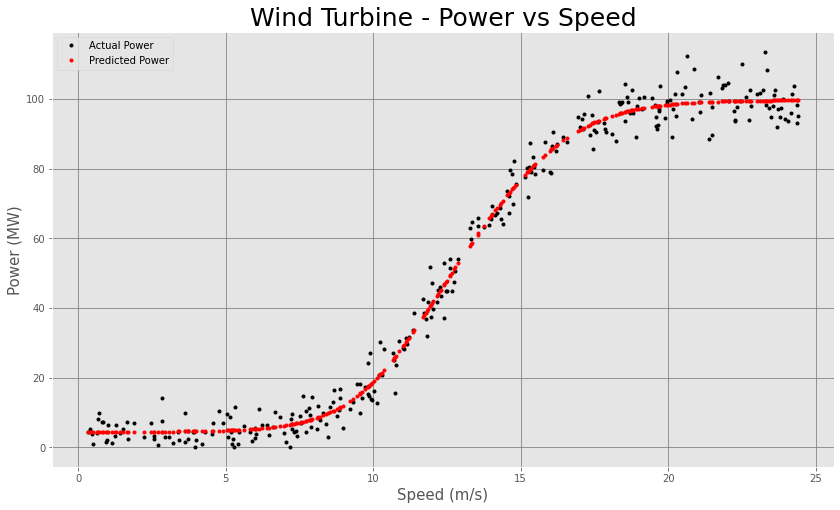

In [61]:
# Now let's see what the train dataset looks like for both the actual data and the predicted values from the model
plt.plot(X_train, y_train, 'k.', label='Actual Power')
plt.plot(X_train, model.predict(X_train), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

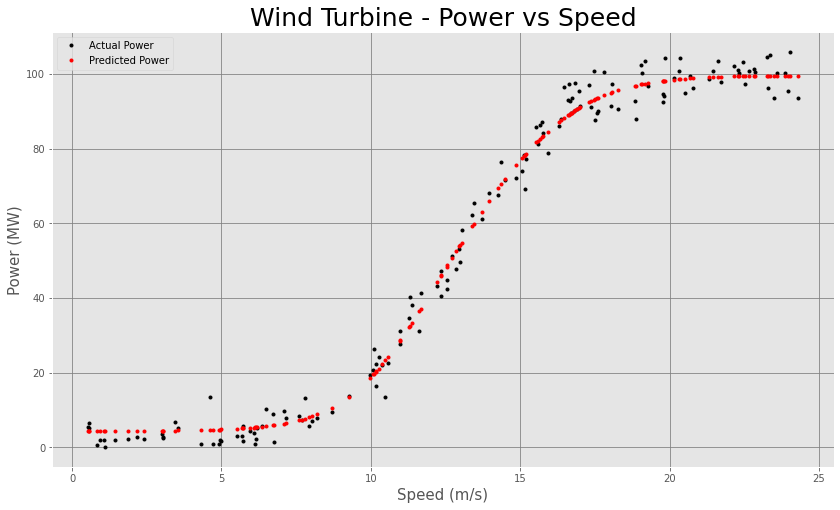

In [62]:
# The ultimate test is how the test dataset fits to its predicted reusults
# Now let's see how the test sample actual and predicted results compare, using the trained model
plt.plot(X_test, y_test, 'k.', label='Actual Power')
plt.plot(X_test, model.predict(X_test), 'r.', label='Predicted Power')
plt.title('Wind Turbine - Power vs Speed', size=25)
plt.xlabel('Speed (m/s)', size=15)
plt.ylabel('Power (MW)', size=15)
# Show grid lines
plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.legend()

In [63]:
# Evaluate the neural network on the test data.
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 998us/step - loss: 14.6044


14.604375839233398

In [64]:
y_pred = model.predict(X_test)

In [65]:
y_test.shape = (-1,1)

In [66]:
# Using the R-squared, we can measure the accuracy of the Nueral network using the test dataset
Rsquared = r2_score(y_test, y_pred)
print('R-squared: %.5f' %Rsquared)

R-squared: 0.99102


In [75]:
model.predict([0])

array([[4.4236565]], dtype=float32)